In [1]:
import time
import qiskit
import numpy as np
import pandas as pd
from tqdm import tqdm
from math import e, pi
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization.bloch import Bloch
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_histogram

In [2]:
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)

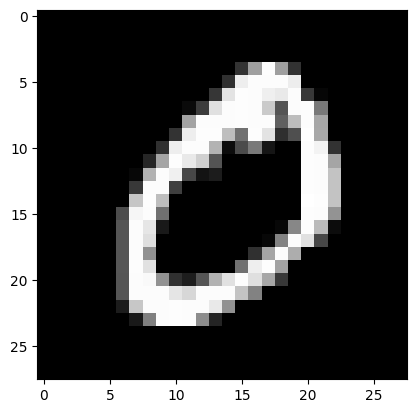

In [132]:
import cv2



# gray_scale 이미지 불러오기
mnist = cv2.imread('mnist.png', 0) # 인수를 0으로 전달하면 gray 이미지가 로드된다.

plt.imshow(mnist, cmap='gray')
plt.show()

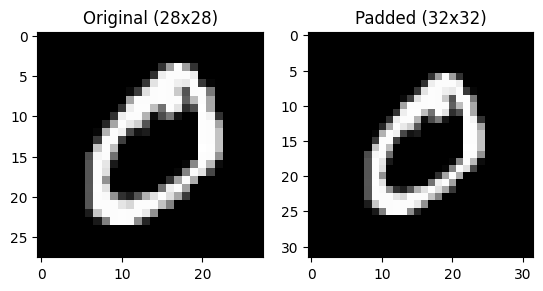

In [133]:
padded_mnist = np.pad(mnist, pad_width=((2, 2), (2, 2)), mode='constant', constant_values=0)

# 결과 출력
plt.subplot(1, 2, 1)
plt.imshow(mnist, cmap='gray')
plt.title("Original (28x28)")

plt.subplot(1, 2, 2)
plt.imshow(padded_mnist, cmap='gray')
plt.title("Padded (32x32)")

plt.show()

In [134]:
norm_mnist = padded_mnist / np.linalg.norm(padded_mnist)
sum_of_squares = np.sum(np.abs(norm_mnist) ** 2)
# 제곱근 계산
result = np.sqrt(sum_of_squares)
# 출력
print("size = " ,result)

size =  0.9999999999999999


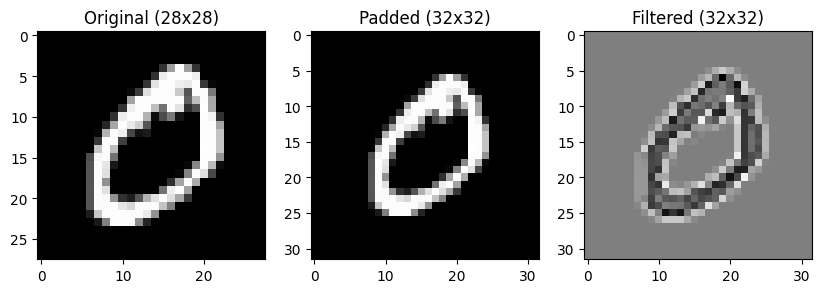

In [135]:
from scipy.signal import convolve2d
# 3x3 필터 정의 (예: 간단한 엣지 검출 필터)
filter_kernel = np.array([
    [0,  1, 0],
    [1, -4, 1],
    [0,  1, 0]
])

# 180도 회전 (고전적인 컨볼루션에서 필터는 반드시 뒤집어야 함)
rotated_filter = np.rot90(filter_kernel, 0)

# 2D Convolution 연산 적용
conv_result = convolve2d(padded_mnist, rotated_filter, mode='same', boundary='fill', fillvalue=0)
#conv_result = convolve2d(padded_mnist, filter_kernel, mode='same', boundary='fill', fillvalue=0)
# 시각화
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(mnist, cmap='gray')
plt.title("Original (28x28)")

plt.subplot(1, 3, 2)
plt.imshow(padded_mnist, cmap='gray')
plt.title("Padded (32x32)")

plt.subplot(1, 3, 3)
plt.imshow(conv_result, cmap='gray')
plt.title("Filtered (32x32)")

plt.show()

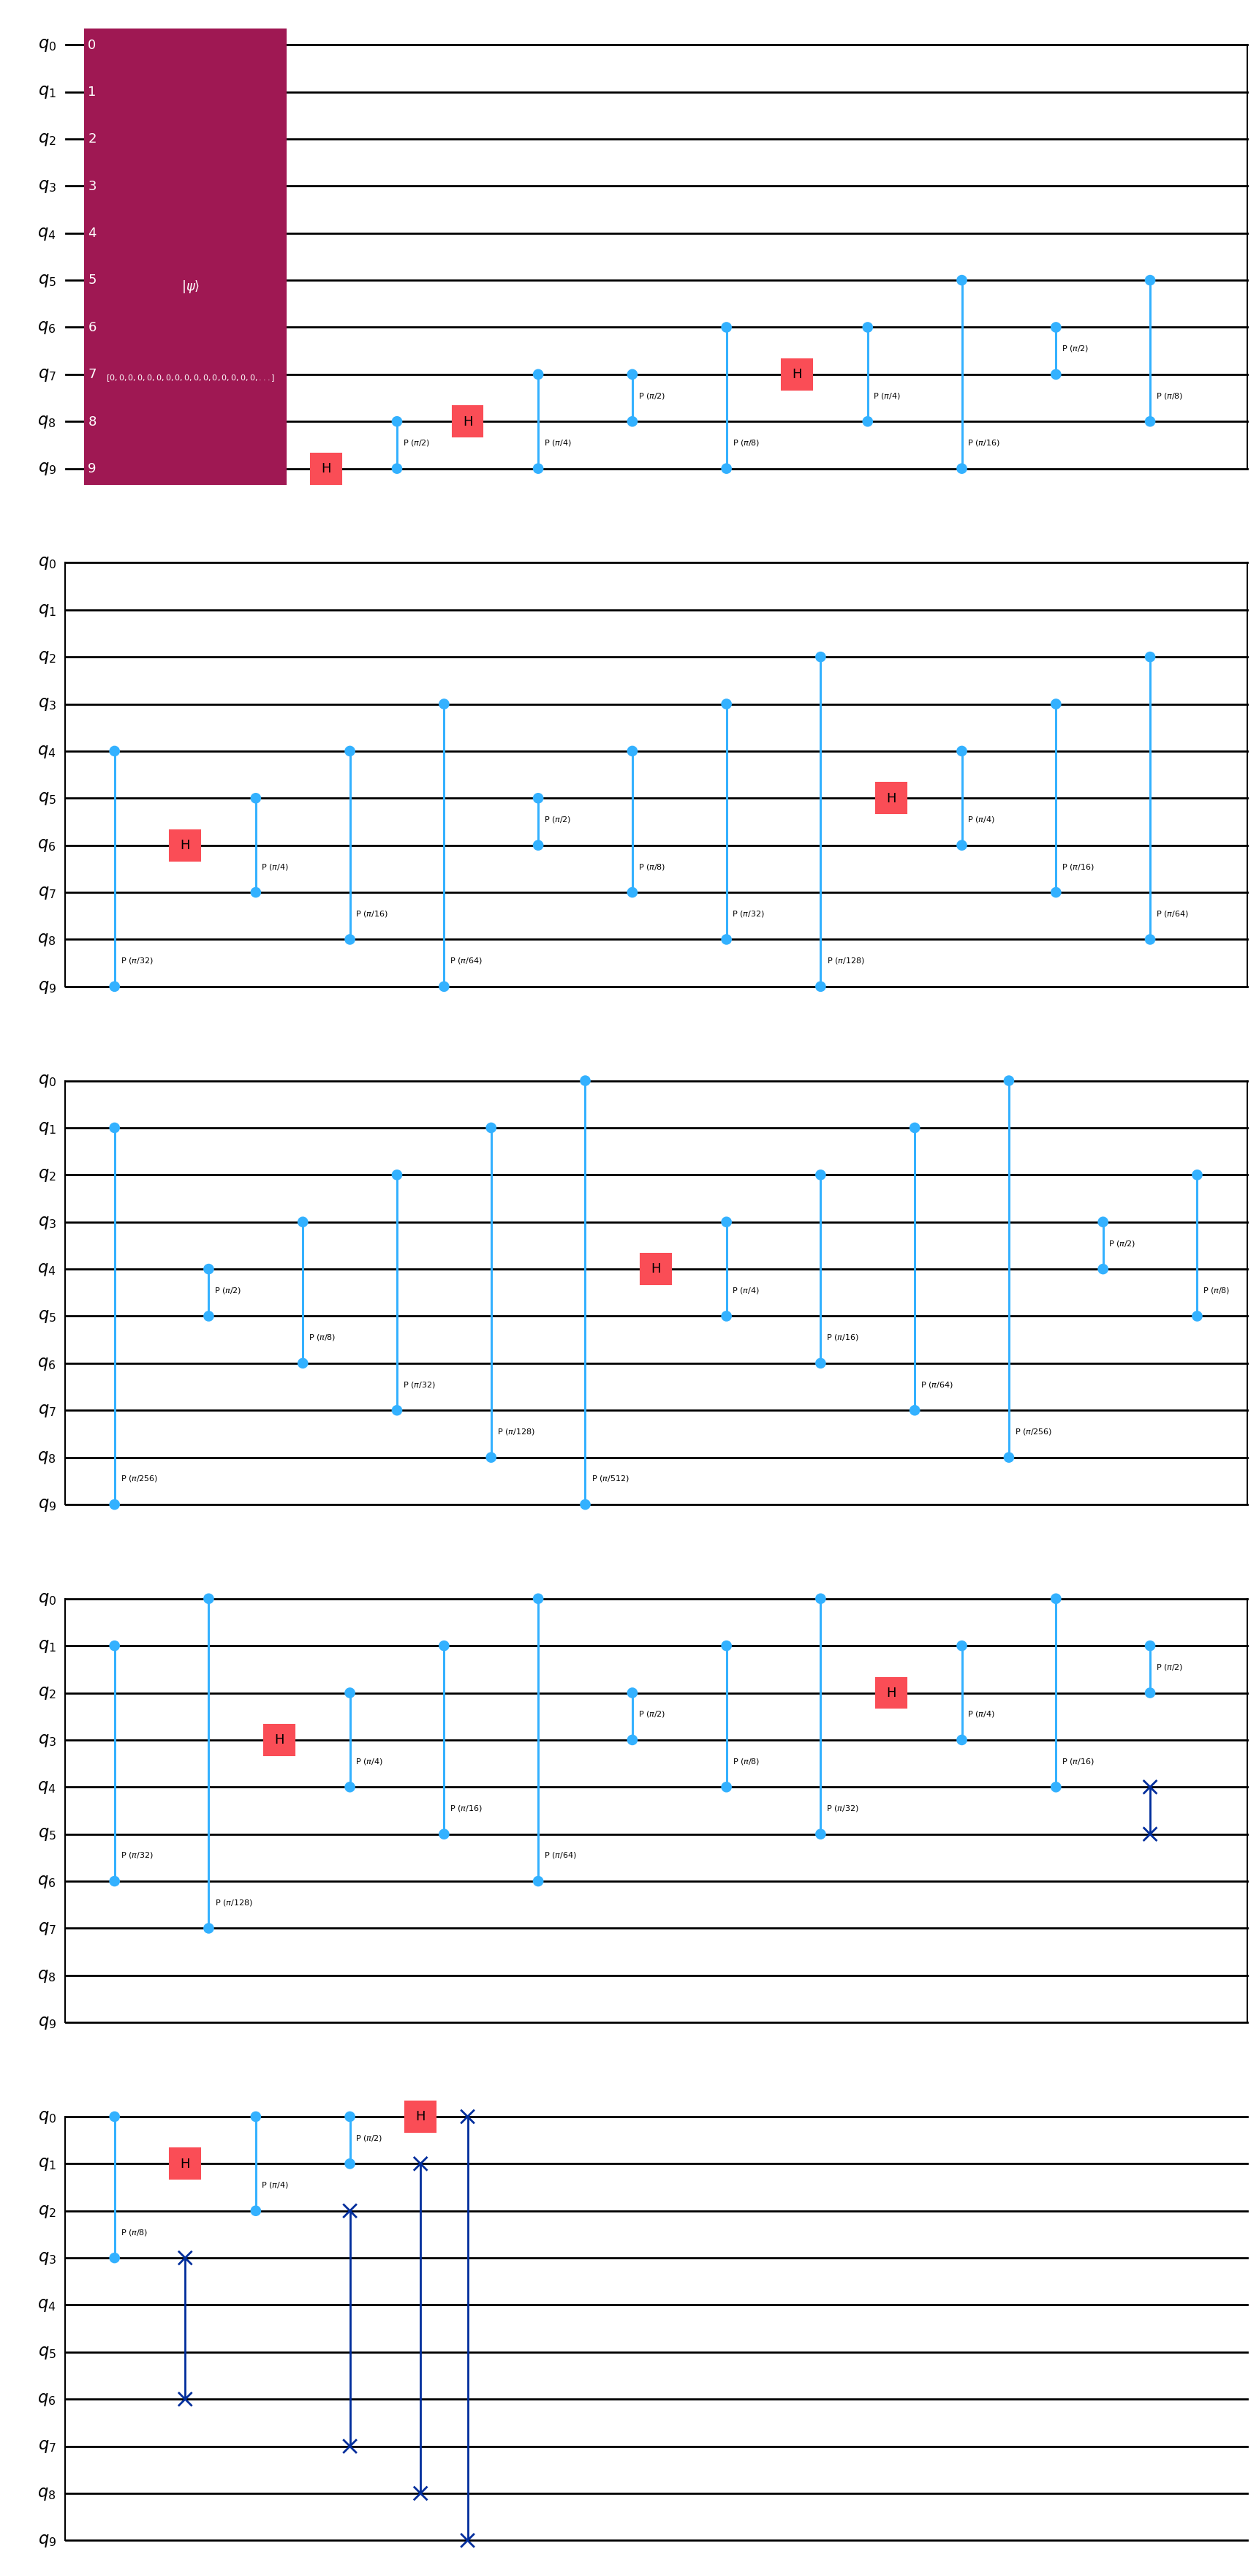

In [136]:
norm_mnist_flatten = norm_mnist.flatten()
mnist_qc = QuantumCircuit(10)
mnist_qc.initialize(norm_mnist_flatten)
qft_10 = QFT(num_qubits=10).decompose()
qft_mnist = mnist_qc.compose(qft_10)
qft_mnist.draw('mpl')

[0.       +0.j 0.2236068+0.j 0.       +0.j ... 0.       +0.j 0.       +0.j
 0.       +0.j]


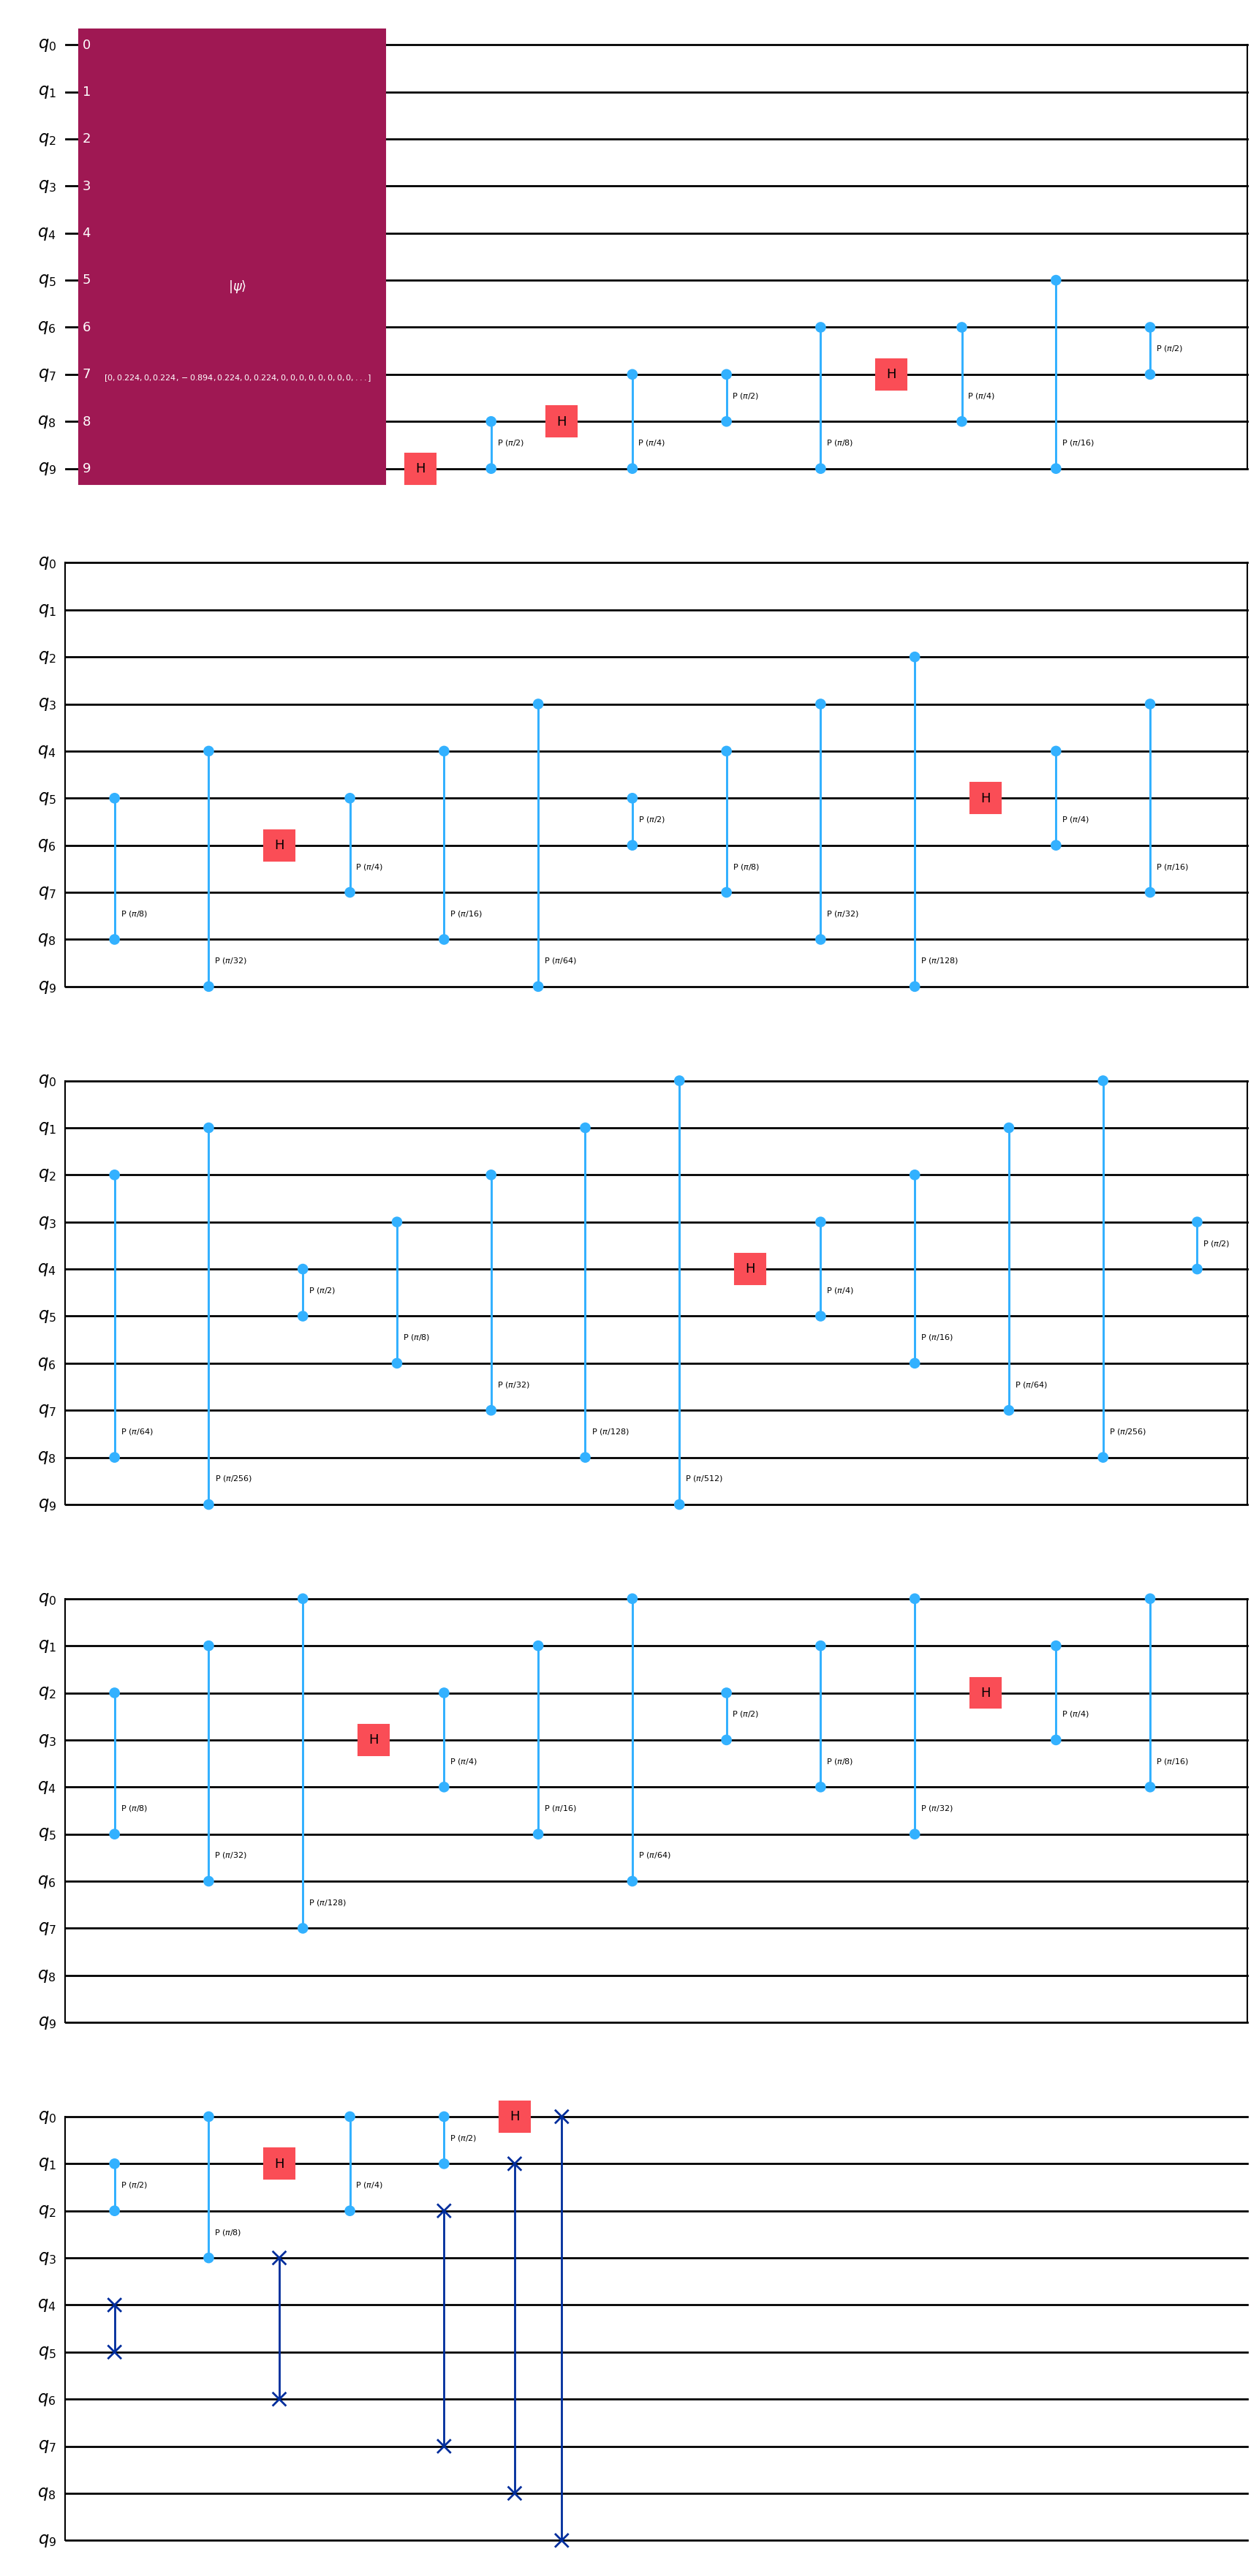

In [137]:
filter_flatten = filter_kernel.flatten()
filter_norm = filter_flatten / np.linalg.norm(filter_flatten)
filter_expand = np.zeros(1024, dtype=complex)  # 16개의 0 초기화
filter_expand[:9] = filter_norm.data  # 앞쪽 9개의 슬롯에 filter 값 복사
print(filter_expand)

filter_qc = QuantumCircuit(10)
filter_qc.initialize(filter_expand)
qft_10 = QFT(num_qubits=10).decompose()
qft_filter = filter_qc.compose(qft_10)
qft_filter.draw('mpl')

In [138]:
filter_statevec = Statevector(qft_filter, dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

In [139]:
mnist_statevec = Statevector(qft_mnist)

In [140]:
element_wise = mnist_statevec.data * filter_statevec.data
element_wise_result_state = Statevector(element_wise)

print("Element-wise product result = ", element_wise_result_state)
#coeff = np.absolute(element_wise_result_state.data[0])
element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)
print("Normalize result = ", element_wise_result_state)

Element-wise product result =  Statevector([-4.84622773e-19+0.00000000e+00j,
              4.74341603e-07-1.91393474e-09j,
              8.79876487e-07+4.07924304e-07j, ...,
             -1.56381215e-06+9.91584163e-07j,
              8.79876487e-07-4.07924304e-07j,
              4.74341603e-07+1.91393474e-09j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
Normalize result =  Statevector([-2.87368877e-17+0.00000000e+00j,
              2.81272406e-05-1.13491422e-07j,
              5.21744193e-05+2.41888651e-05j, ...,
             -9.27300504e-05+5.87983980e-05j,
              5.21744193e-05-2.41888651e-05j,
              2.81272406e-05+1.13491422e-07j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


In [141]:
element_wise_result = QuantumCircuit(10)
element_wise_result.initialize(element_wise_result_state)
iqft_10 = QFT(num_qubits=10, inverse=True).decompose()
element_wise_result_qft = element_wise_result.compose(iqft_10)

In [142]:
state_result_qft = Statevector(element_wise_result_qft)
state_result_qft

Statevector([ 1.73020963e-17+1.11005188e-17j,
              1.30096909e-18-2.94957114e-18j,
              1.86757169e-17-1.17752201e-17j, ...,
             -1.40412268e-17-1.25515042e-17j,
              5.50232973e-18+3.20800169e-18j,
             -1.17189789e-17-5.89901119e-18j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


In [143]:
real_list = [c.real for c in state_result_qft.data]
filtered_list = [x if abs(x) >= 1e-10 else 0 for x in real_list]
scaled_list = [x * 1024 for x in filtered_list]

pd.set_option('display.max_rows', None)  # 모든 행 출력
df = pd.DataFrame(scaled_list, columns=['Values'])
print(df)

          Values
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
6       0.000000
7       0.000000
8       0.000000
9       0.000000
10      0.000000
11      0.000000
12      0.000000
13      0.000000
14      0.000000
15      0.000000
16      0.000000
17      0.000000
18      0.000000
19      0.000000
20      0.000000
21      0.000000
22      0.000000
23      0.000000
24      0.000000
25      0.000000
26      0.000000
27      0.000000
28      0.000000
29      0.000000
30      0.000000
31      0.000000
32      0.000000
33      0.000000
34      0.000000
35      0.000000
36      0.000000
37      0.000000
38      0.000000
39      0.000000
40      0.000000
41      0.000000
42      0.000000
43      0.000000
44      0.000000
45      0.000000
46      0.000000
47      0.000000
48      0.000000
49      0.000000
50      0.000000
51      0.000000
52      0.000000
53      0.000000
54      0.000000
55      0.000000
56      0.000000
57      0.0000

In [144]:
result = np.array(scaled_list).reshape(32,32)
result.shape

(32, 32)

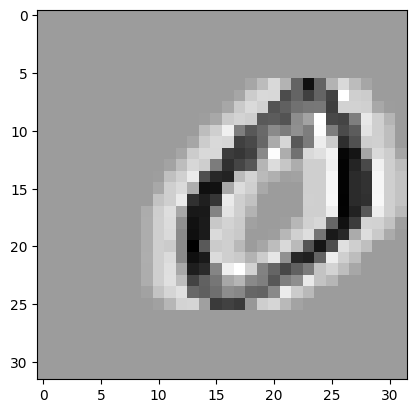

In [145]:
plt.imshow(result, cmap='gray')
plt.show()

# Filter를 중앙에 두고 expand 후 다시 연산

In [146]:
expanded_filter = np.zeros((32, 32))

# 필터를 삽입할 위치 (중앙 좌표 계산)
center_x, center_y = 16, 16  # 32의 중앙 = 16번째 위치 (0-index 기준)

# 3×3 필터를 32×32 배열의 중앙에 삽입
expanded_filter[center_x-1:center_x+2, center_y-1:center_y+2] = filter_kernel

# 결과 출력
print(expanded_filter)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [147]:
norm_mnist_flatten = norm_mnist.flatten()
mnist_qc = QuantumCircuit(10)
mnist_qc.initialize(norm_mnist_flatten)
qft_10 = QFT(num_qubits=10).decompose()
qft_mnist = mnist_qc.compose(qft_10)


In [148]:
expanded_filter_flatten = expanded_filter.flatten()
expanded_filter_flatten_norm = expanded_filter_flatten / np.linalg.norm(expanded_filter_flatten)
filter_qc = QuantumCircuit(10)
filter_qc.initialize(expanded_filter_flatten_norm)
qft_10 = QFT(num_qubits=10).decompose()
qft_filter = filter_qc.compose(qft_10)

In [149]:
filter_statevec = Statevector(qft_filter, dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
mnist_statevec = Statevector(qft_mnist)

In [150]:
element_wise = mnist_statevec.data * filter_statevec.data
element_wise_result_state = Statevector(element_wise)

print("Element-wise product result = ", element_wise_result_state)
#coeff = np.absolute(element_wise_result_state.data[0])
element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)
print("Normalize result = ", element_wise_result_state)

Element-wise product result =  Statevector([-2.42311387e-19+0.00000000e+00j,
             -4.83484760e-05-3.37031206e-06j,
              8.20234023e-05+5.39011652e-05j, ...,
              1.30327369e-04-1.30483379e-04j,
              8.20234023e-05-5.39011652e-05j,
             -4.83484760e-05+3.37031206e-06j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
Normalize result =  Statevector([-2.92755657e-17+0.j        , -5.84136390e-03-0.00040719j,
              9.90989956e-03+0.00651223j, ...,  1.57458859e-02-0.01576473j,
              9.90989956e-03-0.00651223j, -5.84136390e-03+0.00040719j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


In [151]:
element_wise_result = QuantumCircuit(10)
element_wise_result.initialize(element_wise_result_state)
iqft_10 = QFT(num_qubits=10, inverse=True).decompose()
element_wise_result_qft = element_wise_result.compose(iqft_10)

In [152]:
state_result_qft.data

array([ 1.73020963e-17+1.11005188e-17j,  1.30096909e-18-2.94957114e-18j,
        1.86757169e-17-1.17752201e-17j, ...,
       -1.40412268e-17-1.25515042e-17j,  5.50232973e-18+3.20800169e-18j,
       -1.17189789e-17-5.89901119e-18j])

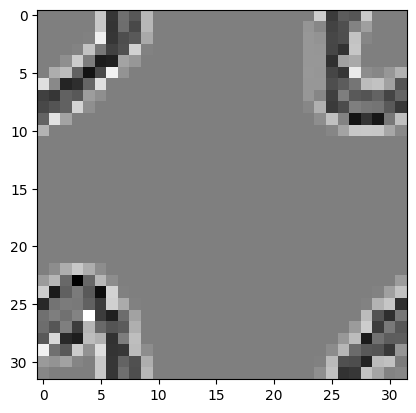

In [153]:
state_result_qft = Statevector(element_wise_result_qft)
real_list = [c.real for c in state_result_qft.data]
filtered_list = [x if abs(x) >= 1e-10 else 0 for x in real_list]
scaled_list = [x * 1024 for x in filtered_list]
result = np.array(scaled_list).reshape(32,32)
plt.imshow(result, cmap='gray')
plt.show()

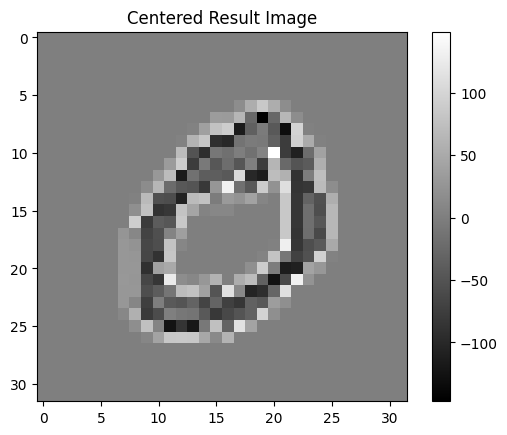

In [154]:
from scipy.fftpack import fftshift
result_centered = fftshift(result)

# 결과 출력
plt.imshow(result_centered, cmap='gray')
plt.colorbar()
plt.title("Centered Result Image")
plt.show()

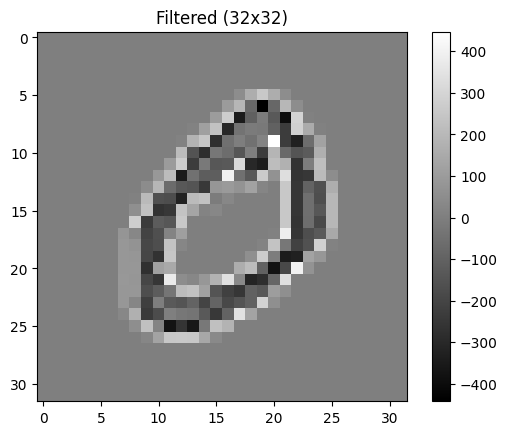

In [155]:
plt.imshow(conv_result, cmap='gray')
plt.colorbar()
plt.title("Filtered (32x32)")
plt.show()

In [182]:
# MSE 계산 함수
def mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

# MSE 계산
mse_value = mse(result_centered, conv_result)

print(f"MSE between result_centered and conv_result: {mse_value}")

MSE between result_centered and conv_result: 7051.508172896301


In [165]:
import pandas as pd
import numpy as np

# 두 이미지 (32x32) 가정
diff = np.abs(result_centered - conv_result)  # 절대 오차

# 인덱스: 위치 튜플 (row, col)
rows, cols = diff.shape
positions = [(i, j) for i in range(rows) for j in range(cols)]
errors = diff.flatten()

# DataFrame 생성
df = pd.DataFrame(positions, columns=['row', 'col'])
df['error'] = errors

# 오차 큰 순으로 정렬해서 보기
df_sorted = df.sort_values(by='error', ascending=False)

print(df_sorted.head(10))  # 오차 큰 상위 10개 출력


     row  col       error
211    6   19  526.182946
662   20   22  505.807409
308    9   20  481.937586
245    7   21  459.216828
400   12   16  438.923320
310    9   22  422.165113
241    7   17  412.218611
693   21   21  397.554916
272    8   16  391.837724
785   24   17  390.578098


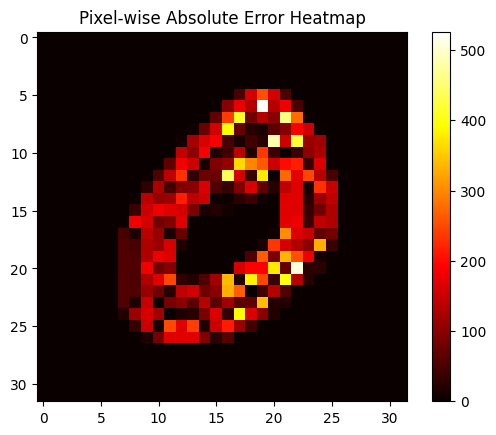

In [166]:
import matplotlib.pyplot as plt

plt.imshow(diff, cmap='hot')
plt.colorbar()
plt.title("Pixel-wise Absolute Error Heatmap")
plt.show()


In [174]:
import pandas as pd
import numpy as np

# 이미지1과 이미지2는 32x32 numpy 배열이라고 가정
# 예: image1 = result_centered, image2 = conv_result

rows, cols = conv_result.shape

# 위치 좌표
positions = [(i, j) for i in range(rows) for j in range(cols)]

# 각 픽셀 값을 flatten
vals_1 = conv_result.flatten()
vals_2 = result_centered.flatten()
errors = np.abs(vals_1 - vals_2)

# DataFrame 생성
df = pd.DataFrame(positions, columns=["row", "col"])
df["Convolution"] = vals_1
df["Quantum"] = vals_2
df["error"] = errors

# 예시 출력 (오차 큰 순)
#print(df.sort_values(by="error", ascending=False).head(10))
df_nonzero = df[df["error"] != 0]
df_nonzero.head(10)

,row,col,Convolution,Quantum,error
177,5,17,51,0.000000,51.000000
178,5,18,159,0.000000,159.000000
179,5,19,253,0.000000,253.000000
180,5,20,159,0.000000,159.000000
181,5,21,50,0.000000,50.000000
208,6,16,99,0.000000,99.000000
209,6,17,193,16.969685,176.030315
210,6,18,-80,52.905488,132.905488
211,6,19,-442,84.182946,526.182946
212,6,20,-81,52.905488,133.905488


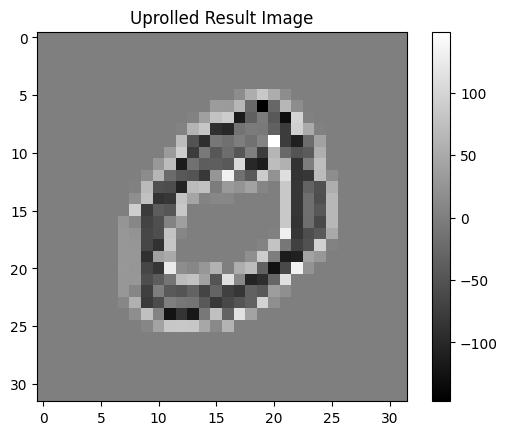

In [183]:
# 한 칸 위로, 한 칸 왼쪽으로 이동 (필터 위치 조정)
expanded_filter = np.roll(result_centered, shift=-1, axis=0)  # 위로
#expanded_filter = np.roll(expanded_filter, shift=-1, axis=1)  # 왼쪽으로
plt.imshow(expanded_filter, cmap='gray')
plt.colorbar()
plt.title("Uprolled Result Image")
plt.show()

In [186]:
mse_value = mse(expanded_filter, conv_result)

print(f"MSE between result_centered and conv_result: {mse_value}")

MSE between result_centered and conv_result: 6223.378850379872


In [184]:
import pandas as pd
import numpy as np

# 두 이미지 (32x32) 가정
diff = np.abs(expanded_filter - conv_result)  # 절대 오차

# 인덱스: 위치 튜플 (row, col)
rows, cols = diff.shape
positions = [(i, j) for i in range(rows) for j in range(cols)]
errors = diff.flatten()

# DataFrame 생성
df = pd.DataFrame(positions, columns=['row', 'col'])
df['error'] = errors

# 오차 큰 순으로 정렬해서 보기
df_sorted = df.sort_values(by='error', ascending=False)

print(df_sorted.head(10))  # 오차 큰 상위 10개 출력


     row  col       error
811   25   11  458.850207
813   25   13  445.850207
460   14   12  400.857340
364   11   12  387.793143
683   21   11  382.645862
812   25   12  339.182946
302    9   14  339.166896
271    8   15  327.501419
783   24   15  321.198995
430   13   14  320.862690


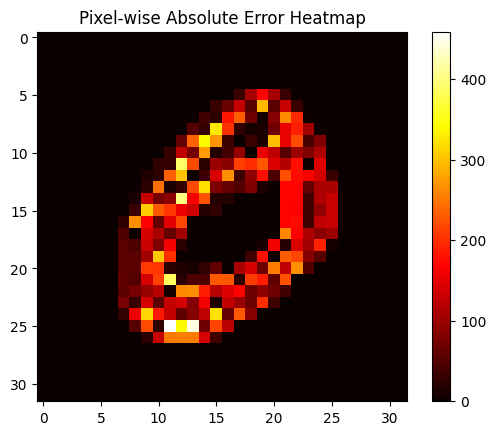

In [177]:
import matplotlib.pyplot as plt

plt.imshow(diff, cmap='hot')
plt.colorbar()
plt.title("Pixel-wise Absolute Error Heatmap")
plt.show()


In [185]:
import pandas as pd
import numpy as np

# 이미지1과 이미지2는 32x32 numpy 배열이라고 가정
# 예: image1 = result_centered, image2 = conv_result

rows, cols = conv_result.shape

# 위치 좌표
positions = [(i, j) for i in range(rows) for j in range(cols)]

# 각 픽셀 값을 flatten
vals_1 = conv_result.flatten()
vals_2 = expanded_filter.flatten()
errors = np.abs(vals_1 - vals_2)

# DataFrame 생성
df = pd.DataFrame(positions, columns=["row", "col"])
df["Convolution"] = vals_1
df["Quantum"] = vals_2
df["error"] = errors

# 예시 출력 (오차 큰 순)
#print(df.sort_values(by="error", ascending=False).head(10))
df_nonzero = df[df["error"] != 0]
df_nonzero.head(10)
#df_nonzero

,row,col,Convolution,Quantum,error
177,5,17,51,16.969685,34.030315
178,5,18,159,52.905488,106.094512
179,5,19,253,84.182946,168.817054
180,5,20,159,52.905488,106.094512
181,5,21,50,16.636946,33.363054
207,6,15,0,33.939369,33.939369
208,6,16,99,32.941153,66.058847
209,6,17,193,64.218611,128.781389
210,6,18,-80,-26.619113,53.380887
211,6,19,-442,-147.070601,294.929399


In [3]:
from qiskit import QuantumCircuit, Aer, transpile, execute
from qiskit.circuit.library import QFT
import numpy as np

# 1. 입력 신호 준비: 상태 |ψ⟩ = 1/sqrt(2)(|0⟩ + |1⟩), |φ⟩ = 1/2(sqrt(3)|0⟩ + |1⟩)
psi = QuantumCircuit(1)
phi = QuantumCircuit(1)

# |ψ⟩ 상태
psi.initialize([1/np.sqrt(2), 1/np.sqrt(2)], 0)  # First qubit

# |φ⟩ 상태
phi.initialize([np.sqrt(3)/2, 1/2], 0)  # First qubit

state_psi = Statevector(phi)
state_phi = Statevector(psi)

psi_data = state_psi.data
phi_data = state_phi.data

print(psi_data, phi_data)
convolution_result = np.array([psi_data[0]*phi_data[0]+psi_data[1]*phi_data[1],psi_data[0]*phi_data[1]+psi_data[1]*phi_data[0]])

# 컨볼루션 결과를 새로운 Statevector로 변환
result_state = Statevector(convolution_result)

# 결과 출력
print("Convolution result as a quantum state:")
print(result_state)

[0.8660254+0.j 0.5      +0.j] [0.70710678+0.j 0.70710678+0.j]
Convolution result as a quantum state:
Statevector([0.96592583+0.j, 0.96592583+0.j],
            dims=(2,))


C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


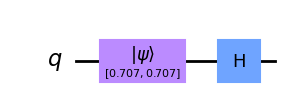

In [4]:
# 2. QFT 적용
qft_circuit = QFT(num_qubits=1).decompose()  # Create and decompose QFT for 2 qubits

psi_qft = psi.compose(qft_circuit)
psi_qft.draw('mpl')

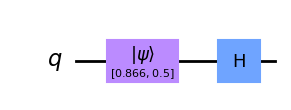

In [5]:
phi_qft = phi.compose(qft_circuit)
phi_qft.draw('mpl')

In [93]:
state_psi_qft = Statevector(psi_qft)
state_phi_qft = Statevector(phi_qft) 
print("|psi> = ", state_psi_qft)
print("|phi> = ", state_phi_qft)

element_wise = state_psi_qft.data * state_phi_qft.data
element_wise_result_state = Statevector(element_wise)

print("Element-wise product result = ", element_wise_result_state)
coeff = np.absolute(element_wise_result_state.data[0])
element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)
element_wise_result = QuantumCircuit(1)
element_wise_result.initialize(element_wise_result_state)
elemen_wise_result_qft = element_wise_result.compose(qft_circuit)
elemen_wise_result_qft.draw('mpl')

|psi> =  Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
|phi> =  Statevector([0.96592583+0.j, 0.25881905+0.j],
            dims=(2,))
Element-wise product result =  Statevector([0.96592583+0.j, 0.        +0.j],
            dims=(2,))


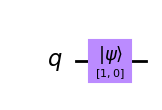

In [106]:
element_wise_result.draw('mpl')

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


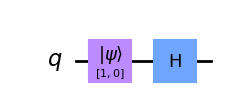

In [105]:
elemen_wise_result_qft.draw('mpl')

In [95]:
state_result_qft = Statevector(elemen_wise_result_qft)
state_result_qft = state_result_qft * np.sqrt(2) * coeff
state_result_qft

Statevector([0.96592583+0.j, 0.96592583+0.j],
            dims=(2,))


In [103]:
print( "Time domain convolution = ", result_state.data,"\n","Frequency domain multiplication = ",state_result_qft.data)

Time domain convolution =  [0.96592583+0.j 0.96592583+0.j] 
 Frequency domain multiplication =  [0.96592583+0.j 0.96592583+0.j]


# 3 qubits and 2 qubits Convolution

In [154]:
from qiskit import QuantumCircuit, Aer, transpile, execute
from qiskit.circuit.library import QFT
import numpy as np

In [209]:
# 1. 입력 신호 준비: 상태 |ψ⟩ = 1/sqrt(2)(|0⟩ + |1⟩), |φ⟩ = 1/2(sqrt(3)|0⟩ + |1⟩)
psi = QuantumCircuit(3)
phi = QuantumCircuit(2)

# |ψ⟩ 상태
psi.h(range(0,3))  # First qubit

In [210]:
# |φ⟩ 상태
initial_state = np.array([1,np.sqrt(2),np.sqrt(3),2]) * (1/np.sqrt(10))

# 2-큐빗 회로 생성
# 초기 상태 설정
phi.initialize(initial_state, [0, 1])

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


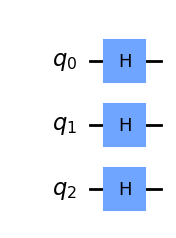

In [211]:
psi.draw('mpl')

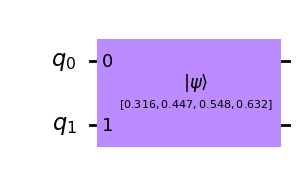

In [212]:
phi.draw('mpl')

In [160]:
state_psi = Statevector(phi)
state_phi = Statevector(psi)

psi_data = state_psi.data
phi_data = state_phi.data

print(psi_data, phi_data)
psi_real = psi_data.real
phi_real = phi_data.real

[0.31622777+0.j 0.4472136 +0.j 0.54772256+0.j 0.63245553+0.j] [0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


In [162]:
# 순환 컨볼루션 함수 정의
def circular_convolution(x, y):
    L = len(y)  # y의 길이 (순환 주기)
    N = len(x)  # x의 길이
    z = np.zeros(N)  # 결과 배열 (x와 동일한 길이)
    
    for v in range(N):  # x의 각 요소에 대해
        for m in range(N):  # y를 순환적으로 접근
            z[v] += x[m] * y[(v - m) % L]  # 모듈로 연산으로 순환적 접근
    return z


In [163]:
# 순환 컨볼루션 계산
z = circular_convolution(psi_real, phi_real)

# 결과 출력
print("순환 컨볼루션 결과:")
print(z)


순환 컨볼루션 결과:
[0.68717325 0.68717325 0.68717325 0.68717325]


In [165]:
result_state = Statevector(z)

# 결과 출력
print("Convolution result as a quantum state:")
print(result_state)

Convolution result as a quantum state:
Statevector([0.68717325+0.j, 0.68717325+0.j, 0.68717325+0.j,
             0.68717325+0.j],
            dims=(2, 2))


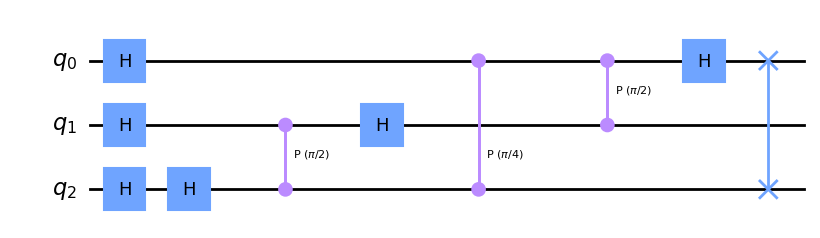

In [213]:
# 2. QFT 적용
qft_circuit = QFT(num_qubits=3).decompose()  # Create and decompose QFT for 2 qubits

psi_qft = psi.compose(qft_circuit)
psi_qft.draw('mpl')

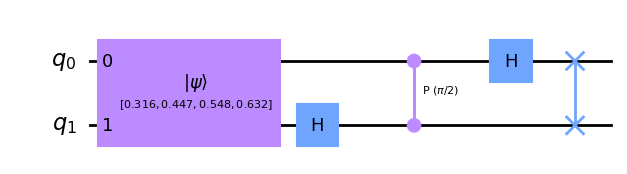

In [214]:
qft_circuit = QFT(num_qubits=2).decompose()
phi_qft = phi.compose(qft_circuit)
phi_qft.draw('mpl')

In [215]:
state_psi_qft = Statevector(psi_qft)
state_phi_qft = Statevector(phi_qft) 
print("|psi> = ", state_psi_qft)
print("|phi> = ", state_phi_qft)

|psi> =  Statevector([1.00000000e+00+0.00000000e+00j,
             1.55582133e-19+3.75608496e-19j,
             4.76210391e-18+4.76210391e-18j,
             1.55582133e-19+6.44442296e-20j,
             2.36158002e-17+0.00000000e+00j,
             1.55582133e-19-6.44442296e-20j,
             4.76210391e-18-4.76210391e-18j,
             1.55582133e-19-3.75608496e-19j],
            dims=(2, 2, 2))
|phi> =  Statevector([ 0.97180973+0.j        , -0.1157474 -0.09262097j,
             -0.1078594 +0.j        , -0.1157474 +0.09262097j],
            dims=(2, 2))


In [216]:
expanded_data = np.zeros(8, dtype=complex)  # 8개의 0 초기화
expanded_data[:4] = state_phi_qft.data  # 앞쪽 4개의 슬롯에 |phi> 값 복사

# 새로운 상태벡터 생성
phi_expanded = Statevector(expanded_data, dims=(2, 2, 2))

# 결과 출력
print("Expanded Statevector:")

print(phi_expanded)

Expanded Statevector:
Statevector([ 0.97180973+0.j        , -0.1157474 -0.09262097j,
             -0.1078594 +0.j        , -0.1157474 +0.09262097j,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ],
            dims=(2, 2, 2))


In [218]:
element_wise = state_psi_qft.data * phi_expanded.data
element_wise_result_state = Statevector(element_wise)

print("Element-wise product result = ", element_wise_result_state)
coeff = np.absolute(element_wise_result_state.data[0])
element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)

Element-wise product result =  Statevector([ 9.71809726e-01+0.00000000e+00j,
              1.67809958e-20-5.78858730e-20j,
             -5.13637680e-19-5.13637680e-19j,
             -2.39771137e-20+6.95091606e-21j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j],
            dims=(2, 2, 2))


In [219]:
# Statevector 객체 생성
element_wise_result_state = Statevector(element_wise_result_state, dims=(2, 2, 2))

# 앞 4개의 요소만 선택
trimmed_data = element_wise_result_state.data[:4]

# 새로운 2-qubit Statevector 생성
trimmed_state = Statevector(trimmed_data, dims=(2, 2))

# 결과 출력
print("Trimmed Statevector:")
print(trimmed_state)

Trimmed Statevector:
Statevector([ 1.00000000e+00+0.00000000e+00j,
              1.72677793e-20-5.95650275e-20j,
             -5.28537292e-19-5.28537292e-19j,
             -2.46726422e-20+7.15254837e-21j],
            dims=(2, 2))


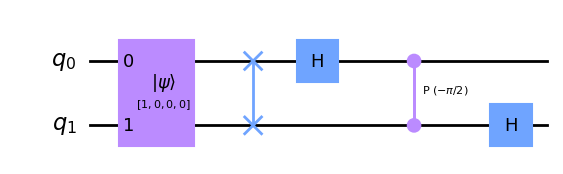

In [220]:
element_wise_result = QuantumCircuit(2)
element_wise_result.initialize(trimmed_state, [0,1,])
qft_circuit = QFT(num_qubits=2, inverse=True).decompose()
elemen_wise_result_qft = element_wise_result.compose(qft_circuit)
elemen_wise_result_qft.draw('mpl')

In [221]:
state_result_qft = Statevector(elemen_wise_result_qft)
state_result_qft = state_result_qft  * np.sqrt(2) * coeff
state_result_qft

Statevector([0.68717325-3.99213140e-19j, 0.68717325+3.34376351e-19j,
             0.68717325-3.27180233e-19j, 0.68717325+3.92017022e-19j],
            dims=(2, 2))


In [222]:
print( "Time domain convolution = ", result_state.data,"\n","Frequency domain multiplication = ",state_result_qft.data)

Time domain convolution =  [0.68717325+0.j 0.68717325+0.j 0.68717325+0.j 0.68717325+0.j] 
 Frequency domain multiplication =  [0.68717325-3.99213140e-19j 0.68717325+3.34376351e-19j
 0.68717325-3.27180233e-19j 0.68717325+3.92017022e-19j]


## Time Measurement

In [188]:
import time
import timeit
import cProfile

### Classical

In [4]:
def circular_convolution(x, y):
    L = len(y)  # y의 길이 (순환 주기)
    N = len(x)  # x의 길이
    z = np.zeros(N)  # 결과 배열 (x와 동일한 길이)
    
    for v in range(N):  # x의 각 요소에 대해
        for m in range(N):  # y를 순환적으로 접근
            z[v] += x[m] * y[(v - m) % L]  # 모듈로 연산으로 순환적 접근
    return z

In [183]:
# 순환 컨볼루션 계산
start = time.time()
psi_classic = np.array([1,1,1,1,1,1,1,1]) * (1/np.sqrt(8))
phi_classic = np.array([1,np.sqrt(2),np.sqrt(3),np.sqrt(4)]) * (1/np.sqrt(10))

z = circular_convolution(phi_classic,psi_classic)
end = time.time()

# 결과 출력
print("순환 컨볼루션 결과:")
print(z)
print(f"{end - start:.5f} sec")


순환 컨볼루션 결과:
[0.68717325 0.68717325 0.68717325 0.68717325]
0.00000 sec


In [185]:
code_to_test = """
psi_classic = np.array([1,1,1,1,1,1,1,1]) * (1/np.sqrt(8))
phi_classic = np.array([1,np.sqrt(2),np.sqrt(3),np.sqrt(4)]) * (1/np.sqrt(10))

z = circular_convolution(phi_classic,psi_classic)
"""

execution_time = timeit.timeit(code_to_test, globals=globals(), number=10000)
print(f"Execution time for 10,000 runs: {execution_time:.5f} seconds")

Execution time for 10,000 runs: 0.21080 seconds


In [ ]:
def calculate():
    psi_classic = np.array([1,1,1,1,1,1,1,1]) * (1/np.sqrt(8))
    phi_classic = np.array([1,np.sqrt(2),np.sqrt(3),np.sqrt(4)]) * (1/np.sqrt(10))

    z = circular_convolution(phi_classic,psi_classic)
    print(z)

cProfile.run("calculate()")

[0.68717325 0.68717325 0.68717325 0.68717325]
         185 function calls (181 primitive calls) in 0.001 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 1372850889.py:1(circular_convolution)
        1    0.000    0.000    0.001    0.001 323326338.py:3(calculate)
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 _ufunc_config.py:132(geterr)
        2    0.000    0.000    0.000    0.000 _ufunc_config.py:33(seterr)
        1    0.000    0.000    0.000    0.000 _ufunc_config.py:426(__init__)
        1    0.000    0.000    0.000    0.000 _ufunc_config.py:430(__enter__)
        1    0.000    0.000    0.000    0.000 _ufunc_config.py:435(__exit__)
        4    0.000    0.000    0.000    0.000 arrayprint.py:1018(__call__)
        1    0.000    0.000    0.000    0.000 arrayprint.py:1595(_array_str_implementation)
        1    

### Quantum circuit

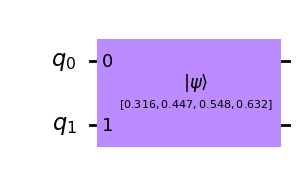

In [204]:
phi = QuantumCircuit(2)
initial_state = np.array([1,np.sqrt(2),np.sqrt(3),2]) * (1/np.sqrt(10))  # |00>, |01>, |10>, |11>에 대한 계수

# 2-큐빗 회로 생성
# 초기 상태 설정
phi.initialize(initial_state, [0, 1])
phi.draw('mpl')

In [ ]:
start = time.time()
# 1. 입력 신호 준비: 상태 |ψ⟩ = 1/sqrt(2)(|0⟩ + |1⟩), |φ⟩ = 1/2(sqrt(3)|0⟩ + |1⟩)
psi = QuantumCircuit(3)
phi = QuantumCircuit(2)

# |ψ⟩ 상태
psi.h(range(0,3))  # First qubit

# |φ⟩ 상태
initial_state = np.array([1,np.sqrt(2),np.sqrt(3),2]) * (1/np.sqrt(10))

# 2-큐빗 회로 생성
# 초기 상태 설정
phi.initialize(initial_state, [0, 1])

# 2. QFT 적용
qft_circuit = QFT(num_qubits=3).decompose()  # Create and decompose QFT for 2 qubits
psi_qft = psi.compose(qft_circuit)

qft_circuit = QFT(num_qubits=2).decompose()
phi_qft = phi.compose(qft_circuit)

state_psi_qft = Statevector(psi_qft)
state_phi_qft = Statevector(phi_qft) 

expanded_data = np.zeros(8, dtype=complex)  # 8개의 0 초기화
expanded_data[:4] = state_phi_qft.data  # 앞쪽 4개의 슬롯에 |phi> 값 복사

# 새로운 상태벡터 생성
phi_expanded = Statevector(expanded_data, dims=(2, 2, 2))

element_wise = state_psi_qft.data * phi_expanded.data
element_wise_result_state = Statevector(element_wise)

#print("Element-wise product result = ", element_wise_result_state)
coeff = np.absolute(element_wise_result_state.data[0])
element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)

# Statevector 객체 생성
element_wise_result_state = Statevector(element_wise_result_state, dims=(2, 2, 2))

# 앞 4개의 요소만 선택
trimmed_data = element_wise_result_state.data[:4]

# 새로운 2-qubit Statevector 생성
trimmed_state = Statevector(trimmed_data, dims=(2, 2))

element_wise_result = QuantumCircuit(2)
element_wise_result.initialize(trimmed_state, [0,1,])
elemen_wise_result_qft = element_wise_result.compose(qft_circuit)

state_result_qft = Statevector(elemen_wise_result_qft)
state_result_qft = state_result_qft  * np.sqrt(2) * coeff

end = time.time()
print("Frequency domain multiplication = ",state_result_qft.data)
print(f"{end - start:.5f} sec")

Frequency domain multiplication =  [0.68717325-3.99213140e-19j 0.68717325+3.92017022e-19j
 0.68717325-3.27180233e-19j 0.68717325+3.34376351e-19j]
0.00898 sec


In [206]:
code_to_test = """
psi = QuantumCircuit(3)
phi = QuantumCircuit(2)

# |ψ⟩ 상태
psi.h(range(0,3))  # First qubit

# |φ⟩ 상태
initial_state = np.array([1,np.sqrt(2),np.sqrt(3),2]) * (1/np.sqrt(10))

# 2-큐빗 회로 생성
# 초기 상태 설정
phi.initialize(initial_state, [0, 1])

# 2. QFT 적용
qft_circuit = QFT(num_qubits=3).decompose()  # Create and decompose QFT for 2 qubits
psi_qft = psi.compose(qft_circuit)

qft_circuit = QFT(num_qubits=2).decompose()
phi_qft = phi.compose(qft_circuit)

state_psi_qft = Statevector(psi_qft)
state_phi_qft = Statevector(phi_qft) 

expanded_data = np.zeros(8, dtype=complex)  # 8개의 0 초기화
expanded_data[:4] = state_phi_qft.data  # 앞쪽 4개의 슬롯에 |phi> 값 복사

# 새로운 상태벡터 생성
phi_expanded = Statevector(expanded_data, dims=(2, 2, 2))

element_wise = state_psi_qft.data * phi_expanded.data
element_wise_result_state = Statevector(element_wise)

#print("Element-wise product result = ", element_wise_result_state)
coeff = np.absolute(element_wise_result_state.data[0])
element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)

# Statevector 객체 생성
element_wise_result_state = Statevector(element_wise_result_state, dims=(2, 2, 2))

# 앞 4개의 요소만 선택
trimmed_data = element_wise_result_state.data[:4]

# 새로운 2-qubit Statevector 생성
trimmed_state = Statevector(trimmed_data, dims=(2, 2))

element_wise_result = QuantumCircuit(2)
element_wise_result.initialize(trimmed_state, [0,1,])
elemen_wise_result_qft = element_wise_result.compose(qft_circuit)

state_result_qft = Statevector(elemen_wise_result_qft)
state_result_qft = state_result_qft  * np.sqrt(2) * coeff
"""

execution_time = timeit.timeit(code_to_test, globals=globals(), number=10000)
print(f"Execution time for 10,000 runs: {execution_time:.5f} seconds")

Execution time for 10,000 runs: 44.98073 seconds


In [208]:
def calculate():
    psi = QuantumCircuit(3)
    phi = QuantumCircuit(2)

    # |ψ⟩ 상태
    psi.h(range(0,3))  # First qubit

    # |φ⟩ 상태
    initial_state = np.array([1,np.sqrt(2),np.sqrt(3),2]) * (1/np.sqrt(10))

    # 2-큐빗 회로 생성
    # 초기 상태 설정
    phi.initialize(initial_state, [0, 1])

    # 2. QFT 적용
    qft_circuit = QFT(num_qubits=3).decompose()  # Create and decompose QFT for 2 qubits
    psi_qft = psi.compose(qft_circuit)

    qft_circuit = QFT(num_qubits=2).decompose()
    phi_qft = phi.compose(qft_circuit)

    state_psi_qft = Statevector(psi_qft)
    state_phi_qft = Statevector(phi_qft) 

    expanded_data = np.zeros(8, dtype=complex)  # 8개의 0 초기화
    expanded_data[:4] = state_phi_qft.data  # 앞쪽 4개의 슬롯에 |phi> 값 복사

    # 새로운 상태벡터 생성
    phi_expanded = Statevector(expanded_data, dims=(2, 2, 2))

    element_wise = state_psi_qft.data * phi_expanded.data
    element_wise_result_state = Statevector(element_wise)

    #print("Element-wise product result = ", element_wise_result_state)
    coeff = np.absolute(element_wise_result_state.data[0])
    element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)

    # Statevector 객체 생성
    element_wise_result_state = Statevector(element_wise_result_state, dims=(2, 2, 2))

    # 앞 4개의 요소만 선택
    trimmed_data = element_wise_result_state.data[:4]

    # 새로운 2-qubit Statevector 생성
    trimmed_state = Statevector(trimmed_data, dims=(2, 2))

    element_wise_result = QuantumCircuit(2)
    element_wise_result.initialize(trimmed_state, [0,1,])
    elemen_wise_result_qft = element_wise_result.compose(qft_circuit)

    state_result_qft = Statevector(elemen_wise_result_qft)
    state_result_qft = state_result_qft  * np.sqrt(2) * coeff

    print("Frequency domain multiplication = ",state_result_qft.data)

cProfile.run("calculate()")

Frequency domain multiplication =  [0.68717325-3.99213140e-19j 0.68717325+3.92017022e-19j
 0.68717325-3.27180233e-19j 0.68717325+3.34376351e-19j]
         14018 function calls (13530 primitive calls) in 0.018 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.018    0.018 3831187040.py:1(calculate)
       10    0.000    0.000    0.000    0.000 <frozen _collections_abc>:812(__init__)
      266    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
       44    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1101(_sanity_check)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1165(_find_and_load)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1192(_gcd_import)
       25    0.000    0.000    0.000    0.000 <frozen importlib._boots

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
import numpy as np

# 초기 상태 |psi>와 |phi>
psi = [1/np.sqrt(2), 1/np.sqrt(2)]  # |psi> = 1/sqrt(2) * (|0> + |1>)
phi = [1/2, np.sqrt(3)/2,1/2]           # |phi> = 1/2 * |0> + sqrt(3)/2 * |1>

# Qiskit Statevector로 변환
state_psi = Statevector(psi)
state_phi = Statevector(phi)

# 두 상태를 병합 (텐서곱)
combined_state = state_psi.tensor(state_phi)

# QFT 적용을 위한 회로 생성
num_qubits = int(np.log2(len(combined_state.data)))  # 병합된 상태의 전체 퀴빗 수
qft_circuit = QFT(num_qubits, do_swaps=False)        # QFT 회로 생성

# QFT 적용
qft_result = combined_state.evolve(qft_circuit)

# QFT 결과에서 element-wise multiplication 수행
elementwise_product = qft_result.data * qft_result.data  # 두 상태를 성분별 곱셈

# 결과를 새로운 Statevector로 변환
result_state = Statevector(elementwise_product)

# 결과 출력
print("Element-wise multiplication after QFT:")
print("Statevector:", result_state)


Element-wise multiplication after QFT:
Statevector: Statevector([ 9.33012702e-01+0.00000000e+00j,
              6.69872981e-02+0.00000000e+00j,
             -5.50479898e-35+4.33518933e-35j,
             -5.50479898e-35-4.33518933e-35j],
            dims=(2, 2))


In [ ]:
# 순환 컨볼루션 계산
z = circular_convolution(psi_real, phi_real)

# 결과 출력
print("순환 컨볼루션 결과:")
print(z)


In [7]:
image = np.array([0,1,0,0,1,0])
filter = np.array([0,1,0,1])
circular_convolution(image,filter)

array([1., 1., 1., 1., 1., 1.])

In [16]:
circular_convolution(filter,image)

array([0., 1., 1., 0.])

In [15]:
np.convolve(image,filter)

array([0, 0, 1, 0, 1, 1, 0, 1, 0])

In [13]:
image.reshape(-1,3)
filter.reshape(-1,2)

array([[0, 1],
       [0, 1]])

In [9]:
import scipy
from scipy import signal
from scipy.signal import convolve2d

convolve2d(image,filter)

ValueError: convolve2d inputs must both be 2-D arrays

In [2]:
import numpy as np

# Input image and filter
I = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
F = np.array([[1, 0],
              [0, 1]])

# Flatten input and filter
I_flat = I.flatten()
F_flat = F.flatten()

# Compute 1D convolution
window_size = F_flat.size
output_1d = np.array([
    np.sum(I_flat[i:i+window_size] * F_flat)
    for i in range(len(I_flat) - window_size + 1)
])

# Correctly reshape 1D output to match the 2D output shape
output_2d_shape = (I.shape[0] - F.shape[0] + 1, I.shape[1] - F.shape[1] + 1)  # (2, 2)
output_2d = output_1d[:np.prod(output_2d_shape)].reshape(output_2d_shape)

print("1D Output:", output_1d)
print("2D Output:\n", output_2d)


1D Output: [ 5  7  9 11 13 15]
2D Output:
 [[ 5  7]
 [ 9 11]]


In [7]:
I.shape

(3, 3)

In [5]:
I_flat

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
for i in range(len(I_flat) - window_size + 1):
    print(i)

0
1
2
3
4
5


In [4]:
window_size

4

In [3]:
output_1d

array([ 5,  7,  9, 11, 13, 15])

In [56]:
import numpy as np

def sliding_window_1d(image, filter_size):
    """Generates a sliding window matrix for the given image and filter size."""
    n = image.shape[0]
    k = filter_size
    output_size = (n - k + 1) ** 2
    patch_size = k * k

    # Generate sliding window patches
    patches = []
    for i in range(n - k + 1):
        for j in range(n - k + 1):
            patch = image[i:i+k, j:j+k].flatten()
            patches.append(patch)
    return np.array(patches)

def flatten_1d_convolution(image, kernel):
    """Computes 1D convolution equivalent to 2D convolution."""
    # Extract sliding window patches
    patches = sliding_window_1d(image, kernel.shape[0])
    kernel_flat = kernel.flatten()

    # Compute dot product for 1D convolution
    result = patches @ kernel_flat
    output_size = (image.shape[0] - kernel.shape[0] + 1, 
                   image.shape[1] - kernel.shape[1] + 1)
    return result.reshape(output_size)

# Input 2D image and kernel
image = np.array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])
kernel = np.array([[1, 0],
                   [0, 1]])

# Perform 1D convolution
output = flatten_1d_convolution(image, kernel)
print("2D Convolution result using 1D approach:\n", output)


2D Convolution result using 1D approach:
 [[ 6  8]
 [12 14]]


In [57]:
filter_flat = filter.flatten()
filter_flat
for i, coeff in enumerate(filter_flat):

    print(int(np.floor(np.sqrt(i))))

0
1
1
1


In [58]:
image.size

9

In [59]:
from qiskit import QuantumCircuit, Aer, execute
import numpy as np

def encode_image(qc, image):
    """Encodes the image into quantum amplitudes."""
    n = image.size
    norm = np.linalg.norm(image)
    normalized = image.flatten() / norm
    qc.initialize(normalized, range(int(np.log2(n))))

def apply_filter(qc, filter, image_size):
    """Applies a quantum filter operation by mapping filter values to states."""
    # Flatten and normalize filter (optional, if normalization is required)
    filter_flat = filter.flatten()
    
    # Apply RY rotations corresponding to the filter coefficients
    n_states = image_size**2  # Number of states
    for i, coeff in enumerate(filter_flat):
        if coeff != 0:
            angle = 2 * np.arcsin(coeff)  # Map filter value to rotation angle
            qc.ry(angle, int(np.floor(np.sqrt(i)))) # Apply rotation to the corresponding state

# Define 2x2 image and 2x2 filter
image = np.array([[1, 2],
                  [3, 4]])
filter = np.array([[1, 0],
                   [0, -1]])

# Quantum circuit setup  
n_qubits = int(np.log2(image.size))  # 2 qubits for 2x2 image
qc = QuantumCircuit(n_qubits)

# Encode image and apply filter
encode_image(qc, image)
apply_filter(qc, filter, image.size)

# Display circuit
print("Quantum Circuit:")
print(qc)


Quantum Circuit:
     ┌─────────────────────────────────────────────┐┌───────┐ 
q_0: ┤0                                            ├┤ Ry(π) ├─
     │  Initialize(0.18257,0.36515,0.54772,0.7303) │├───────┴┐
q_1: ┤1                                            ├┤ Ry(-π) ├
     └─────────────────────────────────────────────┘└────────┘


C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


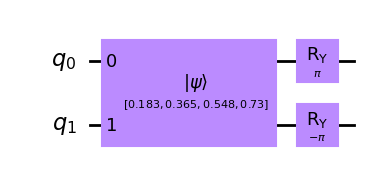

In [60]:
qc.draw('mpl')

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Statevector

# Define 2D input and filter
image = np.array([[1, 2], [3, 4]])
filter_ = np.array([[1, 0], [0, -1]])

# Flatten the 2D arrays to 1D
image_flattened = image.flatten()
filter_flattened = filter_.flatten()

# Normalize for amplitude encoding
image_norm = image_flattened / np.linalg.norm(image_flattened)
filter_norm = filter_flattened / np.linalg.norm(filter_flattened)

# Create Quantum Circuit
n_qubits = int(np.ceil(np.log2(len(image_flattened))))
qc = QuantumCircuit(n_qubits)

# Amplitude encoding
def amplitude_encoding(qc, data):
    for i, amp in enumerate(data):
        if amp != 0:
            angle = 2 * np.arcsin(np.sqrt(abs(amp)))
            qc.ry(angle, i)

# Apply QFT
def qft(qc, n):
    for i in range(n):
        qc.h(i)
        for j in range(i + 1, n):
            qc.cp(np.pi / 2 ** (j - i), j, i)

# Apply IQFT
def iqft(qc, n):
    for i in range(n - 1, -1, -1):
        for j in range(i + 1, n):
            qc.cp(-np.pi / 2 ** (j - i), j, i)
        qc.h(i)

# Initialize and encode data
amplitude_encoding(qc, image_norm)
qft(qc, n_qubits)

# Apply filter in Fourier space
for i, coeff in enumerate(filter_norm):
    if coeff != 0:
        qc.ry(2 * np.arcsin(coeff), i)

# Inverse QFT
iqft(qc, n_qubits)

# Simulate and measure
simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, simulator).result()
state = Statevector(result.get_statevector(qc))

print("Resulting statevector (amplitude encoded convolution result):")
print(state)


CircuitError: 'Index 2 out of range for size 2.'

In [61]:
import numpy as np

# Original data
I = np.array([1, 2, 3, 4])
K = np.array([1, 0, 0, -1])

# Create masks for non-negative indices
mask = np.array([1 if n >= 0 else 0 for n in range(len(I))])

# Apply the mask to ignore negative indices
I_masked = I * mask
K_masked = K * mask

# Compute FT and IFT
FT_I = np.fft.fft(I_masked)
FT_K = np.fft.fft(K_masked)

# Convolution using FT
result = np.fft.ifft(FT_I * FT_K)

print("Convolution result:", result.real)


Convolution result: [-1. -1. -1.  3.]


# 2D image Convolution 비교

In [66]:
import numpy as np

# Define a 2x2 input matrix
image = np.array([[1, 2],
                  [3, 4]])
filter=  np.array([[1,0],
                   [0,-1]])
# 2D Fourier Transform using numpy
ft_2d = np.fft.fft2(image)
ft_filter = np.fft.fft2(filter)

# Print the result
print("Original Image:")
print(image)

print("\n2D Fourier Transform:")
print(ft_2d)


print("Original Image:")
print(filter)

print("\n2D Fourier Transform:")
print(ft_filter)

Original Image:
[[1 2]
 [3 4]]

2D Fourier Transform:
[[10.+0.j -2.+0.j]
 [-4.+0.j  0.+0.j]]
Original Image:
[[ 1  0]
 [ 0 -1]]

2D Fourier Transform:
[[0.+0.j 2.+0.j]
 [2.+0.j 0.+0.j]]


In [68]:
# Element-wise multiplication in the Fourier domain
ft_result = ft_2d * ft_filter

# Inverse Fourier Transform to get the result back to spatial domain
result = np.fft.ifft2(ft_result)
result

array([[-3.+0.j, -1.+0.j],
       [ 1.+0.j,  3.+0.j]])

In [71]:
import numpy as np

def circular_convolution_2d(image, kernel):
    """
    2D 순환 컨볼루션을 수행하는 함수
    :param image: 2D 입력 이미지 (numpy array)
    :param kernel: 2D 커널 (numpy array)
    :return: 2D 순환 컨볼루션 결과 (numpy array)
    """
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape

    # 결과 배열 초기화
    result = np.zeros_like(image, dtype=float)

    # 순환적 컨볼루션 수행
    for i in range(image_h):
        for j in range(image_w):
            for m in range(kernel_h):
                for n in range(kernel_w):
                    # 순환적으로 인덱스 접근
                    image_row = (i - m) % image_h
                    image_col = (j - n) % image_w
                    result[i, j] += image[image_row, image_col] * kernel[m, n]
    
    return result


In [72]:
circular_convolution_2d(image, filter)

array([[-3., -1.],
       [ 1.,  3.]])

## 2D image convolution with quantum circuit

In [15]:
# 1. 입력 신호 준비: 상태 |ψ⟩ = 1/sqrt(2)(|0⟩ + |1⟩), |φ⟩ = 1/2(sqrt(3)|0⟩ + |1⟩)
psi = QuantumCircuit(2)
phi = QuantumCircuit(2)

# |ψ⟩ 상태
initial_psi_state = np.array([1,2,3,4]) * (1/np.sqrt(30))

# |φ⟩ 상태
initial_phi_state = np.array([1,0,0,-1]) * (1/np.sqrt(2))

psi.initialize(initial_psi_state,[0,1])
phi.initialize(initial_phi_state, [0, 1])

In [16]:
state_psi = Statevector(phi)
state_phi = Statevector(psi)

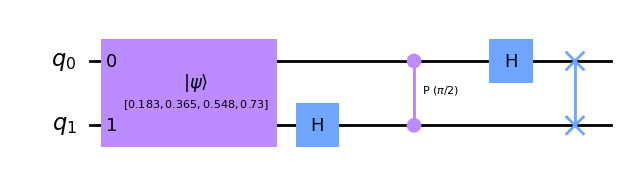

In [17]:
# 2. QFT 적용
qft_circuit = QFT(num_qubits=2).decompose()  # Create and decompose QFT for 2 qubits

psi_qft = psi.compose(qft_circuit)
phi_qft = phi.compose(qft_circuit)
psi_qft.draw('mpl')

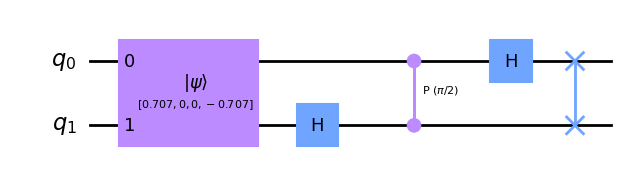

In [18]:
phi_qft.draw('mpl')

In [19]:
state_psi_qft = Statevector(psi_qft)
state_phi_qft = Statevector(phi_qft)
print(state_psi_qft)
print(state_phi_qft)

Statevector([ 0.91287093+0.j        , -0.18257419-0.18257419j,
             -0.18257419+0.j        , -0.18257419+0.18257419j],
            dims=(2, 2))
Statevector([2.29934717e-17+0.j        , 3.53553391e-01+0.35355339j,
             7.07106781e-01+0.j        , 3.53553391e-01-0.35355339j],
            dims=(2, 2))


In [152]:
element_wise = state_psi_qft.data * state_phi_qft.data
element_wise_state = Statevector(element_wise)
print("Element-wise multiplication result = ","\n",element_wise_state)
# element-wise 곱셈 결과 크기가 1이 아니므로 정규화
element_wise_state_norm = element_wise_state / np.linalg.norm(element_wise_state.data)
print("Normalized element-wise multiplication = ","\n",element_wise_state_norm)

Element-wise multiplication result =  
 Statevector([ 2.09900719e-17+0.j        , -4.46641670e-18-0.12909944j,
             -1.29099445e-01+0.j        , -4.46641670e-18+0.12909944j],
            dims=(2, 2))
Normalized element-wise multiplication =  
 Statevector([ 9.38704551e-17+0.j        , -1.99744227e-17-0.57735027j,
             -5.77350269e-01+0.j        , -1.99744227e-17+0.57735027j],
            dims=(2, 2))


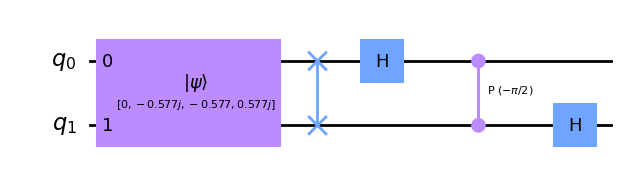

In [153]:
element_wise_qc = QuantumCircuit(2)
element_wise_qc.initialize(element_wise_state_norm)
iqft_circuit=QFT(num_qubits=2, inverse=True).decompose()
element_wise_qc_iqft = element_wise_qc.compose(iqft_circuit)
element_wise_qc_iqft.draw('mpl')

In [158]:
element_wise_qc_iqft_state = Statevector(element_wise_qc_iqft)
element_wise_qc_iqft_state

Statevector([-0.28867513-3.67503113e-18j, -0.28867513-3.53525080e-17j,
             -0.28867513+3.67503113e-18j,  0.8660254 +3.53525080e-17j],
            dims=(2, 2))


In [165]:
iqft_elementwise_state = Statevector(element_wise_qc_iqft)
iqft_elementwise_state = iqft_elementwise_state / np.sqrt(5)
print("Frequency domain multiplication = ","\n",iqft_elementwise_state.data)

Frequency domain multiplication =  
 [-0.12909944-1.64352388e-18j -0.12909944-1.58101222e-17j
 -0.12909944+1.64352388e-18j  0.38729833+1.58101222e-17j]


In [155]:
circular_convolution(initial_psi_state, initial_phi_state)

array([-0.12909944, -0.12909944, -0.12909944,  0.38729833])

# 2D Convolution 

In [5]:
def circular_convolution_2d(image, kernel):
    """
    2D 순환 컨볼루션을 수행하는 함수
    :param image: 2D 입력 이미지 (numpy array)
    :param kernel: 2D 커널 (numpy array)
    :return: 2D 순환 컨볼루션 결과 (numpy array)
    """
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape

    # 결과 배열 초기화
    result = np.zeros_like(image, dtype=float)

    # 순환적 컨볼루션 수행
    for i in range(image_h):
        for j in range(image_w):
            for m in range(kernel_h):
                for n in range(kernel_w):
                    # 순환적으로 인덱스 접근
                    image_row = (i - m) % image_h
                    image_col = (j - n) % image_w
                    result[i, j] += image[image_row, image_col] * kernel[m, n]

    return result

In [6]:
image = np.array([[1, 2],
                  [3, 4]])
filter=  np.array([[1,0],
                   [0,-1]])
circular_convolution_2d(image, filter)

array([[-3., -1.],
       [ 1.,  3.]])

State  = Statevector([ 9.12870929e-01+0.j, -1.82574186e-01+0.j, -3.65148372e-01+0.j,
             -1.72086422e-17+0.j],
            dims=(2, 2))


C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


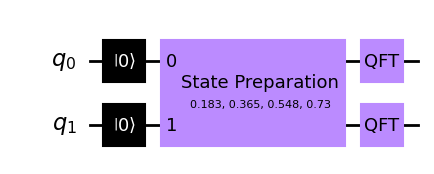

In [7]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# 데이터 정의

amplitudes = image.flatten() / np.sqrt(np.sum(image**2))  # 진폭 정규화

# 큐빗 수 설정
num_qubits = 2  # 2x2 데이터에 필요한 큐빗 수 (2개의 큐빗으로 |i, j> 상태 표현)

# 양자 회로 초기화
psi = QuantumCircuit(num_qubits)

# 진폭 인코딩
psi.initialize(amplitudes, range(num_qubits))

# 2D QFT 수행
# 행(row)에 대해 QFT 적용 (첫 번째 큐빗)
psi.append(QFT(1).to_gate(), [0])
# 열(column)에 대해 QFT 적용 (두 번째 큐빗)
psi.append(QFT(1).to_gate(), [1])

state_psi  = Statevector(psi)
print("State  =",state_psi )
decomposed_qc = psi.decompose()
decomposed_qc.draw('mpl')

State  = Statevector([2.29934717e-17+0.j, 7.07106781e-01+0.j, 7.07106781e-01+0.j,
             2.29934717e-17+0.j],
            dims=(2, 2))


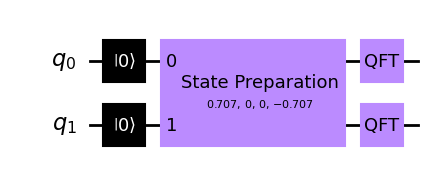

In [8]:
amplitudes_filter = filter.flatten() / np.sqrt(np.sum(filter**2))  # 진폭 정규화

# 큐빗 수 설정
num_qubits = 2  # 2x2 데이터에 필요한 큐빗 수 (2개의 큐빗으로 |i, j> 상태 표현)

# 양자 회로 초기화
phi = QuantumCircuit(num_qubits)

# 진폭 인코딩
phi.initialize(amplitudes_filter, range(num_qubits))

# 2D QFT 수행
# 행(row)에 대해 QFT 적용 (첫 번째 큐빗)
phi.append(QFT(1).to_gate(), [0])
# 열(column)에 대해 QFT 적용 (두 번째 큐빗)
phi.append(QFT(1).to_gate(), [1])

state_phi = Statevector(phi)
print("State  =",state_phi)
decomposed_qc_filter = phi.decompose()
decomposed_qc_filter.draw('mpl')

In [10]:
state_psi_qft = Statevector(psi)
state_phi_qft = Statevector(phi)
print(state_psi_qft)
print(state_phi_qft)

element_wise = state_psi_qft.data * state_phi_qft.data
element_wise_state = Statevector(element_wise)
print("Element-wise multiplication result = ","\n",element_wise_state)
# element-wise 곱셈 결과 크기가 1이 아니므로 정규화
element_wise_state_norm = element_wise_state / np.linalg.norm(element_wise_state.data)
print("Normalized element-wise multiplication = ","\n",element_wise_state_norm)

Statevector([ 9.12870929e-01+0.j, -1.82574186e-01+0.j, -3.65148372e-01+0.j,
             -1.72086422e-17+0.j],
            dims=(2, 2))
Statevector([2.29934717e-17+0.j, 7.07106781e-01+0.j, 7.07106781e-01+0.j,
             2.29934717e-17+0.j],
            dims=(2, 2))
Element-wise multiplication result =  
 Statevector([ 2.09900719e-17+0.j, -1.29099445e-01+0.j, -2.58198890e-01+0.j,
             -3.95686427e-34+0.j],
            dims=(2, 2))
Normalized element-wise multiplication =  
 Statevector([ 7.27117419e-17+0.j, -4.47213595e-01+0.j, -8.94427191e-01+0.j,
             -1.37069799e-33+0.j],
            dims=(2, 2))


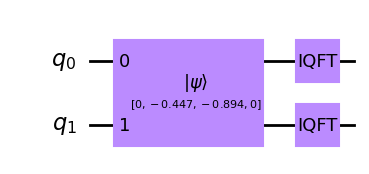

In [11]:
element_wise_qc = QuantumCircuit(2)
element_wise_qc.initialize(element_wise_state_norm)
element_wise_qc.append(QFT(1, inverse=True).to_gate(), [1])
element_wise_qc.append(QFT(1, inverse=True).to_gate(), [0])

element_wise_qc.draw('mpl')

In [13]:
element_wise_qc_iqft_state = Statevector(element_wise_qc)
print(element_wise_qc_iqft_state)
iqft_elementwise_state = Statevector(element_wise_qc)
#iqft_elementwise_state = iqft_elementwise_state / np.sqrt(5)
iqft_elementwise_state = iqft_elementwise_state * 10 / np.sqrt(5)
print("Frequency domain multiplication = ","\n",iqft_elementwise_state.data)

Statevector([-0.67082039+0.j, -0.2236068 +0.j,  0.2236068 +0.j,
              0.67082039+0.j],
            dims=(2, 2))
Frequency domain multiplication =  
 [-3.+0.j -1.+0.j  1.+0.j  3.+0.j]


# 2D Convolution with 3 X 3 Image and 2 X 2 Kernel

In [20]:
def circular_convolution_2d(image, kernel):
    """
    2D 순환 컨볼루션을 수행하는 함수
    :param image: 2D 입력 이미지 (numpy array)
    :param kernel: 2D 커널 (numpy array)
    :return: 2D 순환 컨볼루션 결과 (numpy array)
    """
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape

    # 결과 배열 초기화
    result = np.zeros_like(image, dtype=float)

    # 순환적 컨볼루션 수행
    for i in range(image_h):
        for j in range(image_w):
            for m in range(kernel_h):
                for n in range(kernel_w):
                    # 순환적으로 인덱스 접근
                    image_row = (i - m) % image_h
                    image_col = (j - n) % image_w
                    result[i, j] += image[image_row, image_col] * kernel[m, n]

    return result

In [22]:
image = np.array([[1,2,3],[4,5,6],[7,8,9]])
circular_convolution_2d(image,filter)

array([[-8., -5., -5.],
       [ 1.,  4.,  4.],
       [ 1.,  4.,  4.]])

# Quantum Fast Fourier Transform

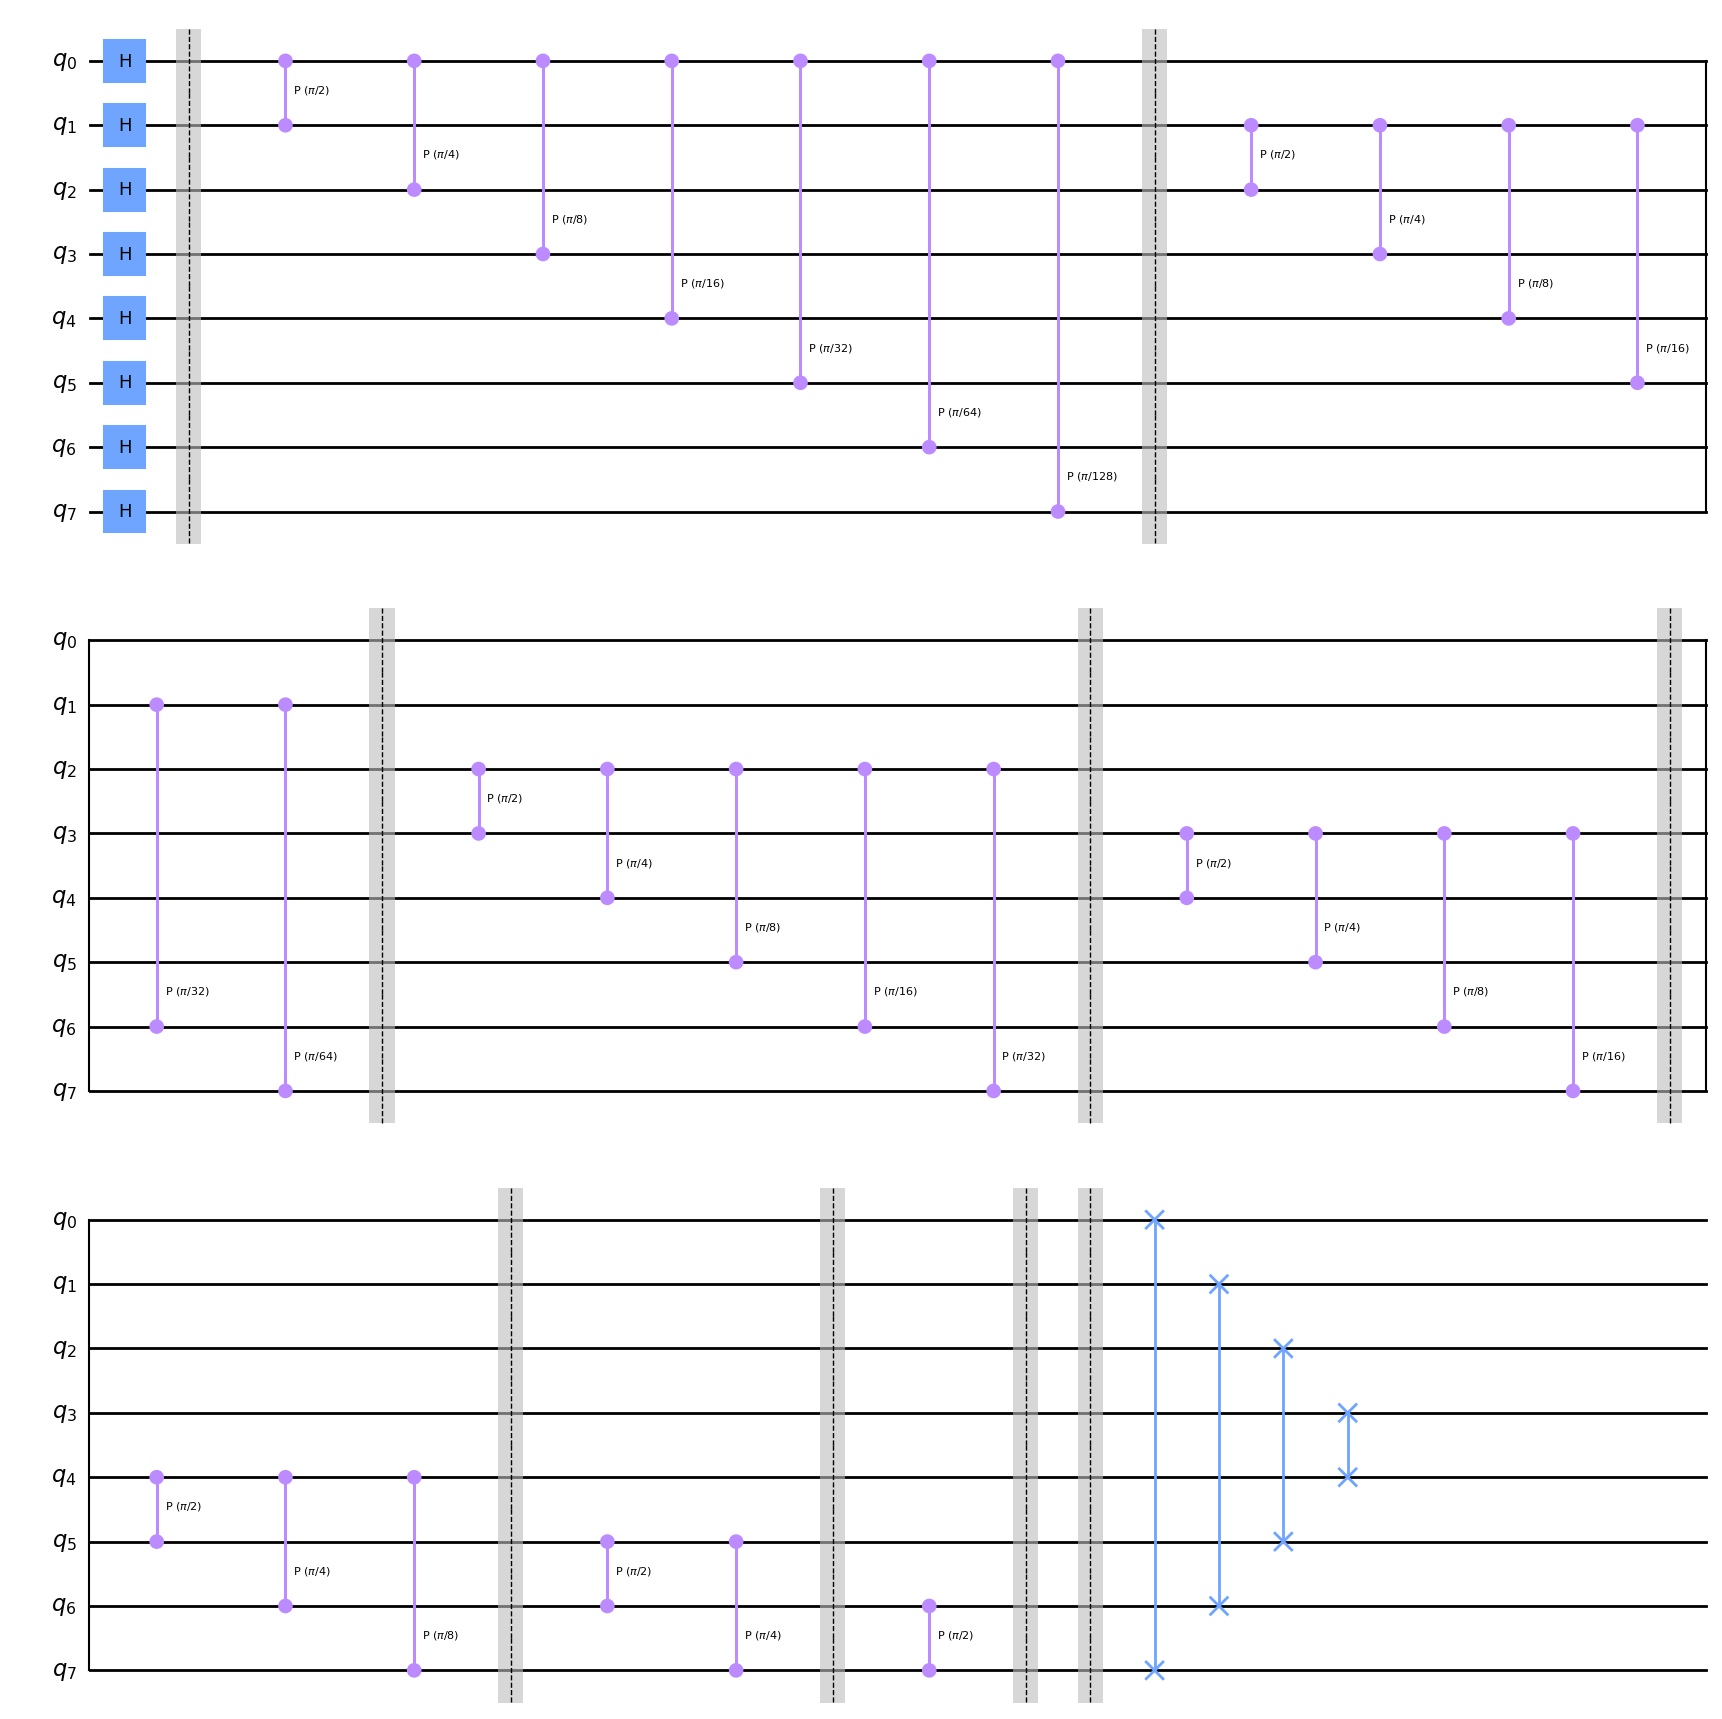

In [6]:
from qiskit import QuantumCircuit
import numpy as np

def quantum_fft(n):
    qc = QuantumCircuit(n)
    
    # 모든 큐비트에 Hadamard 게이트 적용
    for i in range(n):
        qc.h(i)
    qc.barrier()
    # 제어 위상 회전 게이트 적용
    for i in range(n):
        for j in range(i+1, n):
            qc.cp(np.pi / (2**(j-i)), j, i)
        qc.barrier()
    # 큐비트 순서 뒤집기
    for i in range(n//2):
        qc.swap(i, n-i-1)

    return qc

# 예시: 3 큐비트 QFFT 회로 생성
n_qubits = 8
qfft_circuit = quantum_fft(n_qubits)

# 회로 출력
qfft_circuit.draw('mpl')


{'000': 490, '100': 534}


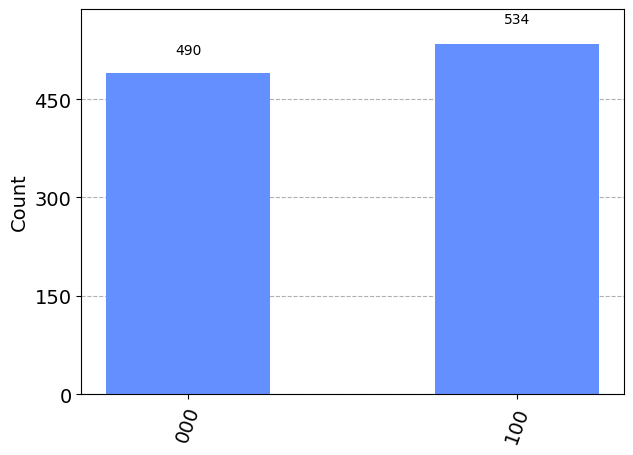

In [8]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
import numpy as np

# 버터플라이 연산 구현
def butterfly(qc, control, target, k):
    """ 버터플라이 연산: 제어 회전과 스왑 """
    # 제어 회전
    qc.cp(np.pi / (2 ** k), control, target)
    # 스왑 게이트
    qc.swap(control, target)

# FFT 회로 구현
def quantum_fft(n):
    qc = QuantumCircuit(n)
    
    # 버터플라이 구조 적용
    for i in range(n):
        qc.h(i)
        for j in range(i+1, n):
            butterfly(qc, control=n-j-1, target=n-i-1, k=j-i)
    
    # 스왑으로 출력 순서 뒤집기
    for i in range(n//2):
        qc.swap(i, n-i-1)
        
    return qc

# 3-큐빗 FFT 구현
n_qubits = 3
qc = quantum_fft(n_qubits)
qc.measure_all()

# 시뮬레이터 실행
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
job = execute(compiled_circuit, backend=simulator, shots=1024)
result = job.result()
counts = result.get_counts()

# 결과 출력
print(counts)
plot_histogram(counts)


C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


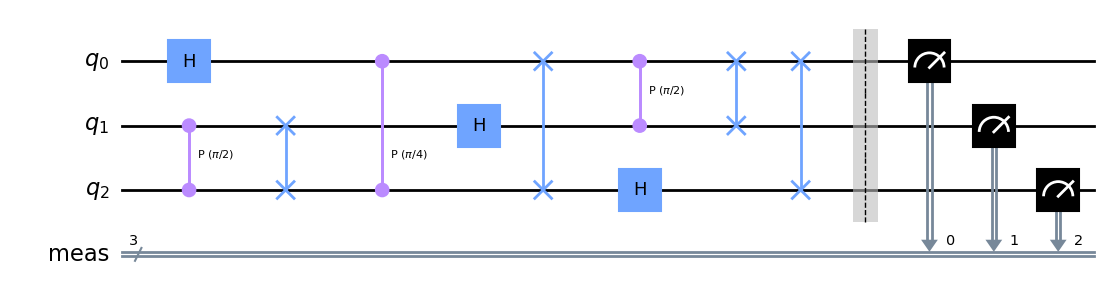

In [9]:
qc.draw('mpl')

                                             ┌───┐    ░ ┌─┐      
   q_0: ────────────────────■────────■───────┤ H ├─X──░─┤M├──────
                      ┌───┐ │        │P(π/2) └───┘ │  ░ └╥┘┌─┐   
   q_1: ──────■───────┤ H ├─┼────────■─────────────┼──░──╫─┤M├───
        ┌───┐ │P(π/2) └───┘ │P(π/4)                │  ░  ║ └╥┘┌─┐
   q_2: ┤ H ├─■─────────────■──────────────────────X──░──╫──╫─┤M├
        └───┘                                         ░  ║  ║ └╥┘
meas: 3/═════════════════════════════════════════════════╩══╩══╩═
                                                         0  1  2 
QFT Result: {'000': 25285, '011': 25011, '010': 25022, '111': 24971, '101': 24861, '001': 25089, '110': 24838, '100': 24923}


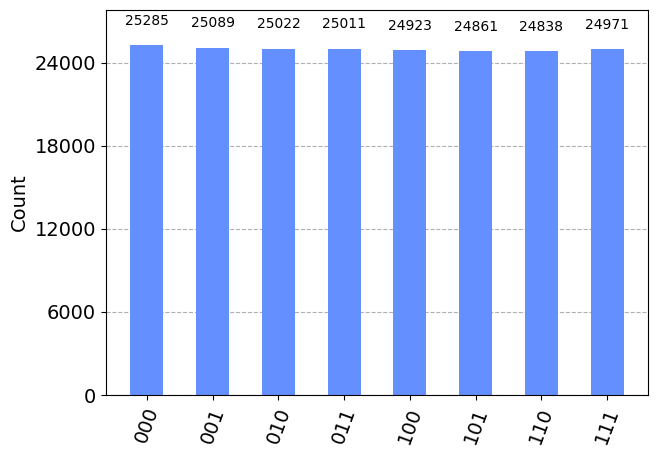

In [21]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram

# 3-큐빗 QFT 회로 생성
n_qubits = 3
qft_circuit = QFT(num_qubits=n_qubits, do_swaps=True).decompose()  # do_swaps=True: 출력 순서 자동으로 뒤집음
qft_circuit.measure_all()

# 회로 확인
print(qft_circuit.draw('text'))

# 시뮬레이터 실행
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qft_circuit, simulator)
job = execute(compiled_circuit, backend=simulator, shots=200000)
result = job.result()
counts = result.get_counts()

# 결과 출력
print("QFT Result:", counts)
plot_histogram(counts)


        ┌───┐              ░ ┌─┐   
   q_0: ┤ H ├─■─────────X──░─┤M├───
        ├───┤ │P(-π/2)  │  ░ └╥┘┌─┐
   q_1: ┤ H ├─■─────────X──░──╫─┤M├
        └───┘              ░  ║ └╥┘
meas: 2/══════════════════════╩══╩═
                              0  1 
Butterfly Quantum Result: {'10': 243, '11': 277, '00': 265, '01': 239}


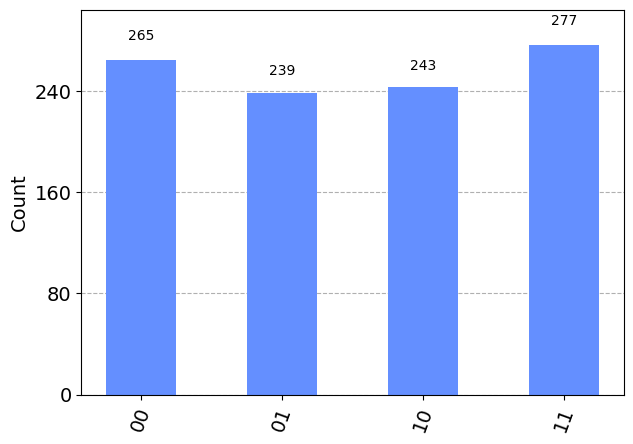

In [22]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
import numpy as np

# 버터플라이 연산 (제어 회전 + 스왑)
def butterfly(qc, control, target, k):
    """ 버터플라이 연산: 제어 회전과 스왑 """
    # 제어 회전 (Controlled-Phase)
    angle = -2 * np.pi / (2 ** (k + 1))
    qc.cp(angle, control, target)
    # 스왑 게이트
    qc.swap(control, target)

# 버터플라이 테스트 회로 생성
def butterfly_test_circuit():
    qc = QuantumCircuit(2)
    
    # 초기 상태 준비 (슈퍼포지션 생성)
    qc.h(0)
    qc.h(1)
    
    # 버터플라이 연산 적용
    butterfly(qc, control=0, target=1, k=1)
    
    # 측정
    qc.measure_all()
    
    return qc

# 회로 생성 및 시각화
qc = butterfly_test_circuit()
print(qc.draw('text'))

# 시뮬레이터 실행
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
job = execute(compiled_circuit, backend=simulator, shots=1024)
result = job.result()
counts = result.get_counts()

# 결과 출력
print("Butterfly Quantum Result:", counts)
plot_histogram(counts)


C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


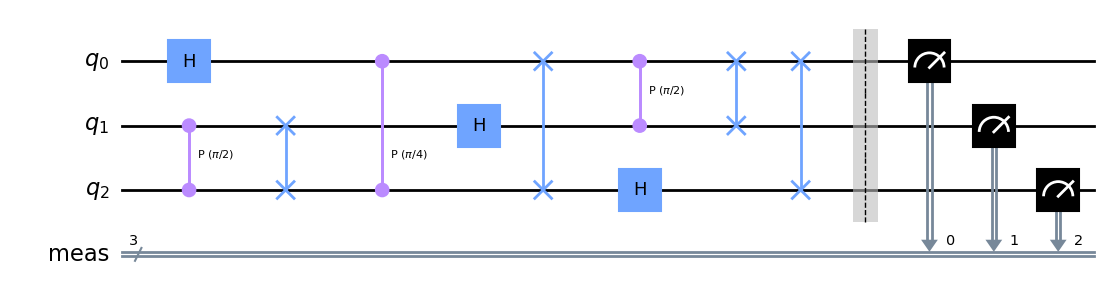

In [20]:
qc.draw('mpl')

In [27]:
from qiskit import QuantumCircuit, Aer, transpile, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import numpy as np

# 버터플라이 연산 (제어 회전 + 스왑)
def butterfly(qc, control, target, k):
    """ 버터플라이 연산: 제어 회전과 스왑 """
    angle = -2 * np.pi / (2 ** (k + 1))
    qc.cp(angle, control, target)
    qc.swap(control, target)

# 4-큐빗 버터플라이 FFT 회로 생성
def butterfly_fft_circuit():
    qc = QuantumCircuit(4)
    
    # 초기 상태 준비 (슈퍼포지션 생성)
    for i in range(4):
        qc.h(i)
    
    # 1단계 버터플라이 (0-2, 1-3 페어)
    butterfly(qc, 0, 2, k=1)
    butterfly(qc, 1, 3, k=1)
    
    # 2단계 버터플라이 (0-1, 2-3 페어)
    butterfly(qc, 0, 1, k=2)
    butterfly(qc, 2, 3, k=2)
    
    # 비트 반전 (출력 순서 정렬)
    qc.swap(0, 3)
    qc.swap(1, 2)
    
    return qc

# QFT 회로 생성 (n=4)
def qft_circuit(n):
    qc = QuantumCircuit(n)
    
    for i in range(n):
        qc.h(i)
        for j in range(i+1, n):
            angle = -2 * np.pi / (2 ** (j-i+1))
            qc.cp(angle, j, i)
    
    # 비트 반전 (QFT는 자동으로 뒤집음)
    for i in range(n//2):
        qc.swap(i, n-i-1)
    
    return qc

# 1. 버터플라이 FFT 회로 생성 및 상태 확인
qc_butterfly = butterfly_fft_circuit()
sv_butterfly = Statevector.from_instruction(qc_butterfly)
print("Butterfly FFT Statevector:", sv_butterfly)

# 2. QFT 회로 생성 및 상태 확인 (비교용)
qc_qft = qft_circuit(4)
sv_qft = Statevector.from_instruction(qc_qft)
print("QFT Statevector:", sv_qft)

# 3. 회로 시각화
print("Butterfly FFT Circuit:\n", qc_butterfly.draw('text'))
print("QFT Circuit:\n", qc_qft.draw('text'))

# 4. 측정 및 시뮬레이터 실행
qc_butterfly.measure_all()
qc_qft.measure_all()

# 버터플라이 측정 결과
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit_butterfly = transpile(qc_butterfly, simulator)
job_butterfly = execute(compiled_circuit_butterfly, backend=simulator, shots=1024)
result_butterfly = job_butterfly.result()
counts_butterfly = result_butterfly.get_counts()
print("Butterfly Quantum Result:", counts_butterfly)
plot_histogram(counts_butterfly).show()

# QFT 측정 결과
compiled_circuit_qft = transpile(qc_qft, simulator)
job_qft = execute(compiled_circuit_qft, backend=simulator, shots=1024)
result_qft = job_qft.result()
counts_qft = result_qft.get_counts()
print("QFT Quantum Result:", counts_qft)
plot_histogram(counts_qft).show()


Butterfly FFT Statevector: Statevector([ 2.50000000e-01+0.j       ,  2.50000000e-01+0.j       ,
              2.50000000e-01+0.j       ,  1.76776695e-01-0.1767767j,
              2.50000000e-01+0.j       ,  1.53080850e-17-0.25j     ,
              2.50000000e-01+0.j       , -1.76776695e-01-0.1767767j,
              2.50000000e-01+0.j       ,  2.50000000e-01+0.j       ,
              1.53080850e-17-0.25j     , -1.76776695e-01-0.1767767j,
              1.76776695e-01-0.1767767j, -1.76776695e-01-0.1767767j,
             -1.76776695e-01-0.1767767j, -4.16333634e-17+0.25j     ],
            dims=(2, 2, 2, 2))
QFT Statevector: Statevector([0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
             0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
             0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j],
            dims=(2, 2, 2, 2))
Butterfly FFT Circuit:
      ┌───┐                                             
q_0: ┤ H ├─■───────────────────X─────■─────────X──X────
     

C:\Users\HCI\AppData\Local\Temp\ipykernel_1084\3570486737.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts_butterfly).show()
C:\Users\HCI\AppData\Local\Temp\ipykernel_1084\3570486737.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts_qft).show()


C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


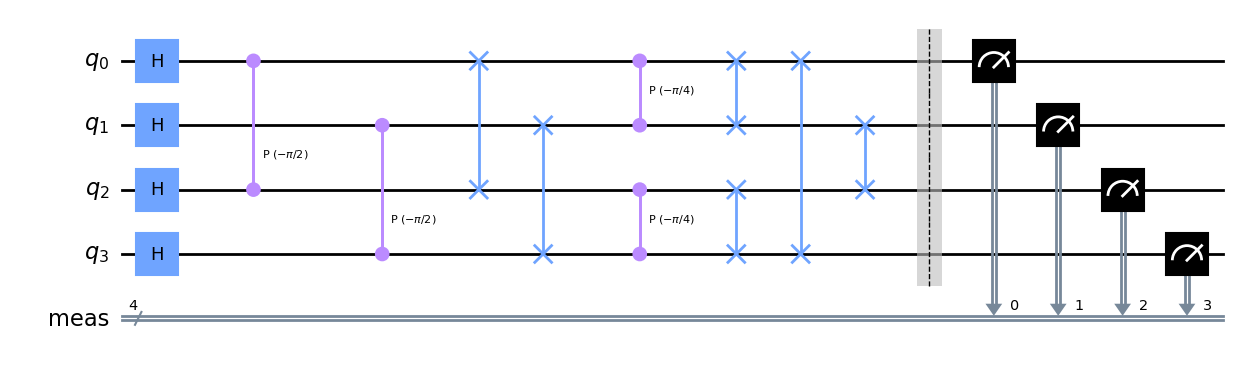

In [28]:
qc_butterfly.draw('mpl')

QFT Quantum Result: {'00': 262, '01': 240, '11': 269, '10': 253}


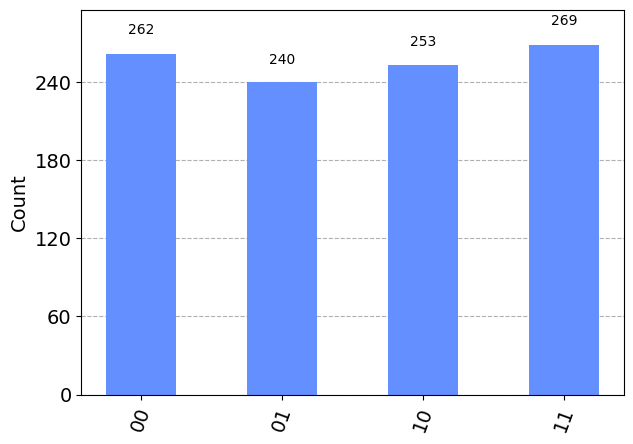

In [26]:

# QFT 측정 결과
compiled_circuit_qft = transpile(qc_qft, simulator)
job_qft = execute(compiled_circuit_qft, backend=simulator, shots=1024)
result_qft = job_qft.result()
counts_qft = result_qft.get_counts()
print("QFT Quantum Result:", counts_qft)
plot_histogram(counts_qft)

# FRQI Kernel Quantum Fourier Convolution

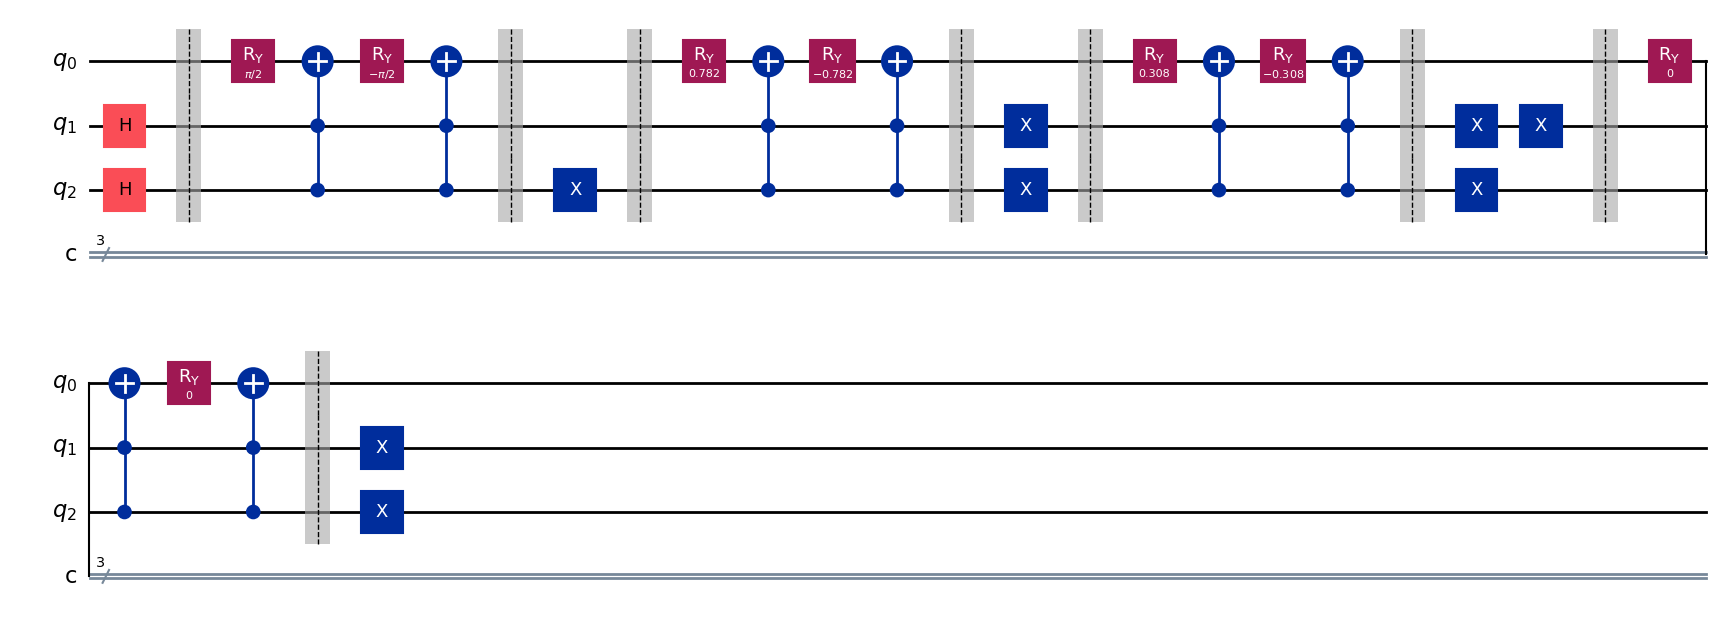

In [258]:
frqi = QuantumCircuit(3,3)
frqi.h(1)
frqi.h(2)

frqi.barrier()
frqi.mcry(np.pi,[1,2],0)
frqi.barrier()

frqi.x(2)
frqi.barrier()
frqi.mcry(127/255 * np.pi,[1,2],0)
frqi.barrier()
frqi.x(2)

frqi.x(1)
frqi.barrier()
frqi.mcry(50/255 * np.pi,[1,2],0)
frqi.barrier()
frqi.x(1)

frqi.x(1)
frqi.x(2)
frqi.barrier()
frqi.mcry(0,[1,2],0)
frqi.barrier()
frqi.x(2)
frqi.x(1)


frqi.draw('mpl')

In [259]:
sv_frqi = Statevector.from_instruction(frqi)
print("FRQI Statevector:", sv_frqi)

FRQI Statevector: Statevector([ 5.00000000e-01+0.j, -1.49530717e-17+0.j,  3.54640654e-01+0.j,
              3.52462773e-01+0.j,  4.76471000e-01+0.j,  1.51576337e-01+0.j,
             -1.51173088e-17+0.j,  5.00000000e-01+0.j],
            dims=(2, 2, 2))


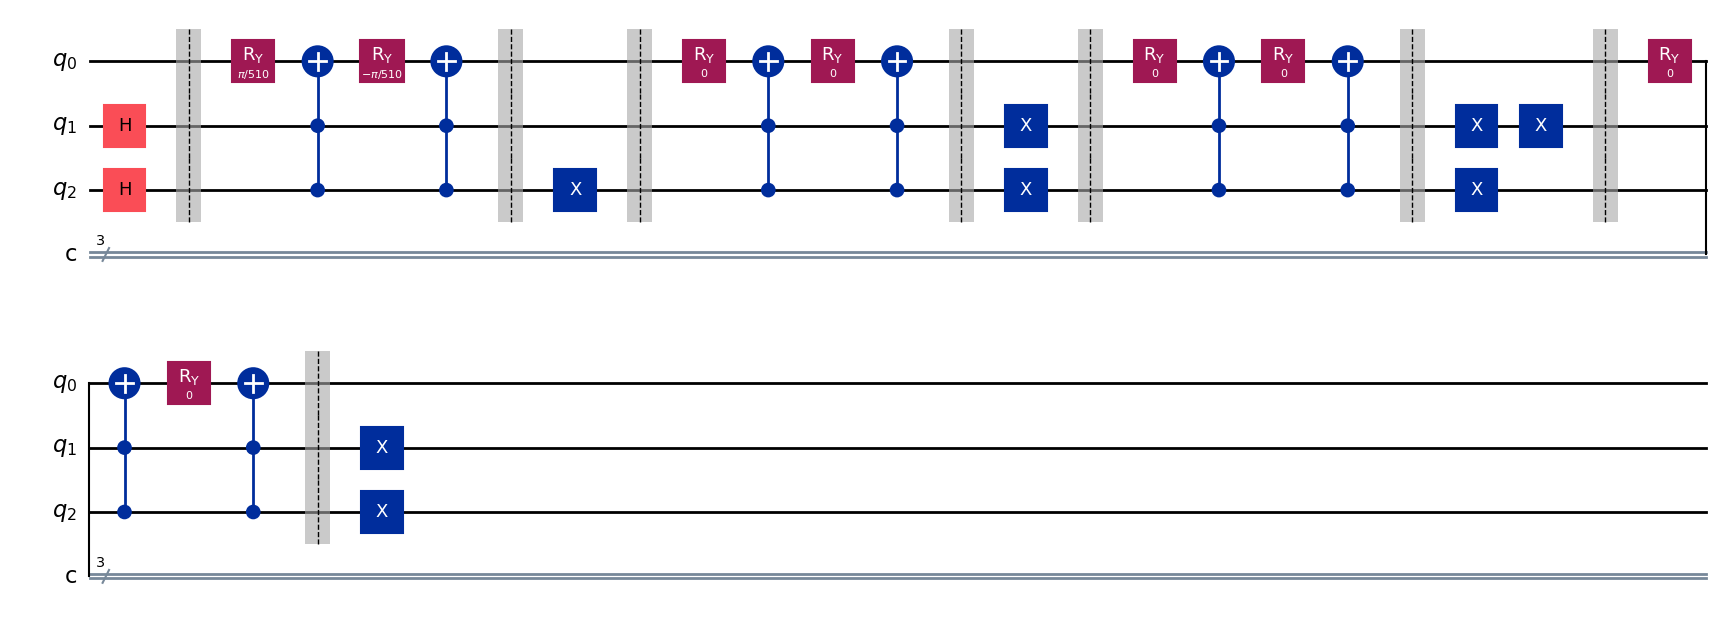

In [205]:
kernel = QuantumCircuit(3,3)
kernel.h(1)
kernel.h(2)

kernel.barrier()
kernel.mcry(np.pi/255,[1,2],0)
kernel.barrier()

kernel.x(2)
kernel.barrier()
kernel.mcry(0,[1,2],0)
kernel.barrier()
kernel.x(2)

kernel.x(1)
kernel.barrier()
kernel.mcry(0,[1,2],0)
kernel.barrier()
kernel.x(1)

kernel.x(1)
kernel.x(2)
kernel.barrier()
kernel.mcry(0,[1,2],0)
kernel.barrier()
kernel.x(2)
kernel.x(1)

kernel.draw('mpl')

In [192]:
qft_circuit = QFT(num_qubits=3).decompose()  # Create and decompose QFT for 2 qubits
frqi_qft = frqi.compose(qft_circuit)

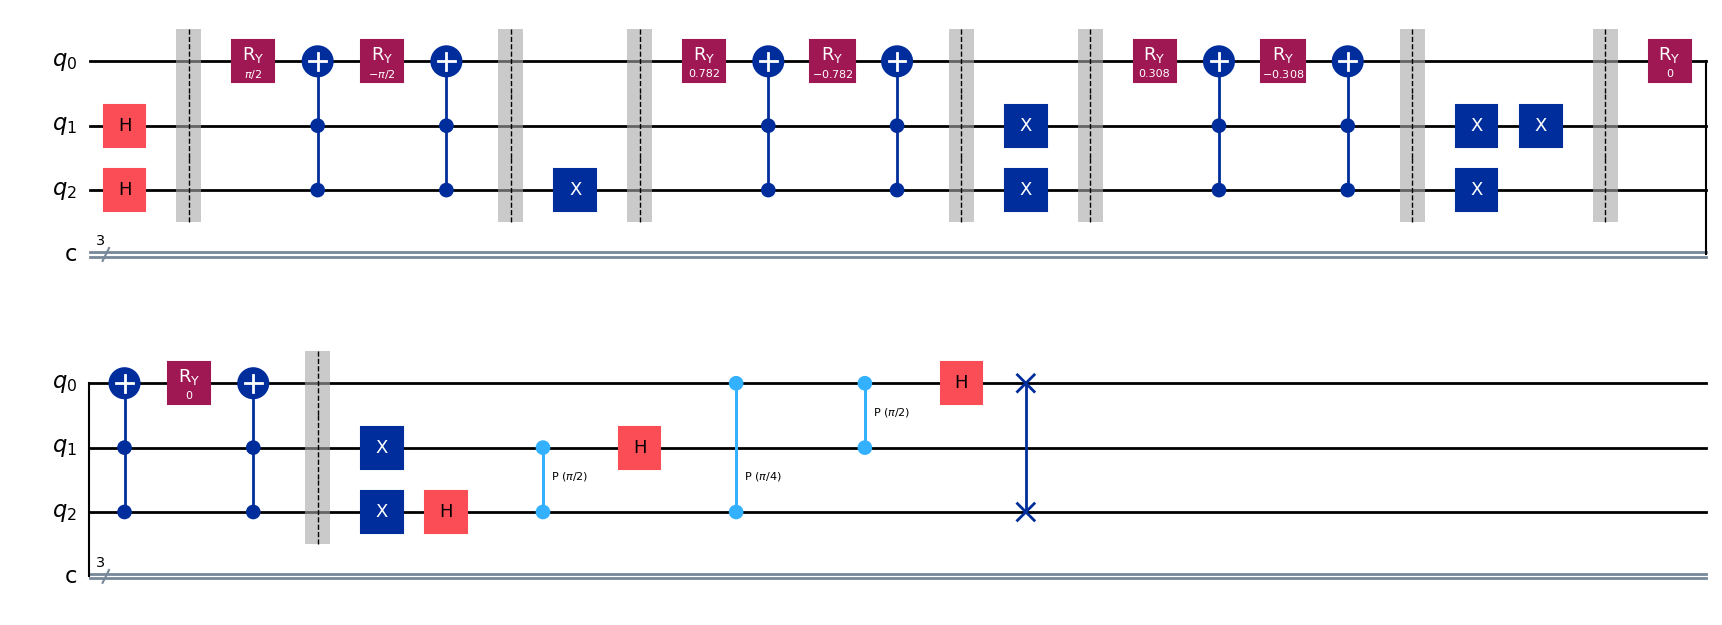

In [193]:
frqi_qft.draw('mpl')

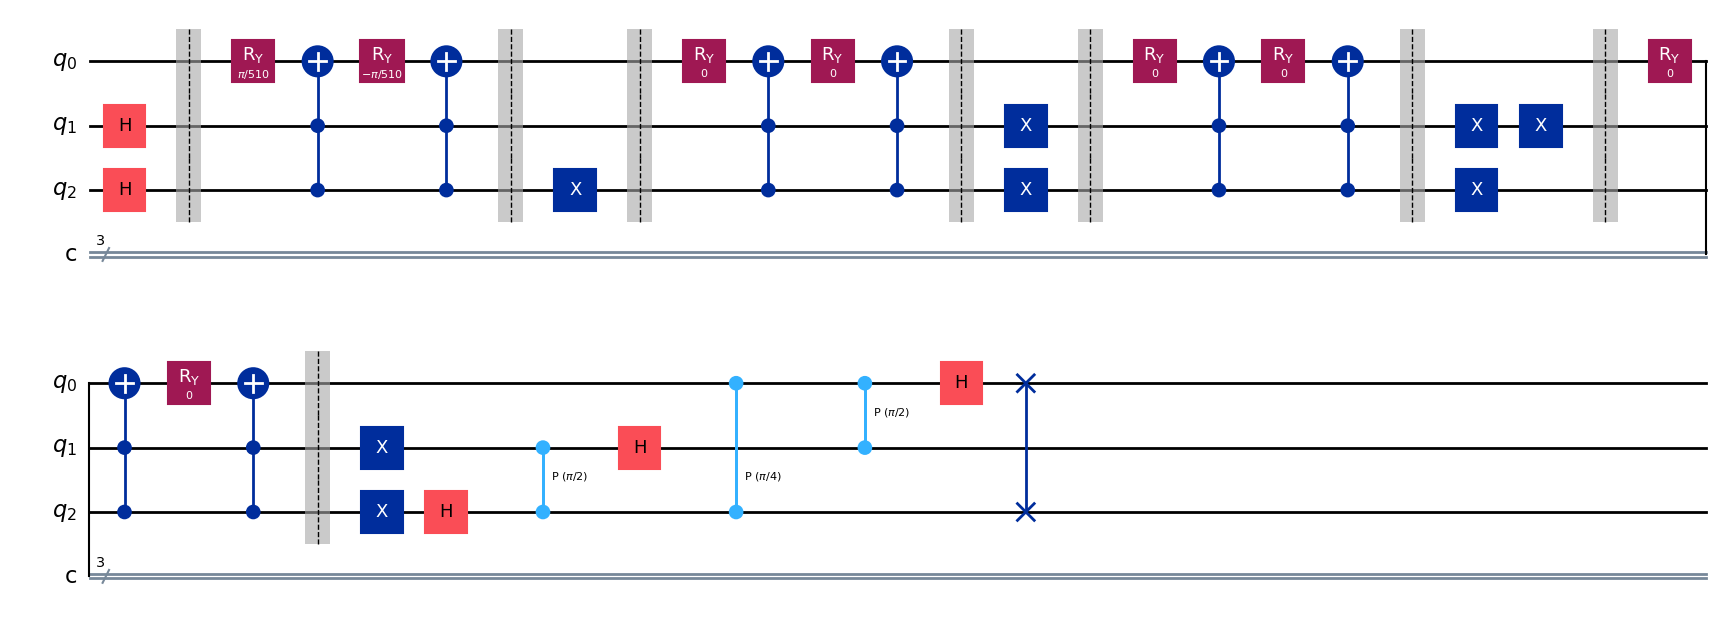

In [206]:
kernel_qft = kernel.compose(qft_circuit)
kernel_qft.draw('mpl')

In [ ]:
sv_kernel_qft = Statevector.from_instruction(kernel_qft)

In [221]:
sv_frqi = Statevector.from_instruction(frqi)
sv_frqi_qft= Statevector.from_instruction(frqi_qft)
sv_kernel = Statevector.from_instruction(kernel)
sv_kernel_qft = Statevector.from_instruction(kernel_qft)

In [230]:
rounded_sv_frqi_qft = np.round(sv_frqi_qft, 3)
rounded_sv_kernel_qft = np.round(sv_kernel_qft, 3)

#rounded_reordered_sv_frqi_qft = np.round(reordered_sv_frqi_qft, 3)
#rounded_reordered_sv_kernel_qft = np.round(reordered_sv_kernel_qft, 3)

print("FRQI+QFT Statevector:", rounded_sv_frqi_qft)
print("================================================")
print("Kernel+QFT Statevector:", rounded_sv_kernel_qft)

#print("Resorted FRQI+QFT Statevector:", rounded_reordered_sv_frqi_qft)
#print("Resorted Kernel+QFT Statevector:", rounded_reordered_sv_kernel_qft)

FRQI+QFT Statevector: [0.826+0.j    0.007+0.051j 0.22 -0.248j 0.009-0.2j   0.116+0.j
 0.009+0.2j   0.22 +0.248j 0.007-0.051j]
Kernel+QFT Statevector: [ 0.708+0.j     0.001-0.001j  0.   -0.001j -0.001-0.001j  0.706+0.j
 -0.001+0.001j  0.   +0.001j  0.001+0.001j]


In [231]:
# 비트 반전 인덱스 생성
def reverse_bits(index, num_qubits):
    """num_qubits 비트의 index를 뒤집어 반환"""
    bin_str = format(index, f'0{num_qubits}b')  # 이진 변환 (앞을 0으로 채움)
    reversed_bin_str = bin_str[::-1]  # 비트 뒤집기
    return int(reversed_bin_str, 2)  # 다시 정수 변환

In [234]:
num_qubits = int(np.log2(len(sv_frqi_qft)))  # 비트 수 (여기선 3)
num_states = len(sv_frqi_qft)  # 상태 개수 (8)

# 새로운 벡터 생성
reordered_sv_frqi_qft = np.zeros_like(sv_frqi_qft, dtype=complex)
for i in range(num_states):
    reversed_index = reverse_bits(i, num_qubits)
    reordered_sv_frqi_qft[reversed_index] = sv_frqi_qft[i]

reordered_sv_kernel_qft = np.zeros_like(sv_kernel_qft, dtype=complex)
for i in range(num_states):
    reversed_index = reverse_bits(i, num_qubits)
    reordered_sv_kernel_qft[reversed_index] = sv_kernel_qft[i]

# 출력
rounded_reordered_sv_frqi_qft = np.round(reordered_sv_frqi_qft, 3)
rounded_reordered_sv_kernel_qft = np.round(reordered_sv_kernel_qft, 3)

print("Resorted FRQI+QFT Statevector:", rounded_reordered_sv_frqi_qft)
print("=============================================================================================")
print("Resorted Kernel+QFT Statevector:", rounded_reordered_sv_kernel_qft)

Resorted FRQI+QFT Statevector: [0.826+0.j    0.116+0.j    0.22 -0.248j 0.22 +0.248j 0.007+0.051j
 0.009+0.2j   0.009-0.2j   0.007-0.051j]
Resorted Kernel+QFT Statevector: [ 0.708+0.j     0.706+0.j     0.   -0.001j  0.   +0.001j  0.001-0.001j
 -0.001+0.001j -0.001-0.001j  0.001+0.001j]


In [199]:
rounded_sv_frqi = np.round(sv_frqi, 3)
rounded_sv_frqi_qft = np.round(sv_frqi_qft, 3)
rounded_sv_kernel= np.round(sv_kernel, 3)
rounded_sv_kernel_qft = np.round(sv_kernel_qft, 3)

#rounded_reordered_sv_frqi_qft = np.round(reordered_sv_frqi_qft, 3)
#rounded_reordered_sv_kernel_qft = np.round(reordered_sv_kernel_qft, 3)

print("FRQI Statevector:", rounded_sv_frqi)
print("================================================")
print("FRQI+QFT Statevector:", rounded_sv_frqi_qft)
print("================================================")
print("Kernel Statevector:", rounded_sv_kernel)
print("================================================")
print("Kernel+QFT Statevector:", rounded_sv_kernel_qft)

#print("Resorted FRQI+QFT Statevector:", rounded_reordered_sv_frqi_qft)
#print("Resorted Kernel+QFT Statevector:", rounded_reordered_sv_kernel_qft)

FRQI Statevector: [ 0.5  +0.j -0.   +0.j  0.355+0.j  0.352+0.j  0.476+0.j  0.152+0.j
 -0.   +0.j  0.5  +0.j]
FRQI+QFT Statevector: [0.826+0.j    0.007+0.051j 0.22 -0.248j 0.009-0.2j   0.116+0.j
 0.009+0.2j   0.22 +0.248j 0.007-0.051j]
Kernel Statevector: [ 0.5  +0.j -0.   +0.j  0.5  +0.j -0.   +0.j  0.5  +0.j -0.   +0.j
  0.5  +0.j  0.003+0.j]
Kernel+QFT Statevector: [ 0.708+0.j     0.001-0.001j  0.   -0.001j -0.001-0.001j  0.706+0.j
 -0.001+0.001j  0.   +0.001j  0.001+0.001j]


In [237]:
element_wise = reordered_sv_frqi_qft *reordered_sv_kernel_qft
element_wise_state = Statevector(element_wise)
element_wise_state

Statevector([ 5.84683947e-01+0.00000000e+00j,
              8.16418262e-02+0.00000000e+00j,
             -2.69101580e-04-2.40233714e-04j,
             -2.69101580e-04+2.40233714e-04j,
              4.44244310e-05+3.33629416e-05j,
             -1.61978259e-04-1.46909821e-04j,
             -1.61978259e-04+1.46909821e-04j,
              4.44244310e-05-3.33629416e-05j],
            dims=(2, 2, 2))


In [242]:
reordered_sv_kernel_qft
sum_of_squares = np.sum(np.abs(reordered_sv_kernel_qft) ** 2)
# 제곱근 계산
result = np.sqrt(sum_of_squares)
# 출력
print("size = " ,result)

size =  0.9999999999999993


In [238]:
element_wise = reordered_sv_frqi_qft *reordered_sv_kernel_qft
element_wise_state = Statevector(element_wise)

# element-wise 곱셈 결과 크기가 1이 아니므로 정규화
element_wise_state_norm = element_wise_state / np.linalg.norm(element_wise_state.data)
print("Normalized element-wise multiplication = ","\n",element_wise_state_norm)
sum_of_squares = np.sum(np.abs(element_wise_state_norm) ** 2)
# 제곱근 계산
result = np.sqrt(sum_of_squares)
# 출력
print("size = " ,result)

Normalized element-wise multiplication =  
 Statevector([ 9.90390925e-01+0.00000000e+00j,
              1.38292361e-01+0.00000000e+00j,
             -4.55828766e-04-4.06929746e-04j,
             -4.55828766e-04+4.06929746e-04j,
              7.52501475e-05+5.65131894e-05j,
             -2.74373528e-04-2.48849236e-04j,
             -2.74373528e-04+2.48849236e-04j,
              7.52501475e-05-5.65131894e-05j],
            dims=(2, 2, 2))
size =  1.0


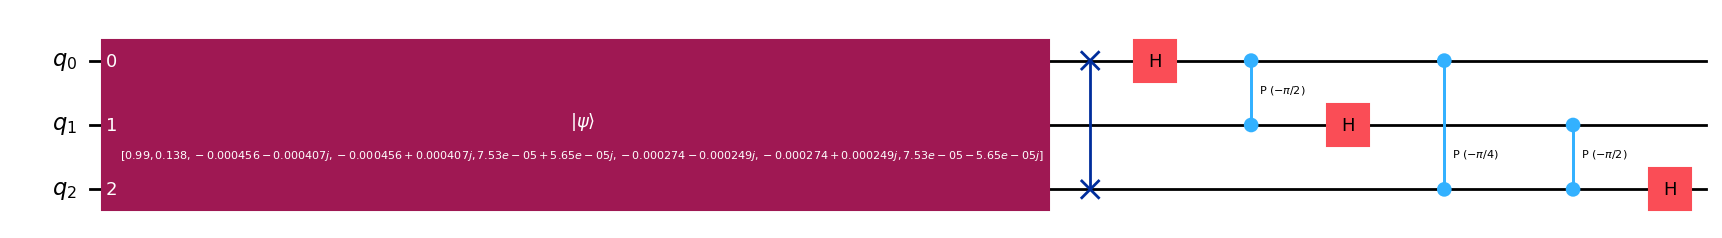

In [240]:
element_wise_qc = QuantumCircuit(3)
element_wise_qc.initialize(element_wise_state_norm)
iqft_circuit=QFT(num_qubits=3, inverse=True).decompose()
element_wise_qc_iqft = element_wise_qc.compose(iqft_circuit)
element_wise_qc_iqft.draw('mpl')

In [241]:
element_wise_qc_iqft_state = Statevector(element_wise_qc_iqft)
print(element_wise_qc_iqft_state)
print("=============================================")
# 모든 항의 절댓값을 제곱한 후 합산
sum_of_squares = np.sum(np.abs(element_wise_qc_iqft_state) ** 2)
# 제곱근 계산
result = np.sqrt(sum_of_squares)
# 출력
print(result)

rounded_iqft = np.round(element_wise_qc_iqft_state, 3)
print("Frequency domain multiplication = ","\n",rounded_iqft)

Statevector([0.39858668+5.06578837e-20j, 0.38485014-3.45183887e-02j,
             0.35022897-4.88554121e-02j, 0.31576494-3.45394001e-02j,
             0.30126234-7.18189414e-05j, 0.31494509+3.46067361e-02j,
             0.35065271+4.90071528e-02j, 0.3849577 +3.43711310e-02j],
            dims=(2, 2, 2))
0.9999999999999997
Frequency domain multiplication =  
 [0.399+0.j    0.385-0.035j 0.35 -0.049j 0.316-0.035j 0.301-0.j
 0.315+0.035j 0.351+0.049j 0.385+0.034j]


In [228]:
amp = {}
for i, value in enumerate(element_wise_qc_iqft_state):
    # 이진법 키를 생성
    binary_key = format(i, '03b')  # 3자리 이진법으로 표현
    amp[binary_key] = value
'''
# 뒤집은 키로 새 딕셔너리 만들기
amp_reversed = {}
for key, value in amp.items():
    reversed_key = key[::-1]  # 키 뒤집기
    amp_reversed[reversed_key] = value

# 딕셔너리 정렬
amp = dict(sorted(amp_reversed.items()))
'''
amp

{'000': (0.39858668163120453+5.0657883716071917e-20j),
 '001': (0.38485013814657487-0.03451838874063129j),
 '010': (0.35022896746220633-0.048855412102293855j),
 '011': (0.31576493699608243-0.03453940012046155j),
 '100': (0.30126233621091264-7.181894138249257e-05j),
 '101': (0.3149450851452732+0.0346067361108664j),
 '110': (0.3506527123679185+0.0490071527625154j),
 '111': (0.38495769782602907+0.03437113103138738j)}

In [229]:
def estimate_angle(state_0, state_1):
    if state_0 + state_1 == 0:
        return 0  # 분모가 0이면 0으로 처리 (해당 상태 없음)
    ratio = state_0 / (state_0 + state_1)
    theta = 2 * np.arccos(np.sqrt(ratio))
    return (255 / np.pi) * theta  # 255*pi 기준 변환

# 복원된 그레이스케일 값 (각 픽셀의 위상 복원)
gray_1 = estimate_angle(amp['000'], amp['100'])  # '01'을 기준으로
gray_2 = estimate_angle(amp['001'], amp['101'])  # '10'을 기준으로
gray_3 = estimate_angle(amp['010'], amp['110'])  # '01'을 기준으로
gray_4 = estimate_angle(amp['011'], amp['111'])  # '10'을 기준으로
print(f"복원된 Grayscale 값: {gray_1:.2f}, {gray_2:.2f},{gray_3:.2f}, {gray_4:.2f}")

복원된 Grayscale 값: 116.18-0.01j, 119.42+8.05j,127.55+11.30j, 135.49+8.01j


# Kernel Method 변경

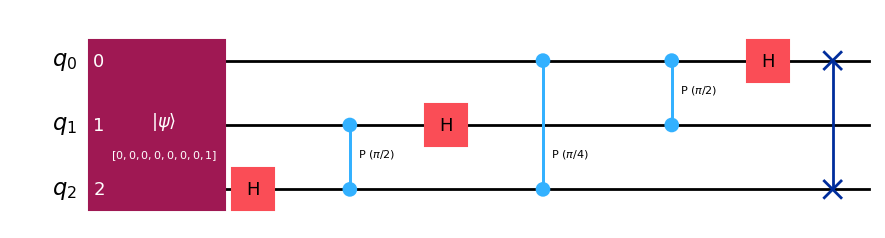

In [246]:
kernel_init = np.array([0,0,0,0,0,0,0,1])
kernel_expand = QuantumCircuit(3)
kernel_expand.initialize(kernel_init,[0,1,2])
qft_circuit = QFT(num_qubits=3).decompose()
kernel_expand_qft = kernel_expand.compose(qft_circuit)
kernel_expand_qft.draw('mpl')

In [247]:
sv_frqi = Statevector.from_instruction(frqi)
sv_frqi_qft= Statevector.from_instruction(frqi_qft)
sv_kernel_expand_qft = Statevector.from_instruction(kernel_expand_qft)

In [248]:
rounded_sv_frqi_qft = np.round(sv_frqi_qft, 3)
rounded_sv_kernel_expand_qft = np.round(sv_kernel_expand_qft, 3)

#rounded_reordered_sv_frqi_qft = np.round(reordered_sv_frqi_qft, 3)
#rounded_reordered_sv_kernel_qft = np.round(reordered_sv_kernel_qft, 3)

print("FRQI+QFT Statevector:", rounded_sv_frqi_qft)
print("================================================")
print("Kernel+QFT Statevector:", rounded_sv_kernel_expand_qft)

#print("Resorted FRQI+QFT Statevector:", rounded_reordered_sv_frqi_qft)
#print("Resorted Kernel+QFT Statevector:", rounded_reordered_sv_kernel_qft)

FRQI+QFT Statevector: [0.826+0.j    0.007+0.051j 0.22 -0.248j 0.009-0.2j   0.116+0.j
 0.009+0.2j   0.22 +0.248j 0.007-0.051j]
Kernel+QFT Statevector: [ 0.354+0.j     0.25 -0.25j  -0.   -0.354j -0.25 -0.25j  -0.354+0.j
 -0.25 +0.25j   0.   +0.354j  0.25 +0.25j ]


In [249]:
# 비트 반전 인덱스 생성
def reverse_bits(index, num_qubits):
    """num_qubits 비트의 index를 뒤집어 반환"""
    bin_str = format(index, f'0{num_qubits}b')  # 이진 변환 (앞을 0으로 채움)
    reversed_bin_str = bin_str[::-1]  # 비트 뒤집기
    return int(reversed_bin_str, 2)  # 다시 정수 변환

In [250]:
num_qubits = int(np.log2(len(sv_frqi_qft)))  # 비트 수 (여기선 3)
num_states = len(sv_frqi_qft)  # 상태 개수 (8)

# 새로운 벡터 생성
reordered_sv_frqi_qft = np.zeros_like(sv_frqi_qft, dtype=complex)
for i in range(num_states):
    reversed_index = reverse_bits(i, num_qubits)
    reordered_sv_frqi_qft[reversed_index] = sv_frqi_qft[i]

reordered_sv_kernel_expand_qft = np.zeros_like(sv_kernel_expand_qft, dtype=complex)
for i in range(num_states):
    reversed_index = reverse_bits(i, num_qubits)
    reordered_sv_kernel_expand_qft[reversed_index] = sv_kernel_expand_qft[i]

# 출력
rounded_reordered_sv_frqi_qft = np.round(reordered_sv_frqi_qft, 3)
rounded_reordered_sv_kernel_qft = np.round(reordered_sv_kernel_expand_qft, 3)

print("Resorted FRQI+QFT Statevector:", rounded_reordered_sv_frqi_qft)
print("=============================================================================================")
print("Resorted Kernel+QFT Statevector:", rounded_reordered_sv_kernel_qft)

Resorted FRQI+QFT Statevector: [0.826+0.j    0.116+0.j    0.22 -0.248j 0.22 +0.248j 0.007+0.051j
 0.009+0.2j   0.009-0.2j   0.007-0.051j]
Resorted Kernel+QFT Statevector: [ 0.354+0.j    -0.354+0.j    -0.   -0.354j  0.   +0.354j  0.25 -0.25j
 -0.25 +0.25j  -0.25 -0.25j   0.25 +0.25j ]


In [251]:
element_wise = reordered_sv_frqi_qft *reordered_sv_kernel_expand_qft
element_wise_state = Statevector(element_wise)
element_wise_state

Statevector([ 0.29189385+0.j        , -0.04088407+0.j        ,
             -0.0876108 -0.07772879j, -0.0876108 +0.07772879j,
              0.01447875+0.01082426j, -0.05237283-0.04770857j,
             -0.05237283+0.04770857j,  0.01447875-0.01082426j],
            dims=(2, 2, 2))


In [253]:
reordered_sv_kernel_expand_qft
sum_of_squares = np.sum(np.abs(reordered_sv_kernel_expand_qft) ** 2)
# 제곱근 계산
result = np.sqrt(sum_of_squares)
# 출력
print("size = " ,result)

size =  0.9999999999999998


In [254]:
element_wise = reordered_sv_frqi_qft *reordered_sv_kernel_expand_qft
element_wise_state = Statevector(element_wise)

# element-wise 곱셈 결과 크기가 1이 아니므로 정규화
element_wise_state_norm = element_wise_state / np.linalg.norm(element_wise_state.data)
print("Normalized element-wise multiplication = ","\n",element_wise_state_norm)
sum_of_squares = np.sum(np.abs(element_wise_state_norm) ** 2)
# 제곱근 계산
result = np.sqrt(sum_of_squares)
# 출력
print("size = " ,result)

Normalized element-wise multiplication =  
 Statevector([ 0.82560047+0.j        , -0.11563761+0.j        ,
             -0.24780078-0.21985023j, -0.24780078+0.21985023j,
              0.04095209+0.03061563j, -0.14813274-0.1349402j ,
             -0.14813274+0.1349402j ,  0.04095209-0.03061563j],
            dims=(2, 2, 2))
size =  1.0


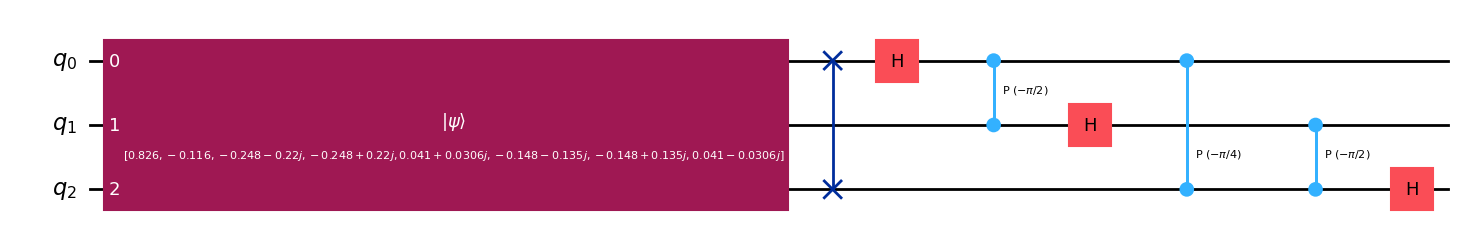

In [255]:
element_wise_qc = QuantumCircuit(3)
element_wise_qc.initialize(element_wise_state_norm)
iqft_circuit=QFT(num_qubits=3, inverse=True).decompose()
element_wise_qc_iqft = element_wise_qc.compose(iqft_circuit)
element_wise_qc_iqft.draw('mpl')

In [256]:
element_wise_qc_iqft_state = Statevector(element_wise_qc_iqft)
print(element_wise_qc_iqft_state)
print("=============================================")
# 모든 항의 절댓값을 제곱한 후 합산
sum_of_squares = np.sum(np.abs(element_wise_qc_iqft_state) ** 2)
# 제곱근 계산
result = np.sqrt(sum_of_squares)
# 출력
print(result)

rounded_iqft = np.round(element_wise_qc_iqft_state, 3)
print("Frequency domain multiplication = ","\n",rounded_iqft)

Statevector([-8.91591293e-17+3.44476201e-17j,
              3.28641251e-01+5.95967312e-02j,
              3.31743132e-01+6.09693317e-02j,
              4.18891970e-01+4.68836150e-02j,
              3.32777914e-01-3.83919387e-02j,
             -2.46857743e-02-1.07693053e-02j,
              5.60969332e-01+2.07196417e-02j,
              3.86812941e-01-1.39008076e-01j],
            dims=(2, 2, 2))
0.9999999999999997
Frequency domain multiplication =  
 [-0.   +0.j     0.329+0.06j   0.332+0.061j  0.419+0.047j  0.333-0.038j
 -0.025-0.011j  0.561+0.021j  0.387-0.139j]


In [257]:
def estimate_angle(state_0, state_1):
    if state_0 + state_1 == 0:
        return 0  # 분모가 0이면 0으로 처리 (해당 상태 없음)
    ratio = state_0 / (state_0 + state_1)
    theta = 2 * np.arccos(np.sqrt(ratio))
    return (255 / np.pi) * theta  # 255*pi 기준 변환

# 복원된 그레이스케일 값 (각 픽셀의 위상 복원)
gray_1 = estimate_angle(amp['000'], amp['100'])  # '01'을 기준으로
gray_2 = estimate_angle(amp['001'], amp['101'])  # '10'을 기준으로
gray_3 = estimate_angle(amp['010'], amp['110'])  # '01'을 기준으로
gray_4 = estimate_angle(amp['011'], amp['111'])  # '10'을 기준으로
print(f"복원된 Grayscale 값: {gray_1:.2f}, {gray_2:.2f},{gray_3:.2f}, {gray_4:.2f}")

복원된 Grayscale 값: 116.18-0.01j, 119.42+8.05j,127.55+11.30j, 135.49+8.01j


In [ ]:
inverseQFT = np.fft.ifft(result)
recon= []
for i in range(len(inverseQFT)):
    recon.append(2 * np.arccos(np.sqrt(inverseQFT[i])))

recon = np.array(recon)* 255/np.pi

print(recon)
filter = [0,0,0,1]
filter_fft= np.fft.fft(filter)
print(filter_fft)
filter_ifft = np.fft.ifft(filter_fft)
print("Ifft",filter_ifft)

[180.31822782+0.j 180.31822782+0.j 180.31822782+0.j 180.31822782+0.j]


In [113]:
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, execute
from qiskit.visualization import plot_histogram

# 1. Image and Filter definition
image = [0, 127, 127, 255]
filter_ = [0, 0, 0, 1]
n_qubits = int(np.log2(len(image)))

# 2. Quantum Fourier Transform (QFT)
def qft(qc, n):
    for i in range(n):
        qc.h(i)
        for j in range(i+1, n):
            qc.cp(np.pi / (2 ** (j-i)), j, i)

# 3. QFT on image and filter
def qft_measure(input_list):
    qc = QuantumCircuit(n_qubits, n_qubits)
    for i, val in enumerate(input_list):
        bin_val = format(i, f"0{n_qubits}b")
        for j, bit in enumerate(bin_val):
            if bit == '1':
                qc.x(n_qubits - j - 1)

        qc.h(range(n_qubits))  # Angular encoding using Hadamard gates
        qc.barrier()
    
    qft(qc, n_qubits)
    qc.barrier()
    qc.measure(range(n_qubits), range(n_qubits))

    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc, simulator)
    job = execute(compiled_circuit, backend=simulator, shots=10000)
    result = job.result()
    counts = result.get_counts()
    
    return counts

# QFT and measurement for image and filter
qft_image_counts = qft_measure(image)
qft_filter_counts = qft_measure(filter_)

# 4. Combine measurement results for element-wise multiplication
def combine_counts(counts1, counts2):
    combined = {}
    for state1, count1 in counts1.items():
        for state2, count2 in counts2.items():
            combined_state = int(state1, 2) * int(state2, 2)
            if combined_state in combined:
                combined[combined_state] += count1 * count2
            else:
                combined[combined_state] = count1 * count2
    return combined

combined_counts = combine_counts(qft_image_counts, qft_filter_counts)

# 5. Inverse FFT using Numpy
combined_array = np.zeros(len(image), dtype=complex)
for state, amplitude in combined_counts.items():
    combined_array[state % len(image)] = amplitude

ifft_result = np.fft.ifft(combined_array)

# 6. Coefficient adjustment
factor = 1 / len(image)
conv_result = np.real(factor * ifft_result)

qft_image_counts, qft_filter_counts, combined_counts, conv_result


({'10': 2545, '00': 2449, '11': 2482, '01': 2524},
 {'10': 2547, '00': 2402, '01': 2506, '11': 2545},
 {4: 6482115,
  0: 42627502,
  2: 12806398,
  6: 12798679,
  3: 12643472,
  9: 6316690,
  1: 6325144},
 array([4649674.8125, 1864301.4375, 2278597.8125, 1864301.4375]))

# Kernel Inverse Calculation

In [260]:
import numpy as np

def circular_convolution(image, kernel):
    # 입력 이미지와 커널의 크기
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # 커널을 좌우, 상하로 뒤집기 (고전적인 convolution)
    kernel_flipped = kernel

    # 출력 결과를 저장할 배열 초기화
    result = np.zeros_like(image)
    
    # 2D Circular Convolution 계산
    for i in range(image_height):
        for j in range(image_width):
            # 커널이 적용될 위치에 대해 Circular Indexing을 사용
            sum_result = 0
            for m in range(kernel_height):
                for n in range(kernel_width):
                    # Circular 인덱스
                    x = (i - m) % image_height
                    y = (j - n) % image_width
                    sum_result += image[x, y] * kernel_flipped[m, n]
            
            result[i, j] = sum_result
    
    return result

# 예시: 2x2 이미지와 2x2 필터
image = np.array([[0, 50], [127, 255]], dtype=float)
kernel = np.array([[0, 0], [0, 1]], dtype=float)

# Circular Convolution 수행
output = circular_convolution(image, kernel)

print("Input Image:\n", image)
print("Kernel (Flipped):\n", kernel)
print("Circular Convolution Output:\n", output)


Input Image:
 [[  0.  50.]
 [127. 255.]]
Kernel (Flipped):
 [[0. 0.]
 [0. 1.]]
Circular Convolution Output:
 [[255. 127.]
 [ 50.   0.]]


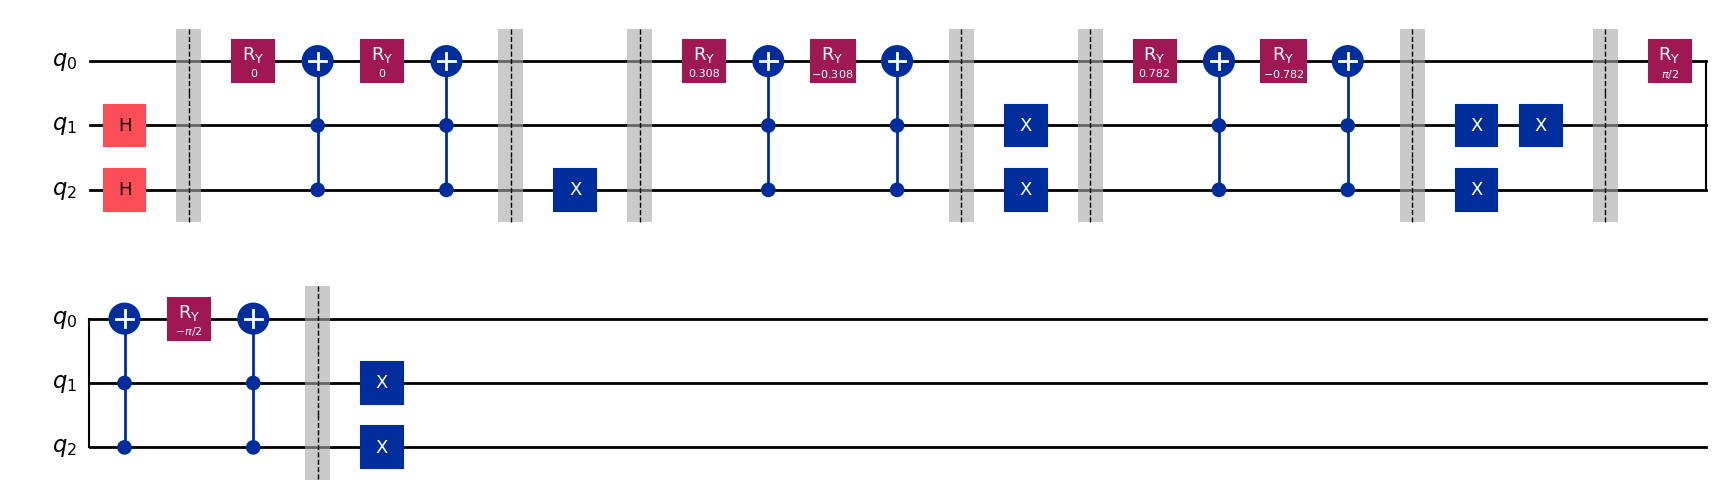

In [411]:
conv = QuantumCircuit(3)
conv.h(1)
conv.h(2)

conv.barrier()
conv.mcry(0,[1,2],0)
conv.barrier()

conv.x(2)
conv.barrier()
conv.mcry(50 * np.pi/255,[1,2],0)
conv.barrier()
conv.x(2)

conv.x(1)
conv.barrier()
conv.mcry(127 * np.pi/255,[1,2],0)
conv.barrier()
conv.x(1)

conv.x(1)
conv.x(2)
conv.barrier()
conv.mcry(255 * np.pi/255,[1,2],0)
conv.barrier()
conv.x(2)
conv.x(1)


conv.draw('mpl')

In [412]:
Statevector(conv)

Statevector([-5.07326818e-18+0.j,  5.00000000e-01+0.j,  4.76471000e-01+0.j,
              1.51576337e-01+0.j,  3.54640654e-01+0.j,  3.52462773e-01+0.j,
              5.00000000e-01+0.j, -5.07326818e-18+0.j],
            dims=(2, 2, 2))


In [380]:
print("Statevector of Convolution =","\n",np.round(Statevector(conv),4))

Statevector of Convolution = 
 [-0.    +0.j  0.5   +0.j  0.4765+0.j  0.1516+0.j  0.3546+0.j  0.3525+0.j
  0.5   +0.j -0.    +0.j]


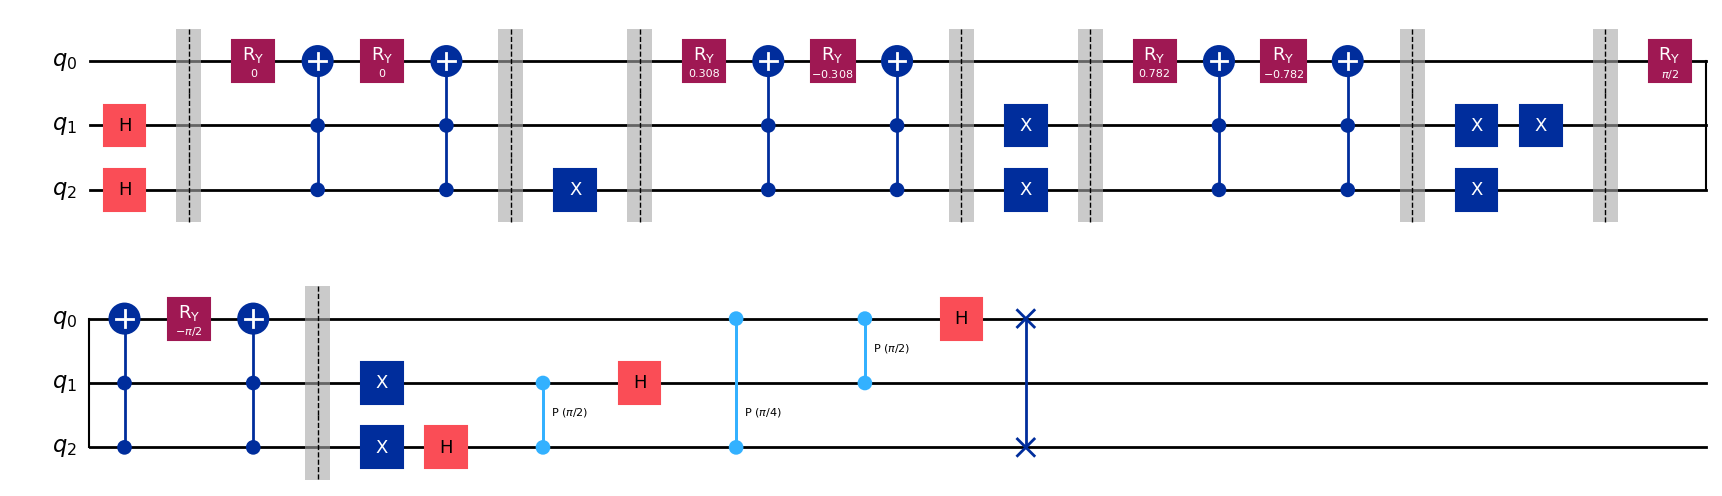

In [381]:
qft = QFT(num_qubits=3).decompose()
conv_qft = conv.compose(qft)
conv_qft.draw('mpl')

In [382]:
state_conv_qft= Statevector(conv_qft)
print(state_conv_qft)

Statevector([ 0.82560047+0.j        , -0.12639418+0.06645963j,
             -0.21985023+0.24780078j, -0.12437463+0.08309715j,
              0.11563761+0.j        , -0.12437463-0.08309715j,
             -0.21985023-0.24780078j, -0.12639418-0.06645963j],
            dims=(2, 2, 2))


In [415]:
round_state_conv_qft = np.round(state_conv_qft,3)
round_state_conv_qft

array([ 0.826+0.j   , -0.126+0.066j, -0.22 +0.248j, -0.124+0.083j,
        0.116+0.j   , -0.124-0.083j, -0.22 -0.248j, -0.126-0.066j])

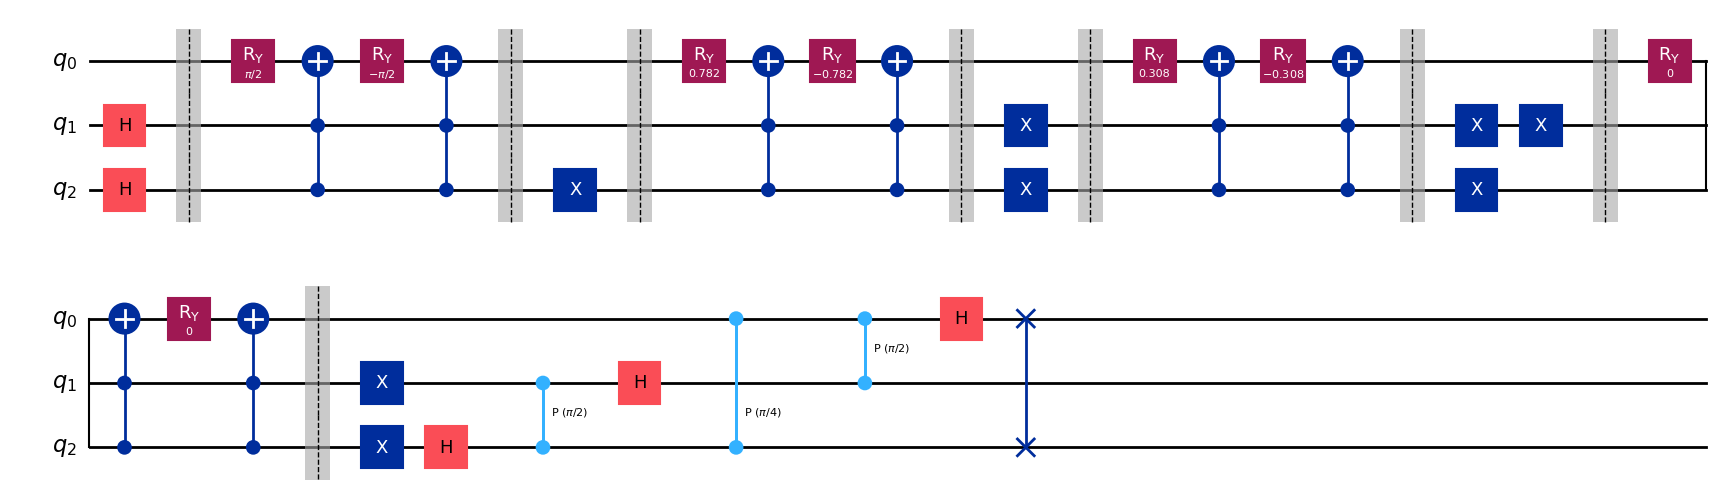

In [383]:
# Image encoding with FRQI method
frqi = QuantumCircuit(3)
frqi.h(1)
frqi.h(2)

frqi.barrier()
frqi.mcry(np.pi,[1,2],0)
frqi.barrier()

frqi.x(2)
frqi.barrier()
frqi.mcry(127 * np.pi/255,[1,2],0)
frqi.barrier()
frqi.x(2)

frqi.x(1)
frqi.barrier()
frqi.mcry(50 * np.pi/255,[1,2],0)
frqi.barrier()
frqi.x(1)

frqi.x(1)
frqi.x(2)
frqi.barrier()
frqi.mcry(0,[1,2],0)
frqi.barrier()
frqi.x(2)
frqi.x(1)

qft = QFT(num_qubits=3).decompose()
frqi_qft = frqi.compose(qft)
frqi_qft.draw('mpl')

In [384]:
Statevector(frqi)

Statevector([ 5.00000000e-01+0.j, -1.49530717e-17+0.j,  3.54640654e-01+0.j,
              3.52462773e-01+0.j,  4.76471000e-01+0.j,  1.51576337e-01+0.j,
             -1.51173088e-17+0.j,  5.00000000e-01+0.j],
            dims=(2, 2, 2))


In [385]:
state_frqi_qft= Statevector(frqi_qft)
print(state_frqi_qft)

Statevector([0.82560047+0.j        , 0.00730898+0.05060601j,
             0.21985023-0.24780078j, 0.00932854-0.2001628j ,
             0.11563761+0.j        , 0.00932854+0.2001628j ,
             0.21985023+0.24780078j, 0.00730898-0.05060601j],
            dims=(2, 2, 2))


In [416]:
round_state_frqi_qft = np.round(state_frqi_qft,3)
round_state_frqi_qft

array([0.826-0.j   , 0.007+0.051j, 0.22 -0.248j, 0.009-0.2j  ,
       0.116-0.j   , 0.009+0.2j  , 0.22 +0.248j, 0.007-0.051j])

In [417]:
hdivision = np.array(state_conv_qft) / np.array(state_frqi_qft)
print(hdivision)

print(np.round(hdivision,3))

[ 1.        +6.92579616e-16j  0.9330837 +2.63237629e+00j
 -1.        -1.37883789e-15j -0.44314397-6.00714748e-01j
  1.        +1.19519456e-16j -0.44314397+6.00714748e-01j
 -1.        -6.26744496e-17j  0.9330837 -2.63237629e+00j]
[ 1.   +0.j     0.933+2.632j -1.   -0.j    -0.443-0.601j  1.   +0.j
 -0.443+0.601j -1.   -0.j     0.933-2.632j]


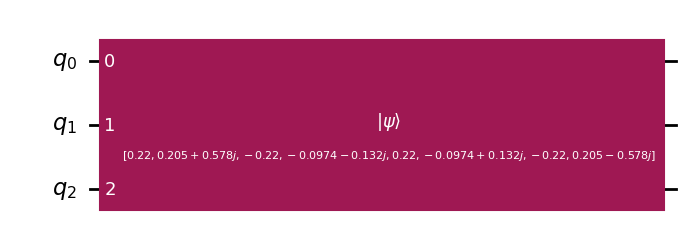

In [387]:
kernel_qft = hdivision/np.linalg.norm(hdivision)
state_kernel_qft = Statevector(kernel_qft)
kernel_inverse = QuantumCircuit(3)
kernel_inverse.initialize(state_kernel_qft)
kernel_inverse.draw('mpl')

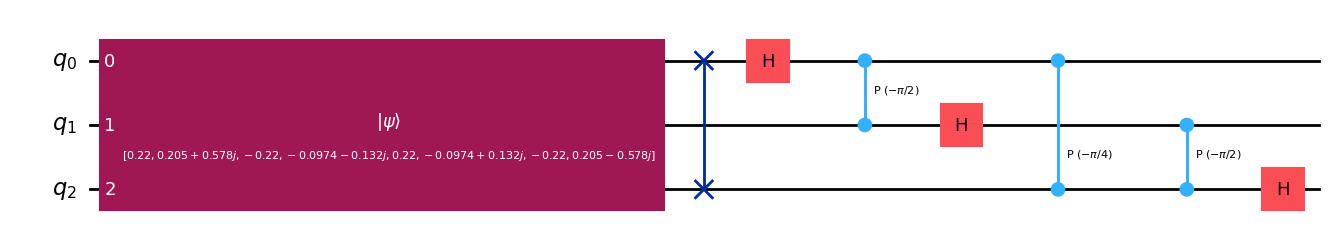

In [388]:
iqft = QFT(num_qubits=3,inverse=True).decompose()
kernel_inverse_iqft = kernel_inverse.compose(iqft)
kernel_inverse_iqft.draw('mpl')

In [389]:
state_kernel_iqft = Statevector(kernel_inverse_iqft)
print(np.round(state_kernel_iqft,3))


[ 0.076+0.j  0.374+0.j  0.813+0.j  0.072-0.j -0.076-0.j -0.374-0.j
 -0.192-0.j -0.072+0.j]


## 검산

In [390]:
frqi_state = Statevector(frqi)

frqi_qft = frqi.compose(qft).decompose()
state_frqi_qft = Statevector(frqi_qft)

kernel_qc = QuantumCircuit(3)
kernel_qc.initialize(state_kernel_iqft)
kernel_qft = kernel_qc.compose(qft).decompose()
state_kernel_qft = Statevector(kernel_qft)

hadamard = np.array(state_frqi_qft)* np.array(state_kernel_qft)

hadamard_norm = hadamard/np.linalg.norm(hadamard)

hqc = QuantumCircuit(3)
hqc.initialize(hadamard_norm)
hqc_iqft = hqc.compose(iqft)
print(np.round(Statevector(hqc_iqft),3))

[ 0.   +0.j  0.5  -0.j  0.476-0.j  0.152+0.j  0.355-0.j  0.352-0.j
  0.5  -0.j -0.   +0.j]


In [395]:
num_qubits = 3
num_states = 2 ** num_qubits  # 8개 상태

# 1. 상태 인덱스를 이진수로 변환
binary_indices = [format(i, f'0{num_qubits}b') for i in range(num_states)]  # ['000', '001', ..., '111']

amp = {}
for i, value in enumerate(Statevector(hqc_iqft)):
    # 이진법 키를 생성
    binary_key = format(i, '03b')  # 3자리 이진법으로 표현
    amp[binary_key] = value
#amp['101'] = 0.356
# 뒤집은 키로 새 딕셔너리 만들기

amp_reversed = {}
for key, value in amp.items():
    reversed_key = key[::-1]  # 키 뒤집기
    amp_reversed[reversed_key] = value

# 딕셔너리 정렬
amp = dict(sorted(amp_reversed.items()))

amp

{'000': (1.1996423324103186e-16+2.0543266830086954e-17j),
 '001': (0.35464065380292675-3.0005035332375627e-16j),
 '010': (0.47647100021357824-1.9944283668474198e-16j),
 '011': (0.4999999999999998-3.822708250651388e-16j),
 '100': (0.5-5.632465744789064e-16j),
 '101': (0.35246277345307353-2.4922808274215146e-16j),
 '110': (0.15157633705652152+2.0739901937247943e-17j),
 '111': (-5.2920004119730063e-17+8.996315107129921e-17j)}

In [396]:
def estimate_angle(state_0, state_1):
    if state_0 + state_1 == 0:
        return 0  # 분모가 0이면 0으로 처리 (해당 상태 없음)
    ratio = state_0 / (state_0 + state_1)
    theta = 2 * np.arccos(np.sqrt(ratio))
    return (255 / np.pi) * theta  # 255*pi 기준 변환

# 복원된 그레이스케일 값 (각 픽셀의 위상 복원)
gray_1 = estimate_angle(amp['000'], amp['100'])  # '01'을 기준으로
gray_2 = estimate_angle(amp['001'], amp['101'])  # '10'을 기준으로
gray_3 = estimate_angle(amp['010'], amp['110'])  # '01'을 기준으로
gray_4 = estimate_angle(amp['011'], amp['111'])  # '10'을 기준으로
print(f"복원된 Grayscale 값: {gray_1:.2f}, {gray_2:.2f},{gray_3:.2f}, {gray_4:.2f}")

복원된 Grayscale 값: 255.00-0.00j, 127.25+0.00j,83.37+0.00j, 0.00+0.00j


# 2D DFT and IDFT

In [372]:
import numpy as np

# 1. Image and Filter definition
image = [[0, 50], [127, 255]]
filter_ = [[0, 0], [0, 1]]

# 2. QFT using Numpy FFT
qft_image = np.fft.fft2(image)
qft_filter = np.fft.fft2(filter_)

# 3. Element-wise Multiplication
qft_result = qft_image * qft_filter

# 4. Inverse FFT using Numpy
ifft_result = np.fft.ifft2(qft_result)

# 5. Coefficient adjustment
factor = 1 / len(image)
conv_result = np.real(factor * ifft_result)

qft_image, qft_filter, qft_result, ifft_result


(array([[ 432.+0.j, -178.+0.j],
        [-332.+0.j,   78.+0.j]]),
 array([[ 1.+0.j, -1.+0.j],
        [-1.+0.j,  1.+0.j]]),
 array([[432.+0.j, 178.-0.j],
        [332.-0.j,  78.+0.j]]),
 array([[255.+0.j, 127.+0.j],
        [ 50.+0.j,   0.+0.j]]))

In [132]:
import numpy as np

def circular_convolution(image, kernel):
    # 입력 이미지와 커널의 크기
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # 커널을 좌우, 상하로 뒤집기 (고전적인 convolution)
    kernel_flipped = kernel

    # 출력 결과를 저장할 배열 초기화
    result = np.zeros_like(image)
    
    # 2D Circular Convolution 계산
    for i in range(image_height):
        for j in range(image_width):
            # 커널이 적용될 위치에 대해 Circular Indexing을 사용
            sum_result = 0
            for m in range(kernel_height):
                for n in range(kernel_width):
                    # Circular 인덱스
                    x = (i - m) % image_height
                    y = (j - n) % image_width
                    sum_result += image[x, y] * kernel_flipped[m, n]
            
            result[i, j] = sum_result
    
    return result

# 예시: 2x2 이미지와 2x2 필터
image = np.array([[0, 50], [127, 255]], dtype=float)
kernel = np.array([[0, 0], [0, 1]], dtype=float)

# Circular Convolution 수행
output = circular_convolution(image, kernel)

print("Input Image:\n", image)
print("Kernel (Flipped):\n", kernel)
print("Circular Convolution Output:\n", output)


Input Image:
 [[  0.  50.]
 [127. 255.]]
Kernel (Flipped):
 [[0. 0.]
 [0. 1.]]
Circular Convolution Output:
 [[255. 127.]
 [ 50.   0.]]


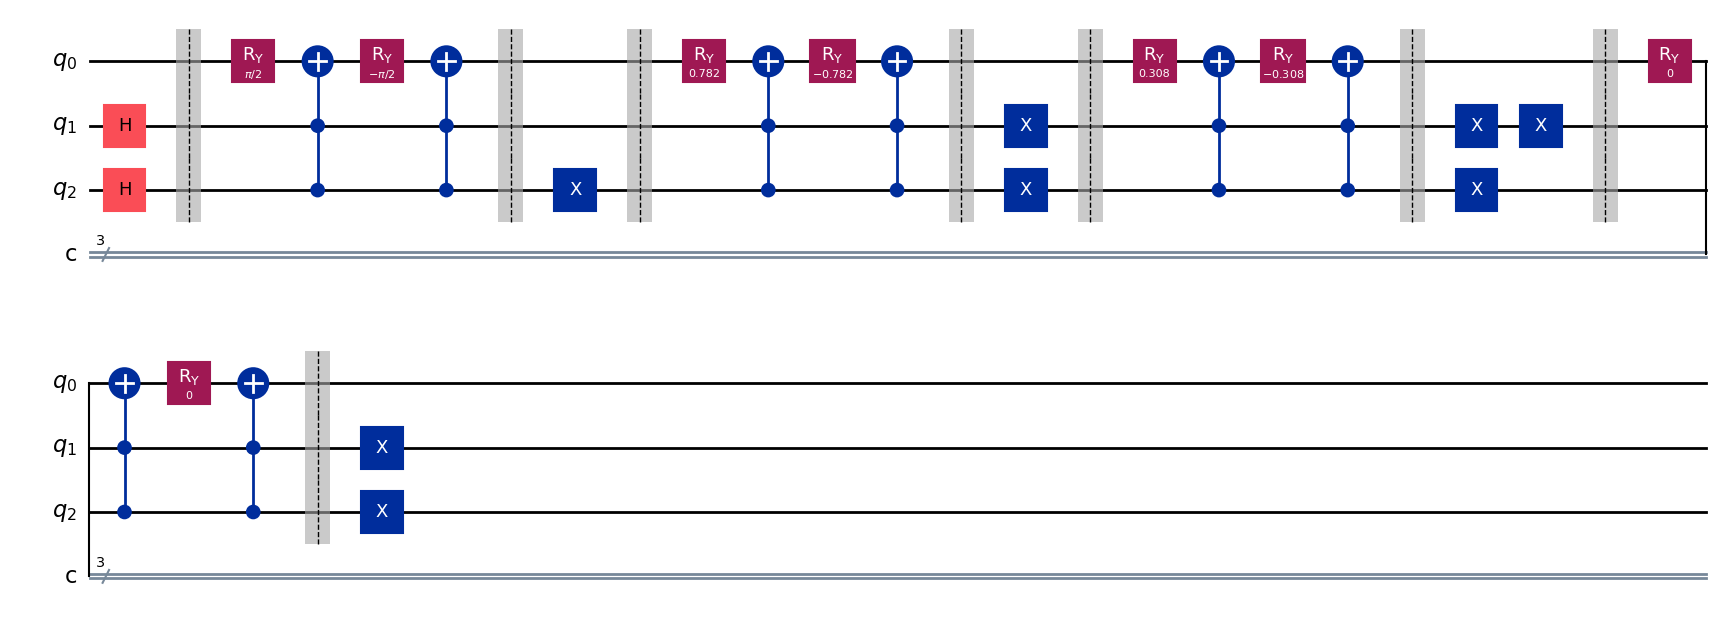

In [182]:
frqi = QuantumCircuit(3,3)
frqi.h(1)
frqi.h(2)

frqi.barrier()
frqi.mcry(np.pi,[1,2],0)
frqi.barrier()

frqi.x(2)
frqi.barrier()
frqi.mcry(127/255 * np.pi,[1,2],0)
frqi.barrier()
frqi.x(2)

frqi.x(1)
frqi.barrier()
frqi.mcry(50/255 *np.pi,[1,2],0)
frqi.barrier()
frqi.x(1)

frqi.x(1)
frqi.x(2)
frqi.barrier()
frqi.mcry(0,[1,2],0)
frqi.barrier()
frqi.x(2)
frqi.x(1)

frqi.draw('mpl')

In [175]:
state_frqi = Statevector(frqi)
state_frqi

Statevector([ 5.00000000e-01+0.j, -1.49530717e-17+0.j,  3.54640654e-01+0.j,
              3.52462773e-01+0.j,  4.76471000e-01+0.j,  1.51576337e-01+0.j,
             -1.51173088e-17+0.j,  5.00000000e-01+0.j],
            dims=(2, 2, 2))


{'010': 12510, '100': 22475, '011': 12592, '000': 25019, '111': 25077, '101': 2327}


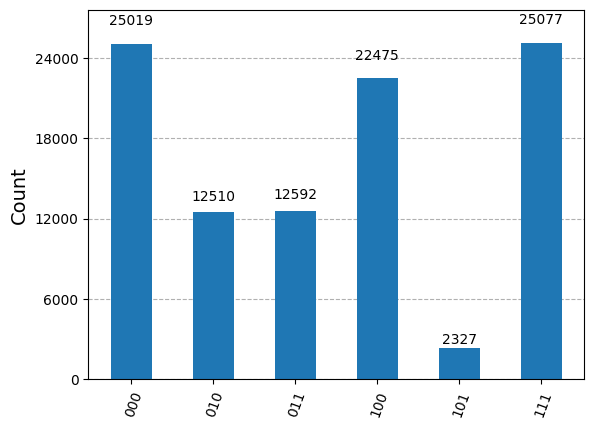

In [156]:
frqi.measure([0,1,2],[0,1,2])
simulator = Aer.get_backend('statevector_simulator')
compiled_circuit = transpile(frqi, simulator)
#job = execute(compiled_circuit, backend=simulator, shots=100000)
result = simulator.run(compiled_circuit,shots=100000).result()
counts = result.get_counts()

# 결과 출력
print(counts)
plot_histogram(counts)

{'001': 22971, '111': 24988, '110': 12344, '000': 24918, '010': 12519, '101': 2260}


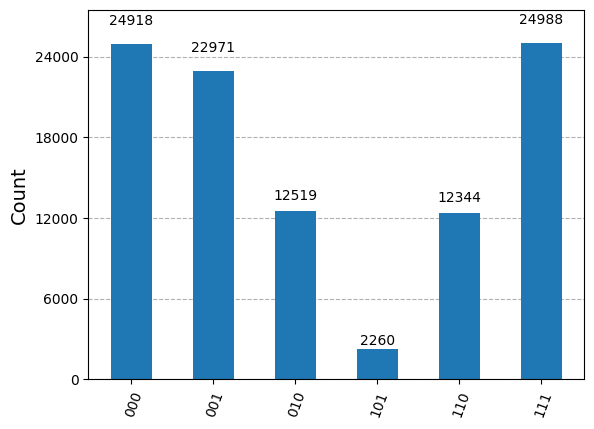

In [176]:
frqi.measure([0,1,2],[2,1,0])
simulator = Aer.get_backend('statevector_simulator')
compiled_circuit = transpile(frqi, simulator)
#job = execute(compiled_circuit, backend=simulator, shots=100000)
result = simulator.run(compiled_circuit,shots=100000).result()
counts = result.get_counts()

# 결과 출력
print(counts)
plot_histogram(counts)

In [189]:
import numpy as np
from scipy.optimize import least_squares

# 측정된 state 개수 (prob 대신 count로 변경)
count = {
    '000': 25313,
    '001': 22594,
    '010': 12541,
    '011': 0,
    '100': 0,
    '101': 2228,
    '110': 12392,
    '111': 24932
}

# 총 샷 수 (모든 state 수의 합)
total_shots = sum(count.values())

# 확률로 변환
measured_probs = {key: value / total_shots for key, value in count.items()}

# 초기 statevector 설정 (무작위 복소수 벡터)
num_qubits = 3
state_vector_init = np.random.rand(2**num_qubits) + 1j * np.random.rand(2**num_qubits)
state_vector_init /= np.linalg.norm(state_vector_init)  # 정규화

# 각 픽셀의 위상을 복원하는 함수
def estimate_angle(state_0, state_1):
    if state_0 + state_1 == 0:
        return 0  # 분모가 0이면 0으로 처리 (해당 상태 없음)
    ratio = state_0 / (state_0 + state_1)
    theta = 2 * np.arccos(np.sqrt(ratio))
    return (255 / np.pi) * theta  # 255*pi 기준 변환

# 복원된 그레이스케일 값 (각 픽셀의 위상 복원)
gray_1 = estimate_angle(count['000'], count['100'])  # '01'을 기준으로
gray_2 = estimate_angle(count['001'], count['101'])  # '10'을 기준으로
gray_3 = estimate_angle(count['010'], count['110'])  # '01'을 기준으로
gray_4 = estimate_angle(count['011'], count['111'])  # '10'을 기준으로
print(f"복원된 Grayscale 값: {gray_1:.2f}, {gray_2:.2f},{gray_3:.2f}, {gray_4:.2f}")

# 최소 제곱법을 이용해 statevector 최적화
def optimize_statevector(state_vector):
    state_vector = state_vector / np.linalg.norm(state_vector)  # 정규화
    probabilities = np.abs(state_vector)**2  # 확률 계산
    return np.array([probabilities[i] - measured_probs[list(measured_probs.keys())[i]] for i in range(len(measured_probs))])

# 최적화 수행
result = least_squares(lambda x: optimize_statevector(x + 1j * np.zeros_like(x)), state_vector_init.real)

# 최적화된 statevector
restored_statevector = result.x + 1j * np.zeros_like(result.x)
restored_statevector /= np.linalg.norm(restored_statevector)  # 정규화

print("복원된 statevector:", restored_statevector)


복원된 Grayscale 값: 0.00, 49.39,127.01, 255.00
복원된 statevector: [5.03120252e-01+0.j 4.75331452e-01+0.j 3.54132735e-01+0.j
 1.96403008e-04+0.j 8.81530466e-05+0.j 1.49264862e-01+0.j
 3.52022718e-01+0.j 4.99319525e-01+0.j]


In [186]:
from collections import defaultdict

# 모든 가능한 상태를 포함한 리스트 생성 (3 큐비트의 경우 8개의 상태)
states = ['000', '001', '010', '011', '100', '101', '110', '111']


# defaultdict를 사용하여 값이 없으면 0으로 설정
count_with_zeros = defaultdict(int, count)

# 모든 가능한 상태에 대해 0을 채우기
for state in states:
    if state not in count_with_zeros:
        count_with_zeros[state] = 0

# 결과 출력
print("최종 count with zeros:")
print(dict(count_with_zeros))

count = count_with_zeros

최종 count with zeros:
{'111': 50097, '001': 44929, '000': 50203, '110': 24887, '010': 25294, '101': 4590, '011': 0, '100': 0}


### 확률 역변환

In [168]:
import numpy as np

# 측정 결과 (샷 수: 100000)
counts = {
    '000': 25313, '001': 22594, '010': 12541, '011': 0,
    '100': 0, '101': 2228, '110': 12392, '111': 24932
}

def flip_state(state):
    return state[::-1]

# 뒤집어진 상태에 해당하는 새로운 count 생성
reversed_count = {}

for state, count_value in counts.items():
    flipped_state = flip_state(state)  # 상태를 뒤집음
    reversed_count[flipped_state] = count_value  # 뒤집은 상태에 맞는 개수 할당

sorted_reversed_count = dict(sorted(reversed_count.items()))
# 결과 출력
print("뒤집힌 상태의 개수:")
print(sorted_reversed_count)

counts = sorted_reversed_count

# 총 샷 수
total_shots = sum(counts.values())

# 확률 계산
probabilities = {state: count / total_shots for state, count in counts.items()}

# Statevector 복원 (위상은 0으로 설정)
restored_statevector = np.array([np.sqrt(prob) for prob in probabilities.values()])

# 정규화 (이론적으로는 필요 없지만, 안전하게 다시 정규화)
restored_statevector /= np.linalg.norm(restored_statevector)

# 결과 출력
print("복원된 Statevector:", restored_statevector)


뒤집힌 상태의 개수:
{'000': 25313, '001': 0, '010': 12541, '011': 12392, '100': 22594, '101': 2228, '110': 0, '111': 24932}
복원된 Statevector: [0.50312026 0.         0.35413274 0.35202273 0.47533146 0.14926487
 0.         0.49931954]


In [169]:
restored_statevector

array([0.50312026, 0.        , 0.35413274, 0.35202273, 0.47533146,
       0.14926487, 0.        , 0.49931954])

In [170]:
state_frqi.data - restored_statevector

array([-3.12026395e-03+0.j, -1.49530717e-17+0.j,  5.07910330e-04+0.j,
        4.40046914e-04+0.j,  1.13953692e-03+0.j,  2.31147180e-03+0.j,
       -1.51173088e-17+0.j,  6.80463030e-04+0.j])

### 최소 제곱법

In [172]:
import numpy as np
from scipy.optimize import least_squares

# 기존 측정된 개수 (뒤집힌 상태)
reversed_count = {
    '000': 25313,
    '001': 0,
    '010': 12541,
    '011': 12392,
    '100': 22594,
    '101': 2228,
    '110': 0,
    '111': 24932
}

# 상태를 확률로 변환하는 함수
def count_to_prob(count, total):
    return count / total

# 측정된 확률을 계산
total_measurements = sum(reversed_count.values())
probabilities = {state: count_to_prob(count, total_measurements) for state, count in reversed_count.items()}

# 초기 상태 벡터 (무작위로 초기화, 8개의 상태를 3 qubit로 표현)
# statevector는 8개 원소를 가져야 하므로, 8차원의 벡터로 시작
initial_statevector = np.ones(8) / np.sqrt(8)  # 균등 분포로 초기화

# 측정된 확률을 기반으로 최소 제곱법을 이용해 상태 벡터를 최적화하는 함수 정의
def optimize_statevector(state_vector):
    state_vector = state_vector / np.linalg.norm(state_vector)  # 정규화
    probabilities_from_state = np.abs(state_vector)**2  # 상태벡터에서 확률 추출
    # 확률과 측정된 확률 차이의 제곱합을 계산
    residuals = [probabilities_from_state[i] - probabilities[list(probabilities.keys())[i]] for i in range(len(probabilities))]
    return residuals

# 최소 제곱법을 사용하여 statevector 최적화
result = least_squares(optimize_statevector, initial_statevector)

# 최적화된 statevector
restored_statevector = result.x / np.linalg.norm(result.x)

# 최적화된 statevector 출력
print("복원된 statevector:")
print(restored_statevector)


복원된 statevector:
[5.03120247e-01 1.80955356e-04 3.54132732e-01 3.52022715e-01
 4.75331448e-01 1.49264860e-01 1.80955355e-04 4.99319521e-01]


In [173]:
state_frqi.data - restored_statevector

array([-0.00312025+0.j, -0.00018096+0.j,  0.00050792+0.j,  0.00044006+0.j,
        0.00113955+0.j,  0.00231148+0.j, -0.00018096+0.j,  0.00068048+0.j])

### 다른 회로 but 동일한 statevector

In [125]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector

# 첫 번째 회로
qc1 = QuantumCircuit(2)
qc1.h(0)
qc1.cx(0, 1)

# 두 번째 회로 (다른 방식으로 Bell State 생성)
qc2 = QuantumCircuit(2)
qc2.h(1)
qc2.cx(1, 0)

# 상태 벡터 비교
sv1 = Statevector(qc1)
sv2 = Statevector(qc2)

print("Statevector 1:", sv1)
print("Statevector 2:", sv2)


Statevector 1: Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))
Statevector 2: Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


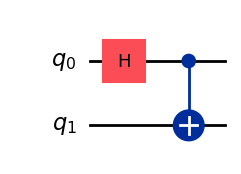

In [126]:
qc1.draw('mpl')

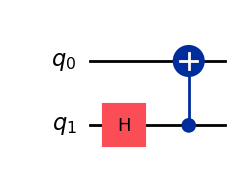

In [127]:
qc2.draw('mpl')

Measurement results for QC1: {'00': 5001, '11': 4999}
Measurement results for QC2: {'11': 4968, '00': 5032}


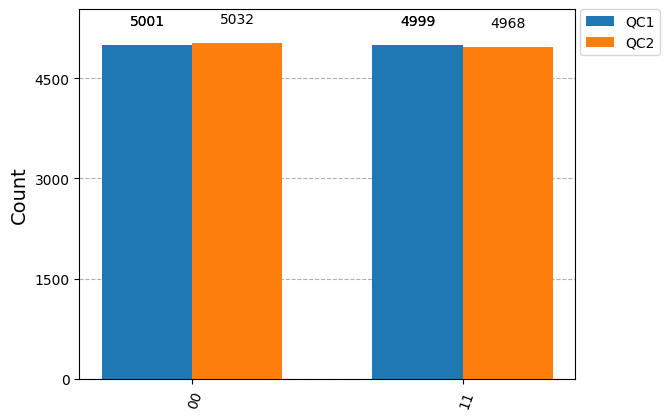

In [130]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

# 첫 번째 회로 (Hadamard + CNOT)
qc1 = QuantumCircuit(2, 2)
qc1.h(0)
qc1.cx(0, 1)
qc1.measure([0,1], [0,1])  # 측정

# 두 번째 회로 (다른 방식으로 Bell State 생성)
qc2 = QuantumCircuit(2, 2)
qc2.h(1)
qc2.cx(1, 0)
qc2.measure([0,1], [0,1])  # 측정


# 시뮬레이터 설정
simulator = Aer.get_backend("qasm_simulator")

# 첫 번째 회로 실행
compiled_qc1 = transpile(qc1, simulator)
result1 = simulator.run(compiled_qc1, shots=10000).result()

counts1 = result1.get_counts()

# 두 번째 회로 실행
compiled_qc2 = transpile(qc2, simulator)
result2= simulator.run(compiled_qc2, shots=10000).result()
counts2 = result2.get_counts()


# 측정 결과 비교
print("Measurement results for QC1:", counts1)
print("Measurement results for QC2:", counts2)

# 히스토그램으로 시각화
plot_histogram([counts1, counts2], legend=["QC1", "QC2"])


### frqi with QFT

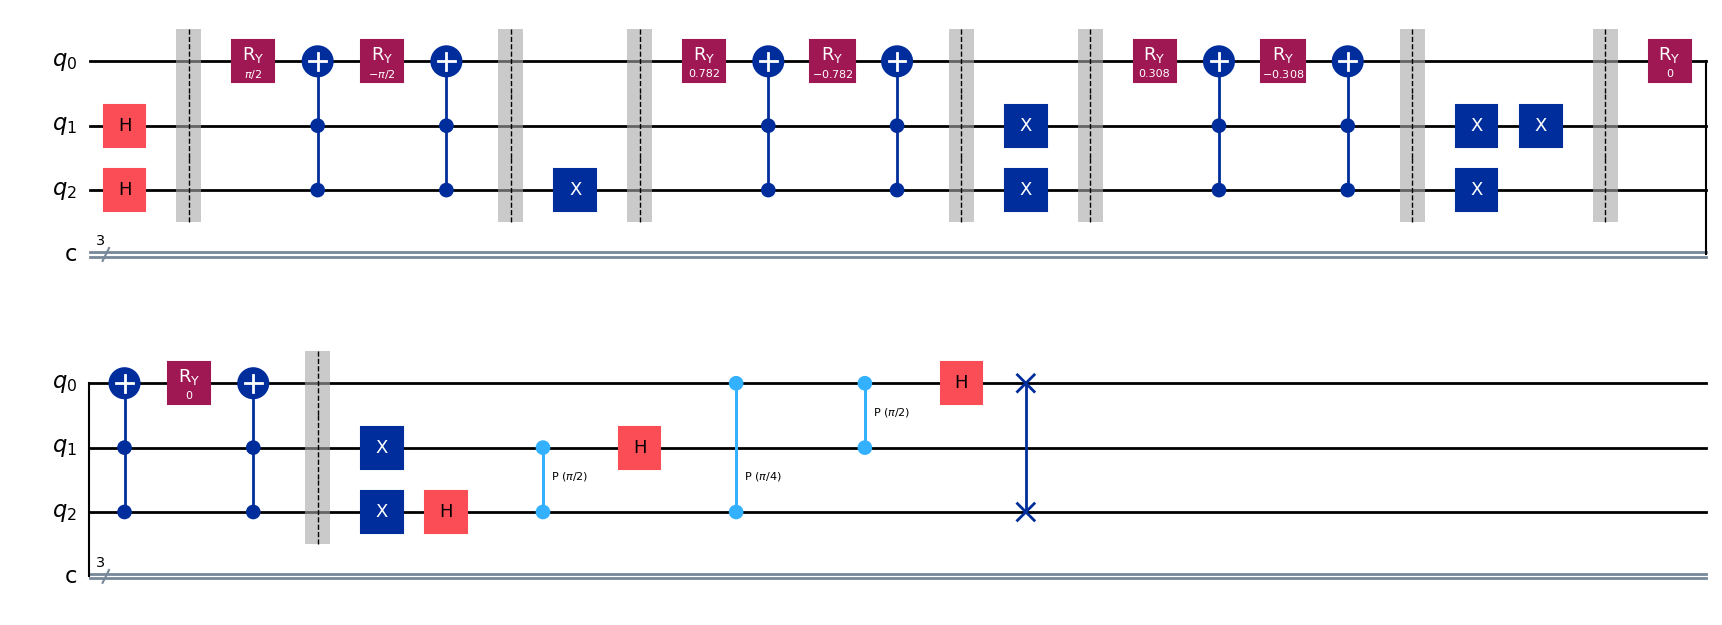

In [231]:
frqi = QuantumCircuit(3,3)
frqi.h(1)
frqi.h(2)

frqi.barrier()
frqi.mcry(np.pi,[1,2],0)
frqi.barrier()

frqi.x(2)
frqi.barrier()
frqi.mcry(127/255 * np.pi,[1,2],0)
frqi.barrier()
frqi.x(2)

frqi.x(1)
frqi.barrier()
frqi.mcry(50/255 *np.pi,[1,2],0)
frqi.barrier()
frqi.x(1)

frqi.x(1)
frqi.x(2)
frqi.barrier()
frqi.mcry(0,[1,2],0)
frqi.barrier()
frqi.x(2)
frqi.x(1)

# 2. QFT 적용
qft_circuit = QFT(num_qubits=3).decompose()  # Create and decompose QFT for 2 qubits

frqi_qft = frqi.compose(qft_circuit)
frqi_qft.draw('mpl')

{'000': 681143, '010': 109806, '101': 39770, '011': 110087, '001': 13211, '110': 40744, '100': 2606, '111': 2633}


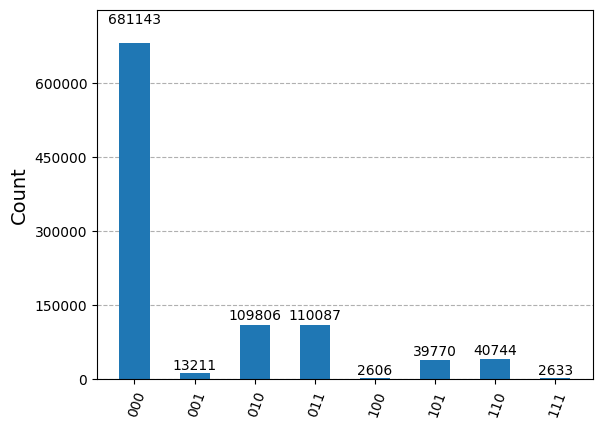

In [200]:
frqi_qft.measure([0,1,2],[2,1,0])
simulator = Aer.get_backend('statevector_simulator')
compiled_circuit = transpile(frqi_qft, simulator)
#job = execute(compiled_circuit, backend=simulator, shots=100000)
result = simulator.run(compiled_circuit,shots=1000000).result()
counts = result.get_counts()

# 결과 출력
print(counts)
plot_histogram(counts)

In [ ]:
statevector_frqi_qft = Statevector(frqi_qft).data
statevector_frqi_qft

array([0.82560047+0.j        , 0.00730898+0.05060601j,
       0.21985023-0.24780078j, 0.00932854-0.2001628j ,
       0.11563761+0.j        , 0.00932854+0.2001628j ,
       0.21985023+0.24780078j, 0.00730898-0.05060601j])

In [204]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.ignis.verification import state_tomography

frqi_qft.measure([0,1,2],[2,1,0])

# 'state_tomography'를 사용하여 회로의 상태를 추정
simulator = Aer.get_backend('qasm_simulator')
job = simulator.run(qc, shots=100000)
result = job.result()

# 측정된 counts
counts = result.get_counts(qc)
print("Counts:", counts)

# State Tomography를 위한 회로 만들기
tomography_circuits = state_tomography.state_tomography_circuits(qc, [0, 1, 2])

# 밀도 행렬 추정
tomography_results = [simulator.run(circuit, shots=100000).result() for circuit in tomography_circuits]
state_tomography_results = [result.get_counts() for result in tomography_results]

# 밀도 행렬 복원 (후처리)
density_matrix = DensityMatrix.from_tomography_data(state_tomography_results)
print("Density Matrix:", density_matrix)

# 밀도 행렬에서 상태 벡터로 복원
state_vector = density_matrix.to_statevector()
print("Restored State Vector:", state_vector)


ModuleNotFoundError: No module named 'qiskit.ignis'

In [205]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT

# 측정 결과
counts = {
    '000': 25313, '001': 22594, '010': 12541, '011': 0,
    '100': 0, '101': 2228, '110': 12392, '111': 24932
}
total_shots = sum(counts.values())

# 확률 계산
probabilities = {state: count / total_shots for state, count in counts.items()}

# 진폭 복원 (위상은 미정)
amplitudes = np.array([np.sqrt(prob) for prob in probabilities.values()])

# 정규화
amplitudes /= np.linalg.norm(amplitudes)

# Statevector 복원
restored_sv = Statevector(amplitudes)

print("🔹 복원된 진폭 기반 Statevector:", restored_sv)

### QPE 적용 ###
# 3개 데이터 큐빗 + 3개 ancilla 큐빗 사용
n_qubits = 3  # 데이터 큐빗 개수
ancilla_qubits = 3  # 위상 측정용 큐빗

qpe = QuantumCircuit(n_qubits + ancilla_qubits, ancilla_qubits)

# 초기 상태 로드 (복원된 상태 벡터를 적용)
qpe.initialize(restored_sv, range(n_qubits))

# Hadamard 적용 (Ancilla 큐빗 초기화)
for qubit in range(n_qubits, n_qubits + ancilla_qubits):
    qpe.h(qubit)

# Controlled-U 연산 (예제에서는 단순 Rz 적용)
for i in range(ancilla_qubits):
    angle = np.pi / (2 ** i)  # QPE 위상 단위 (가상의 유니타리)
    qpe.cp(angle, i, n_qubits)  # Controlled-Phase 적용

# 역 QFT 적용
qpe.append(QFT(ancilla_qubits).inverse(), range(n_qubits, n_qubits + ancilla_qubits))

# 측정
qpe.measure(range(n_qubits, n_qubits + ancilla_qubits), range(ancilla_qubits))

# 시뮬레이션 실행
sim = Aer.get_backend('aer_simulator')
qpe = transpile(qpe, sim)
#qobj = assemble(qpe, shots=10000)
result = sim.run(qpe, shots=10000).result()
counts = result.get_counts()

print("🔹 QPE 측정 결과:", counts)


🔹 복원된 진폭 기반 Statevector: Statevector([0.50312026+0.j, 0.47533146+0.j, 0.35413274+0.j,
             0.        +0.j, 0.        +0.j, 0.14926487+0.j,
             0.35202273+0.j, 0.49931954+0.j],
            dims=(2, 2, 2))
🔹 QPE 측정 결과: {'100': 4540, '000': 5460}


In [96]:
from qiskit import QuantumCircuit
import numpy as np

# 1. 상태 초기화: 첫 번째 큐빗에 Hadamard 적용
qc = QuantumCircuit(3, 3)
qc.h(0)  # 첫 번째 큐빗에 Hadamard 연산

# 2. 유니타리 연산: 첫 번째 큐빗에 U = e^(iϕ) 연산 적용
ϕ = np.pi / 4  # 예시로 ϕ = π/4로 설정
qc.rz(ϕ, 0)  # 첫 번째 큐빗에 rz(ϕ) 연산 적용

# 3. QFT 적용: 위상 추정을 위한 양자 푸리에 변환
qc.h(1)
qc.cx(0, 1)
qc.h(2)
qc.cx(0, 2)

# 4. 측정
qc.measure([0, 1, 2], [0, 1, 2])

# 5. 시뮬레이터 실행
simulator = Aer.get_backend('qasm_simulator')
qc_tran=transpile(qc,simulator)
result = simulator.run(qc_tran, shots=100000).result()
counts = result.get_counts()

# 결과 출력
print("측정 결과:", counts)

# 이 결과에서 위상 정보 (ϕ)를 추정할 수 있음


측정 결과: {'011': 12492, '001': 12587, '101': 12247, '010': 12769, '100': 12460, '110': 12552, '000': 12402, '111': 12491}


In [98]:
import numpy as np
from scipy.optimize import minimize

# 📌 주어진 측정 결과 (Counts)
counts = {
    '000': 25313, '001': 22594, '010': 12541, '011': 0,
    '100': 0, '101': 2228, '110': 12392, '111': 24932
}

# 📌 측정된 확률로 변환
total_shots = sum(counts.values())
probabilities = {state: count / total_shots for state, count in counts.items()}

# 📌 초기 statevector 설정 (랜덤 위상 & 진폭)
num_states = len(probabilities)
initial_params = np.random.rand(2 * num_states)  # 진폭(num_states) + 위상(num_states)

# 📌 손실 함수 정의 (최소화할 대상)
def loss_function(params):
    amplitudes = params[:num_states]  # 진폭 (양수)
    phases = params[num_states:]      # 위상 (-pi ~ pi)
    
    # 정규화
    amplitudes /= np.linalg.norm(amplitudes)
    
    # 복소수 형태의 statevector 복원
    reconstructed_sv = amplitudes * np.exp(1j * phases)
    
    # 복원된 확률 계산
    reconstructed_probs = np.abs(reconstructed_sv) ** 2
    
    # 측정된 확률과 비교하여 오차(loss) 계산 (L2 Norm 사용)
    loss = np.sum((reconstructed_probs - np.array(list(probabilities.values())))**2)
    return loss

# 📌 최적화 실행 (SPSA, COBYLA, BFGS 등 사용 가능)
result = minimize(loss_function, initial_params, method='BFGS')

# 📌 최적화된 statevector 복원
optimized_amplitudes = result.x[:num_states]
optimized_phases = result.x[num_states:]

# 정규화
optimized_amplitudes /= np.linalg.norm(optimized_amplitudes)

# 최종 복원된 statevector
restored_statevector = optimized_amplitudes * np.exp(1j * optimized_phases)

# 결과 출력
print("복원된 statevector:", restored_statevector)


복원된 statevector: [ 0.50141705+0.04123167j  0.4731792 +0.04491481j  0.23860451+0.26164818j
 -0.00394439-0.00533885j  0.00592512+0.00542334j  0.12655799+0.07904809j
  0.34878033+0.04746732j  0.45175133+0.21264732j]


In [101]:
import numpy as np
from qiskit import QuantumCircuit,  assemble
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import state_fidelity, DensityMatrix
from qiskit_experiments.library.tomography import StateTomography
from qiskit_experiments.framework import ExperimentData

# 📌 주어진 측정 결과 (Counts)
counts = {
    '000': 25313, '001': 22594, '010': 12541, '011': 0,
    '100': 0, '101': 2228, '110': 12392, '111': 24932
}

# 📌 QST를 위한 회로 생성 (3 Qubit 기준)
num_qubits = 3
qst_circuit = QuantumCircuit(num_qubits)

# QST 실험 수행 (여러 기저에서 측정)
qst_experiment = StateTomography(qst_circuit)

# QST 실험 실행 (시뮬레이터 사용)
simulator = Aer.get_backend('qasm_simulator')
qst_result = qst_experiment.run(simulator).block_for_results()

# 📌 복원된 밀도 행렬 (Density Matrix)
reconstructed_rho = qst_result.analysis_results("state").value

# 📌 복원된 상태 벡터 추출 (고유값 분해)
eigvals, eigvecs = np.linalg.eigh(reconstructed_rho)

# 가장 큰 고유값에 해당하는 고유 벡터 선택
restored_statevector = eigvecs[:, np.argmax(eigvals)]

# 📌 복원된 StateVector 출력
print("복원된 statevector:", restored_statevector)


복원된 statevector: [-0.99976476+0.j         -0.00388354+0.00152658j  0.0103991 +0.00145687j
 -0.00334051-0.00301006j  0.0093978 +0.00308891j  0.00701239+0.00065238j
 -0.00497609-0.00154912j -0.01197167+0.00214197j]


In [207]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

# 📌 1️⃣ 초기 상태를 생성하는 양자 회로
qc = QuantumCircuit(3)
qc.h(1)
qc.h(2)
qc.mcry(np.pi, [1,2], 0)
qc.x(2)
qc.mcry(127/255 * np.pi, [1,2], 0)
qc.x(2)
qc.x(1)
qc.mcry(50/255 * np.pi, [1,2], 0)
qc.x(1)
qc.x(1)
qc.x(2)
qc.mcry(0, [1,2], 0)
qc.x(2)
qc.x(1)

# 📌 2️⃣ QPE를 위한 보조 함수 정의
def qpe_circuit(target_circuit, num_qubits):
    """
    QPE를 위한 회로 생성
    target_circuit: 위상을 측정할 유니타리 연산이 포함된 회로
    num_qubits: 위상을 측정할 시스템의 큐비트 수
    """
    qpe = QuantumCircuit(num_qubits + 1, num_qubits)  # 보조 큐비트 포함
    
    # Hadamard 적용하여 균등한 상태 준비
    for qubit in range(num_qubits):
        qpe.h(qubit)
    
    # Target 회로(위상 정보가 있는 유니타리 연산) 적용
    target_instruction = target_circuit.to_instruction()
    qpe.append(target_instruction, list(range(num_qubits + 1)))  # 올바른 큐비트 연결

    # Inverse QFT 적용 (QFT 역변환을 해야 정확한 위상 측정 가능)
    for i in range(num_qubits // 2):
        qpe.swap(i, num_qubits - i - 1)

    # 측정
    qpe.measure(range(num_qubits), range(num_qubits))
    
    return qpe

# 📌 3️⃣ QPE 회로 실행
qpe_qc = qpe_circuit(qc, 2)

# 📌 4️⃣ QPE 회로 시뮬레이션
simulator = Aer.get_backend('qasm_simulator')
t_qc = transpile(qpe_qc, simulator)

qpe_result = simulator.run(t_qc, shots=10000).result()
qpe_counts = qpe_result.get_counts()

# 📌 5️⃣ 출력
print("QPE 측정 결과:", qpe_counts)


QPE 측정 결과: {'00': 3682, '10': 6318}


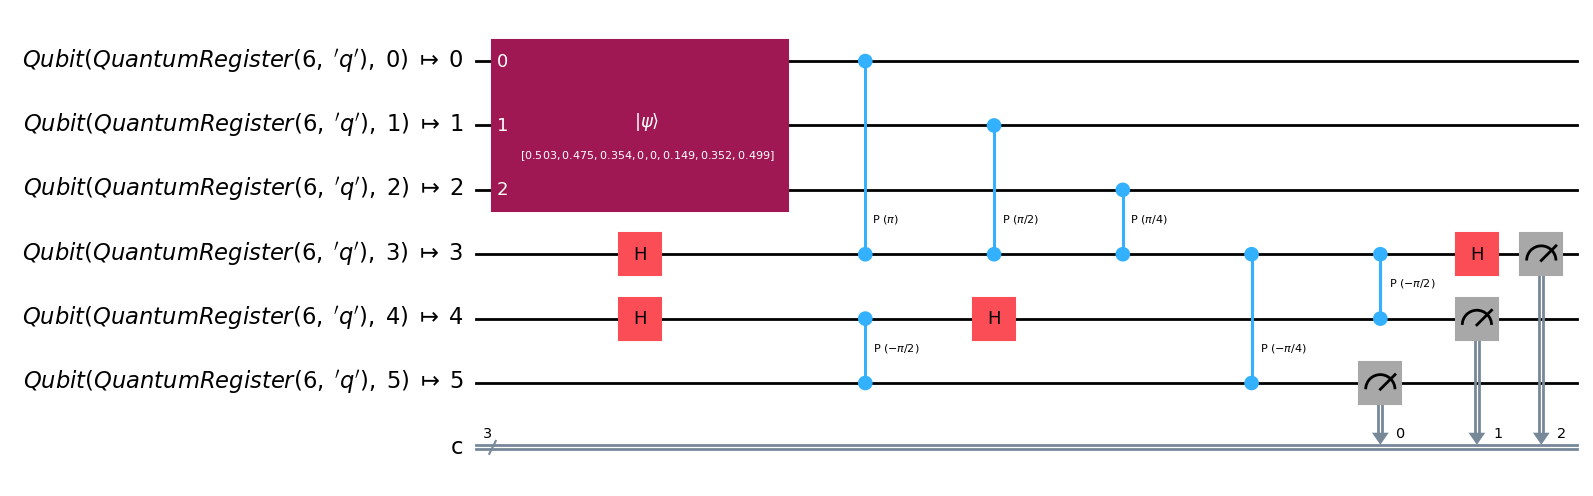

In [208]:
qpe.draw('mpl')

In [230]:
def reverse_and_sort_counts(counts):
    """
    측정된 state들을 비트 순서를 반대로 바꾼 후 정렬하여 저장하는 함수
    """
    reversed_counts = {}

    # 1. 비트 순서 뒤집기
    for state, value in counts.items():
        reversed_state = state[::-1]  # 비트 뒤집기
        reversed_counts[reversed_state] = value

    # 2. 정렬 (state를 2진수 값 기준으로 정렬)
    sorted_counts = dict(sorted(reversed_counts.items(), key=lambda x: int(x[0], 2)))

    return sorted_counts

# 예제 측정 결과
counts = {
    '000': 25313,
    '001': 22594,
    '010': 12541,
    '011': 0,
    '100': 0,
    '101': 2228,
    '110': 12392,
    '111': 24932
}

# 함수 실행
sorted_reversed_counts = reverse_and_sort_counts(counts)

# 결과 출력
print(sorted_reversed_counts)


{'000': 25313, '001': 0, '010': 12541, '011': 12392, '100': 22594, '101': 2228, '110': 0, '111': 24932}


In [74]:
state_frqi

Statevector([ 5.00000000e-01+0.j, -1.49530717e-17+0.j,  3.54640654e-01+0.j,
              3.52462773e-01+0.j,  4.76471000e-01+0.j,  1.51576337e-01+0.j,
             -1.51173088e-17+0.j,  5.00000000e-01+0.j],
            dims=(2, 2, 2))


In [75]:
error = np.array(state_frqi)-restored_statevector
error

array([-0.01256549+0.j, -0.49199223+0.j,  0.01295989+0.j,  0.35246269+0.j,
        0.47647092+0.j,  0.15157821+0.j, -0.34126627+0.j, -0.01187093+0.j])

Before qft =  Statevector([ 5.00000000e-01+0.j, -1.49530717e-17+0.j,  3.54640654e-01+0.j,
              3.52462773e-01+0.j,  4.76471000e-01+0.j,  1.51576337e-01+0.j,
             -1.51173088e-17+0.j,  5.00000000e-01+0.j],
            dims=(2, 2, 2))


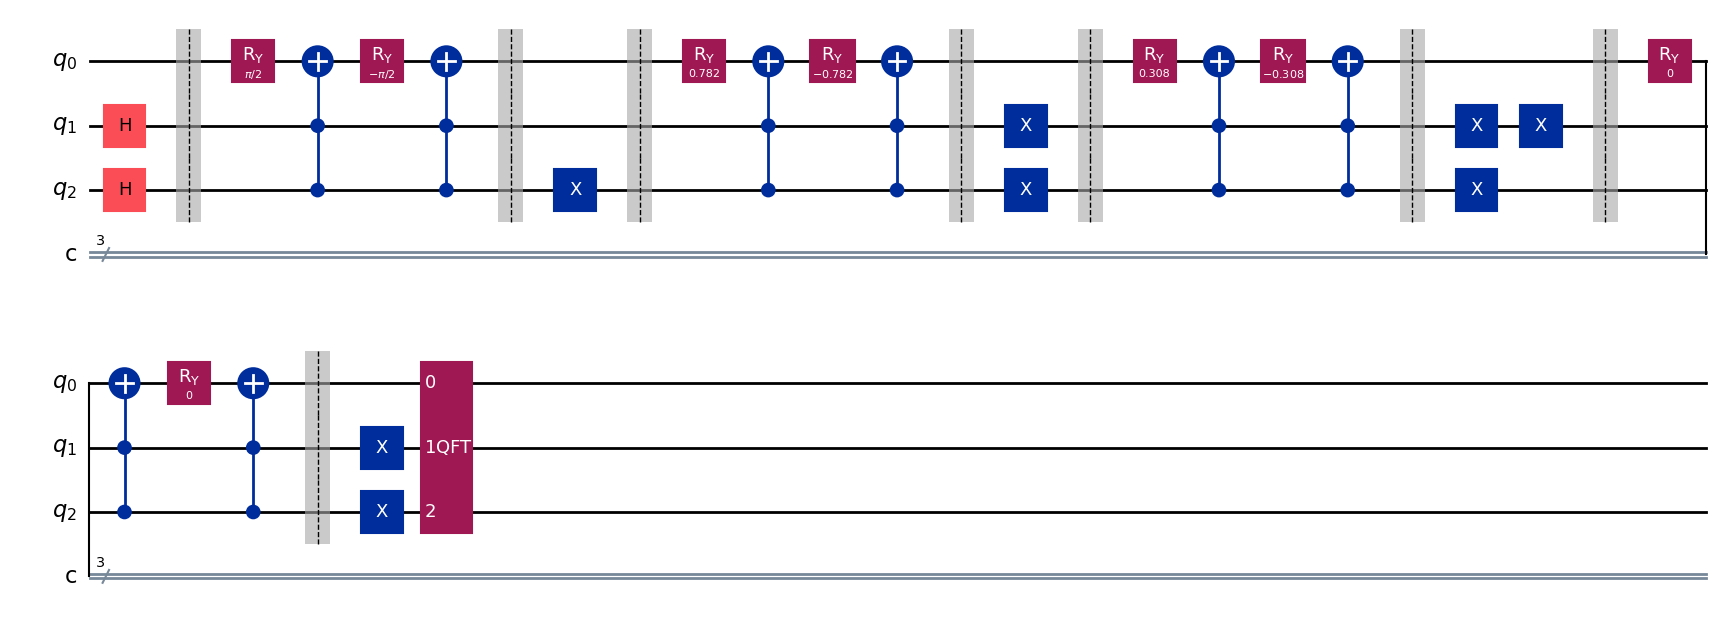

In [40]:
frqi_state = Statevector(frqi)
print("Before qft = ", frqi_state)


qft_circuit = QFT(num_qubits=3, do_swaps=False).decompose()  # Create and decompose QFT for 2 qubits
#frqi_qft = frqi.compose(qft_circuit)
frqi.append(qft_circuit,[0,1,2])
#frqi.h([0,1,2])
frqi.draw('mpl')

In [41]:
frqi_qft_state = Statevector(frqi)

frqi_qft_state_classic = frqi_qft_state.data
print("After qft =",frqi_qft_state_classic)

After qft = [0.82560047+0.j         0.11563761+0.j         0.21985023-0.24780078j
 0.21985023+0.24780078j 0.00730898+0.05060601j 0.00932854+0.2001628j
 0.00932854-0.2001628j  0.00730898-0.05060601j]


In [240]:
idft_qft_frqi_state_classic = np.fft.fft(frqi_qft_state_classic)
idft_qft_frqi_state_classic = 0.5*np.array(idft_qft_frqi_state_classic)
idft_qft_frqi_state_classic

array([0.70710678+2.77555756e-17j, 0.38250251-4.19565433e-01j,
       0.30334936+3.00381326e-01j, 0.50525798+1.43498195e-01j,
       0.35498143-3.97357558e-01j, 0.388151  +1.58437726e-01j,
       0.30038133+1.98188261e-01j, 0.36067149+1.64174820e-02j])

In [258]:
frqi_qft_state = Statevector(qc)

frqi_qft_state_classic = frqi_qft_state.data
print("After qft =",frqi_qft_state_classic)

After qft = [ 0.82560047+0.j         -0.02795055+0.j         -0.04527157+0.07322212j
 -0.04527157-0.07322212j  0.30232117-0.00958792j  0.05123223+0.23932314j
  0.05123223-0.23932314j  0.30232117+0.00958792j]


In [259]:
idft_qft_frqi_state_classic = np.fft.fft(frqi_qft_state_classic)
idft_qft_frqi_state_classic = 0.5*np.array(idft_qft_frqi_state_classic)
idft_qft_frqi_state_classic

array([ 0.70710678+0.j        ,  0.39891826+0.14859805j,
        0.71245916+0.19514051j, -0.10342151+0.16276573j,
        0.42677551-0.17568894j,  0.43690631-0.04250633j,
        0.40950182-0.03862741j,  0.31415555-0.2496816j ])

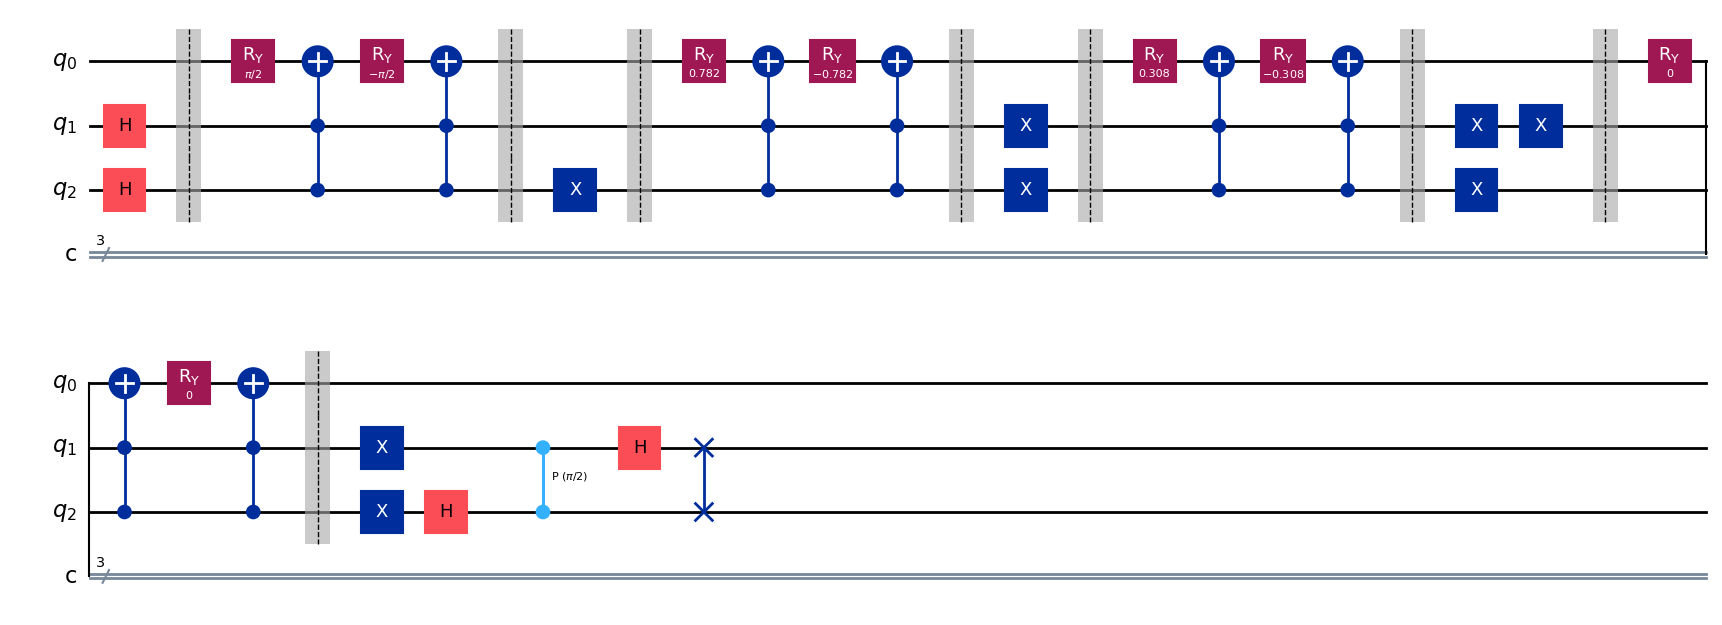

In [293]:
frqi_qft = QuantumCircuit(3,3)
frqi_qft.h(1)
frqi_qft.h(2)

frqi_qft.barrier()
frqi_qft.mcry(np.pi,[1,2],0)
frqi_qft.barrier()

frqi_qft.x(2)
frqi_qft.barrier()
frqi_qft.mcry(127/255 * np.pi,[1,2],0)
frqi_qft.barrier()
frqi_qft.x(2)

frqi_qft.x(1)
frqi_qft.barrier()
frqi_qft.mcry(50/255 *np.pi,[1,2],0)
frqi_qft.barrier()
frqi_qft.x(1)

frqi_qft.x(1)
frqi_qft.x(2)
frqi_qft.barrier()
frqi_qft.mcry(0,[1,2],0)
frqi_qft.barrier()
frqi_qft.x(2)
frqi_qft.x(1)

qft_circuit = QFT(num_qubits=2).decompose()
frqi_qft = frqi_qft.compose(qft_circuit,qubits=[1,2])
frqi_qft.draw('mpl')


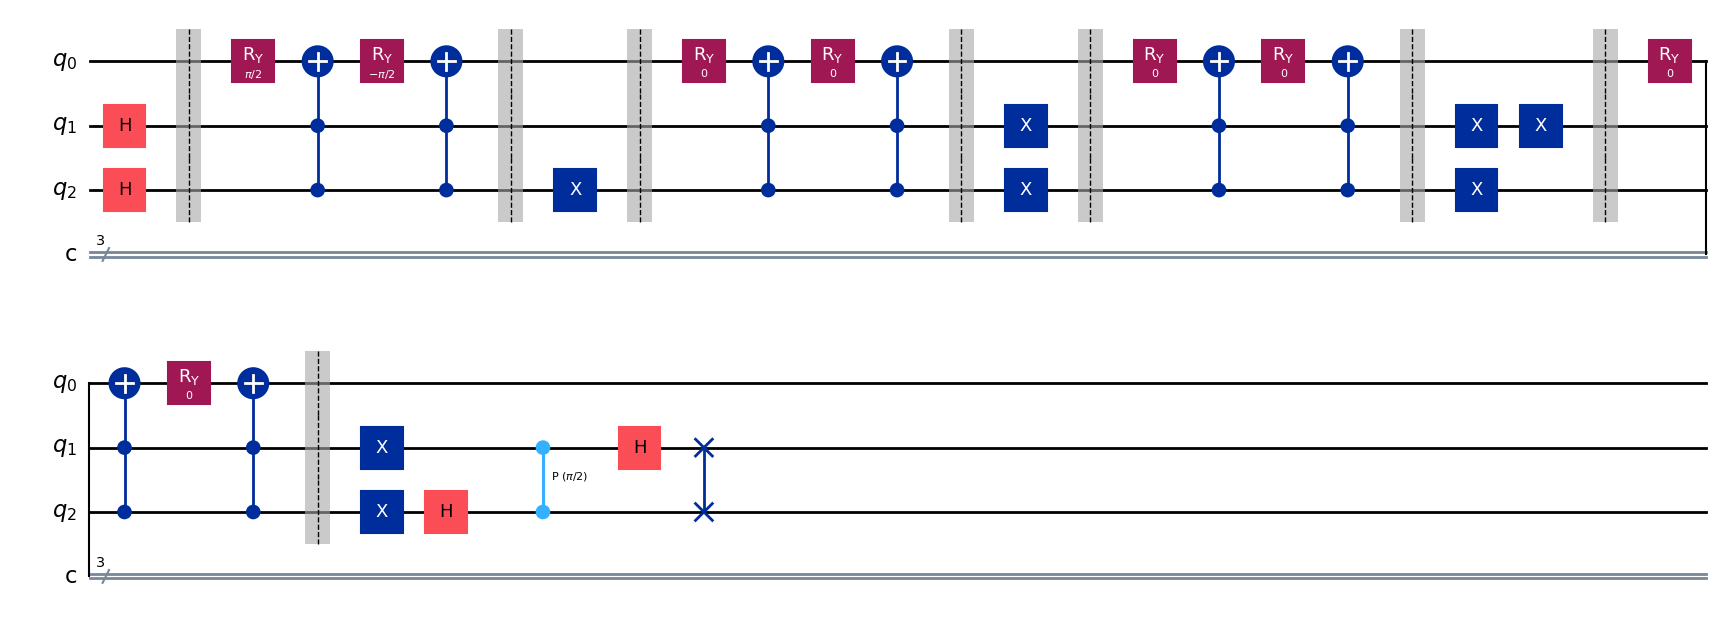

In [294]:
filter_qft = QuantumCircuit(3,3)
filter_qft.h(1)
filter_qft.h(2)

filter_qft.barrier()
filter_qft.mcry(np.pi,[1,2],0)
filter_qft.barrier()

filter_qft.x(2)
filter_qft.barrier()
filter_qft.mcry(0 * np.pi,[1,2],0)
filter_qft.barrier()
filter_qft.x(2)

filter_qft.x(1)
filter_qft.barrier()
filter_qft.mcry(0 *np.pi,[1,2],0)
filter_qft.barrier()
filter_qft.x(1)

filter_qft.x(1)
filter_qft.x(2)
filter_qft.barrier()
filter_qft.mcry(0,[1,2],0)
filter_qft.barrier()
filter_qft.x(2)
filter_qft.x(1)


qft_circuit = QFT(num_qubits=2).decompose()
filter_qft = filter_qft.compose(qft_circuit,qubits=[1,2])
filter_qft.draw('mpl')

|frqi> =  Statevector([ 0.66555583+0.j        ,  0.50201956+0.j        ,
              0.0117645 +0.17732033j, -0.07578817-0.07376861j,
              0.31091517+0.j        , -0.35044322+0.j        ,
              0.0117645 -0.17732033j, -0.07578817+0.07376861j],
            dims=(2, 2, 2))
|filter> =  Statevector([ 7.5000000e-01+0.j  ,  2.5000000e-01+0.j  ,
              1.5308085e-17+0.25j, -1.5308085e-17-0.25j,
              2.5000000e-01+0.j  , -2.5000000e-01+0.j  ,
             -1.5308085e-17-0.25j,  1.5308085e-17+0.25j],
            dims=(2, 2, 2))
Element-wise product result =  Statevector([ 0.49916687+0.j        ,  0.12550489+0.j        ,
             -0.04433008+0.00294112j, -0.01844215+0.01894704j,
              0.07772879+0.j        ,  0.0876108 -0.j        ,
             -0.04433008-0.00294112j, -0.01844215-0.01894704j],
            dims=(2, 2, 2))


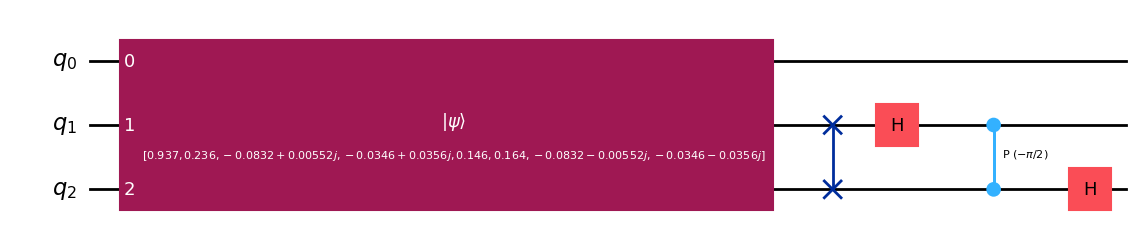

In [295]:
state_frqi_qft = Statevector(frqi_qft)
state_filter_qft = Statevector(filter_qft) 
print("|frqi> = ", state_frqi_qft)
print("|filter> = ", state_filter_qft)

element_wise = state_frqi_qft.data * state_filter_qft.data
element_wise_result_state = Statevector(element_wise)

print("Element-wise product result = ", element_wise_result_state)
coeff = np.absolute(element_wise_result_state.data[0])
element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)
element_wise_result = QuantumCircuit(3)
element_wise_result.initialize(element_wise_result_state)

iqft_circuit = QFT(num_qubits=2,inverse=True).decompose() 

elemen_wise_result_qft = element_wise_result.compose(iqft_circuit,qubits=[1,2])
elemen_wise_result_qft.draw('mpl')

In [296]:
state_result_qft = Statevector(elemen_wise_result_qft)
state_result_qft = state_result_qft  #* coeff * np.sqrt(2)
state_result_qft

Statevector([ 4.58093087e-01+9.96268477e-18j,
              1.65351311e-01+3.89286766e-18j,
              4.00938661e-01+1.04282378e-18j,
              7.11092006e-02+9.86899895e-19j,
              6.24466110e-01-9.96268477e-18j,
              2.34565638e-01-3.89286766e-18j,
              3.89900472e-01-1.04282378e-18j,
             -1.04530711e-17-9.86899895e-19j],
            dims=(2, 2, 2))


In [297]:
amp = {}
for i, value in enumerate(state_result_qft.data):
    # 이진법 키를 생성
    binary_key = format(i, '03b')  # 3자리 이진법으로 표현
    amp[binary_key] = value

# 뒤집은 키로 새 딕셔너리 만들기
amp_reversed = {}
for key, value in amp.items():
    reversed_key = key[::-1]  # 키 뒤집기
    amp_reversed[reversed_key] = value

# 딕셔너리 정렬
amp = dict(sorted(amp_reversed.items()))
amp

{'000': (0.45809308720752556+9.962684765554975e-18j),
 '001': (0.6244661099745554-9.962684765554975e-18j),
 '010': (0.40093866122804367+1.0428237750661241e-18j),
 '011': (0.38990047151354146-1.0428237750661241e-18j),
 '100': (0.1653513109775198+3.8928676637719366e-18j),
 '101': (0.2345656384610139-3.8928676637719366e-18j),
 '110': (0.0711092005544897+9.86899895310336e-19j),
 '111': (-1.045307113650588e-17-9.86899895310336e-19j)}

In [298]:
def estimate_angle(state_0, state_1):
    if state_0 + state_1 == 0:
        return 0  # 분모가 0이면 0으로 처리 (해당 상태 없음)
    ratio = state_0 / (state_0 + state_1)
    theta = 2 * np.arccos(np.sqrt(ratio))
    return (255 / np.pi) * theta  # 255*pi 기준 변환

# 복원된 그레이스케일 값 (각 픽셀의 위상 복원)
gray_1 = estimate_angle(amp['000'], amp['100'])  # '01'을 기준으로
gray_2 = estimate_angle(amp['001'], amp['101'])  # '10'을 기준으로
gray_3 = estimate_angle(amp['010'], amp['110'])  # '01'을 기준으로
gray_4 = estimate_angle(amp['011'], amp['111'])  # '10'을 기준으로
print(f"복원된 Grayscale 값: {gray_1:.2f}, {gray_2:.2f},{gray_3:.2f}, {gray_4:.2f}")

복원된 Grayscale 값: 87.83+0.00j, 89.26-0.00j,64.71+0.00j, 0.00-0.00j


In [299]:
sv_frqi = Statevector.from_instruction(frqi)
print("FRQI Statevector:", sv_frqi)

FRQI Statevector: Statevector([ 5.00000000e-01+0.j, -1.49530717e-17+0.j,  3.54640654e-01+0.j,
              3.52462773e-01+0.j,  4.76471000e-01+0.j,  1.51576337e-01+0.j,
             -1.51173088e-17+0.j,  5.00000000e-01+0.j],
            dims=(2, 2, 2))


input image amp =  [0.         0.17287279 0.43909689 0.88165124]
|image> =  Statevector([ 0.74681047+0.j        , -0.21954845-0.35438923j,
             -0.30771357+0.j        , -0.21954845+0.35438923j],
            dims=(2, 2))
|er> =  Statevector([ 5.000000e-01+0.j , -3.061617e-17-0.5j, -5.000000e-01+0.j ,
              3.061617e-17+0.5j],
            dims=(2, 2))
Element-wise product result =  Statevector([ 0.37340523+0.j        , -0.17719461+0.10977422j,
              0.15385679-0.j        , -0.17719461-0.10977422j],
            dims=(2, 2))


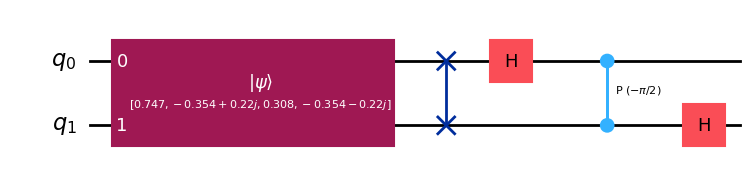

In [180]:
im=QuantumCircuit(2)
ker = QuantumCircuit(2)
image_amp = np.array([0,50,127,255] / np.sqrt(50**2+127**2+255**2))
print("input image amp = ",image_amp)
ker_amp = np.array([0,0,0,1] / np.sqrt(0**2+0**2+1**2))

im.initialize(image_amp,[0,1])
ker.initialize(ker_amp,[0,1])

qft_circuit = QFT(num_qubits=2).decompose() 

image_qft = im.compose(qft_circuit)
ker_qft = ker.compose(qft_circuit)

state_image_qft = Statevector(image_qft)
state_ker_qft = Statevector(ker_qft) 
print("|image> = ", state_image_qft)
print("|er> = ", state_ker_qft)

element_wise = state_image_qft.data * state_ker_qft.data
element_wise_result_state = Statevector(element_wise)

print("Element-wise product result = ", element_wise_result_state)
coeff = np.absolute(element_wise_result_state.data[0])
element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)
element_wise_result = QuantumCircuit(2)
element_wise_result.initialize(element_wise_result_state)

iqft_circuit = QFT(num_qubits=2,inverse=True).decompose() 

elemen_wise_result_qft = element_wise_result.compose(iqft_circuit)
elemen_wise_result_qft.draw('mpl')

In [187]:
state_result_qft = Statevector(elemen_wise_result_qft)
state_result_qft = state_result_qft  * coeff * np.sqrt(2)*2
print(np.round(state_result_qft,3))

[0.183+0.j 0.464-0.j 0.931-0.j 0.   +0.j]


In [190]:
np_iqft = np.array(state_result_qft)
print(np.round(np_iqft*np.sqrt(50**2+127**2+255**2)),4)

[ 53.+0.j 134.-0.j 269.-0.j   0.+0.j] 4


In [311]:
image_amp

array([0.        , 0.17287279, 0.43909689, 0.88165124])

In [310]:
amp = {}
for i, value in enumerate(state_result_qft.data):
    # 이진법 키를 생성
    binary_key = format(i, '02b')  # 3자리 이진법으로 표현
    amp[binary_key] = value

amp

{'00': (0.0912897558612226+3.2337277177178743e-17j),
 '01': (0.2318759798875053-2.1772436152489962e-18j),
 '10': (0.465577754892235-3.2337277177178743e-17j),
 '11': (4.130888422338248e-17+2.1772436152489962e-18j)}

[ 0.80178373+0.j         -0.26726124-0.26726124j -0.26726124+0.j
 -0.26726124+0.26726124j]


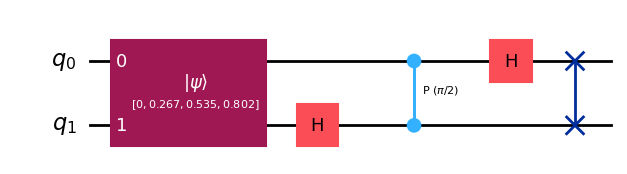

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import dft

# 1. Amplitude Encoding을 위한 상태 벡터
data = np.array([0, 1, 2, 3], dtype=complex)
norm = np.linalg.norm(data)
state_vector = data / norm  # Normalize to get quantum state

# 2. Quantum Circuit 초기화 (2 qubits)
num_qubits = 2
qc = QuantumCircuit(num_qubits)

# 3. State Preparation (Amplitude Encoding)
qc.initialize(state_vector, [0, 1])

#qc.h(0)  # Hadamard
#qc.cp(np.pi/2, 0, 1)  # Controlled Phase

# Swap 필요 없음 (1 qubit QFT이므로)

# 열 기준 QFT 적용 (q1에 대해 QFT)
qc.h(1)  # Hadamard
qc.cp(np.pi/2, 1, 0)  # Controlled Phase
qc.h(0)
qc.swap(0,1)


print(Statevector(qc).data)
qc.draw("mpl")




[0.        +0.j 0.53452248+0.j 0.26726124+0.j 0.80178373+0.j]


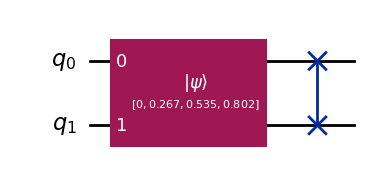

In [328]:
data = np.array([0, 1, 2, 3], dtype=complex)
norm = np.linalg.norm(data)
state_vector = data / norm  # Normalize to get quantum state

# 2. Quantum Circuit 초기화 (2 qubits)
num_qubits = 2
qc = QuantumCircuit(num_qubits)

# 3. State Preparation (Amplitude Encoding)
qc.initialize(state_vector, [0, 1])

# 4. 행 기준으로 1D QFT 적용
qc.swap(0,1)
# 5. 열 기준으로 1D QFT 적용 (같은 방식으로 적용)
#    여기서는 2D 구조가 단순하므로 같은 QFT 연산을 반복 적용
#qc.append(QFT(num_qubits).to_instruction(), [0, 1])
print(Statevector(qc).data)
qc.draw('mpl')

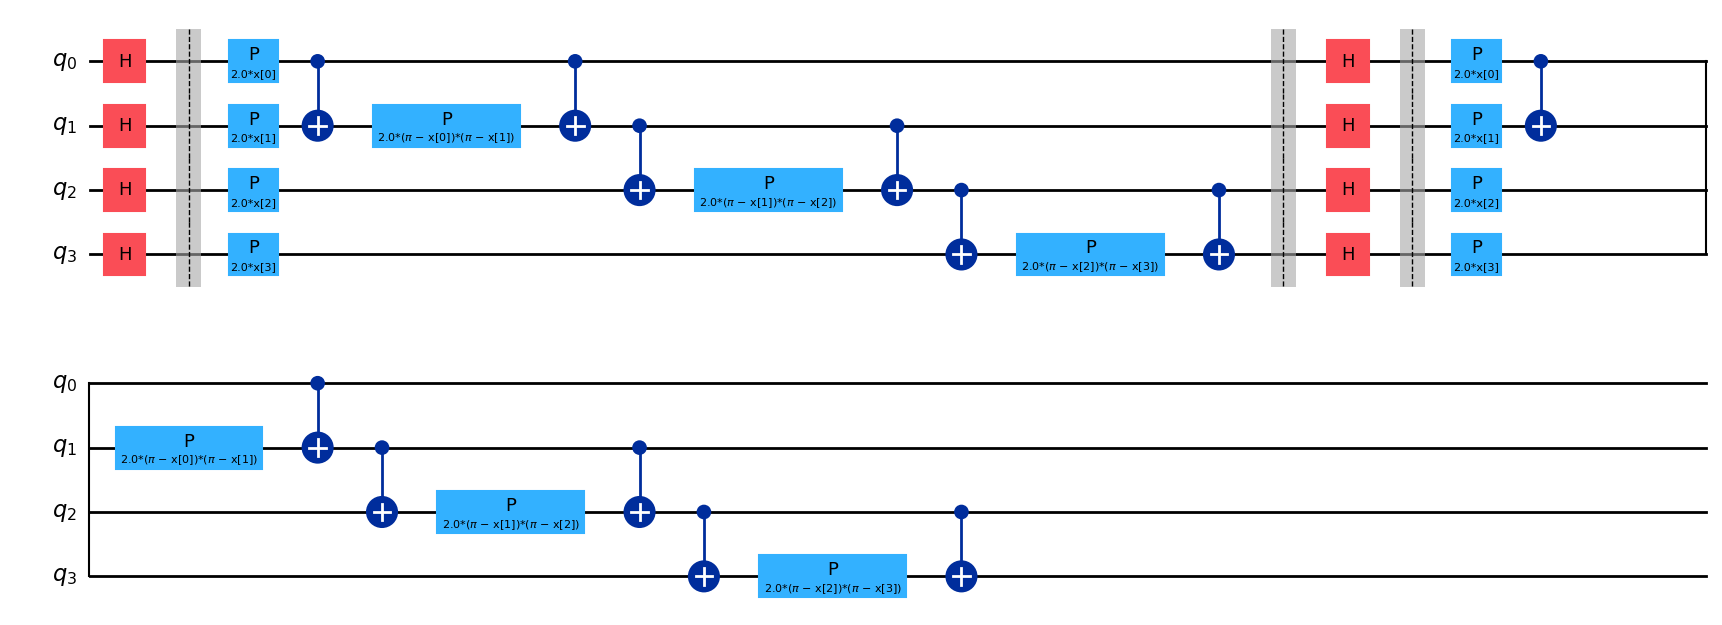

In [13]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit import QuantumCircuit

# 3개의 qubit을 사용하여 ZZFeatureMap 생성 (데이터 차원 = 3)
feature_map = ZZFeatureMap(feature_dimension=3, entanglement='linear', insert_barriers=True).decompose()

# Quantum Circuit 확인
feature_map.draw('mpl')

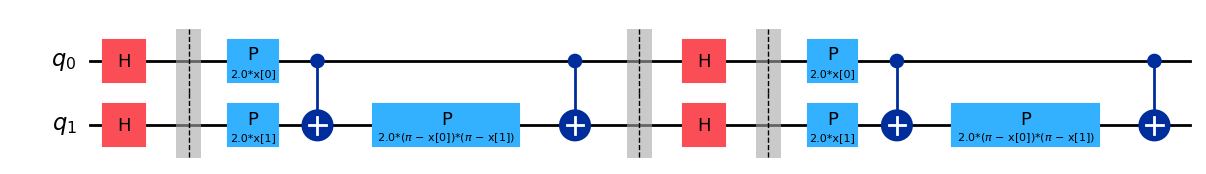

In [15]:
feature_map = ZZFeatureMap(feature_dimension=2, entanglement='linear', insert_barriers=True).decompose()
feature_map.draw('mpl')

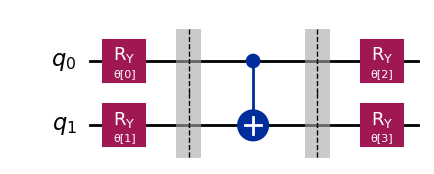

In [19]:
ansatz = RealAmplitudes(num_qubits=2, entanglement='linear', reps=1, insert_barriers=True).decompose()
ansatz.draw('mpl')

In [52]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
import torch.optim as optim

# 1️⃣ ZZFeatureMap (고정된 Feature Encoding)
feature_map = ZZFeatureMap(feature_dimension=2, entanglement='linear')

# 2️⃣ Trainable Ansatz (학습 가능한 파라미터 포함)
ansatz = RealAmplitudes(num_qubits=2, entanglement='linear', reps=1)

# 3️⃣ 최종 QNN 모델 생성 (안전한 형태로 Circuit을 구성하고 파라미터들 명시)
circuit = feature_map.compose(ansatz)  # Feature Map과 Ansatz를 합침

# SamplerQNN은 `circuit`을 입력으로 받으며, `input_params`와 `weight_params`를 명시적으로 지정
qnn = SamplerQNN(
    circuit=circuit,
    input_params=feature_map.parameters,  # Feature Map의 입력 파라미터
    weight_params=ansatz.parameters       # Ansatz의 학습 가능한 파라미터
)

# 4️⃣ PyTorch 신경망으로 변환
qnn_torch = TorchConnector(qnn)

# 5️⃣ Optimizer 설정
optimizer = optim.Adam(qnn_torch.parameters(), lr=0.01)

# 6️⃣ 샘플 학습 (예제 데이터)
x_data = torch.tensor([[0.1, 0.2], [0.3, 0.4]], dtype=torch.float32)
y_data = torch.tensor([[1.0], [-1.0]], dtype=torch.float32)  # Binary classification 예제

# 7️⃣ 학습 루프
for epoch in range(100):
    optimizer.zero_grad()
    output = qnn_torch(x_data)  # 예측값 얻기
    loss = torch.nn.MSELoss()(output, y_data)  # 예제: MSE Loss 사용
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


C:\Users\HCI\AppData\Local\Temp\ipykernel_11720\3327150546.py:19: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(
C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 1.0870078802108765
Epoch 10, Loss: 1.081140398979187
Epoch 20, Loss: 1.077064871788025
Epoch 30, Loss: 1.0726866722106934
Epoch 40, Loss: 1.0690233707427979
Epoch 50, Loss: 1.0667827129364014
Epoch 60, Loss: 1.0655452013015747
Epoch 70, Loss: 1.0649837255477905
Epoch 80, Loss: 1.0647094249725342
Epoch 90, Loss: 1.0645536184310913


In [51]:
import torch
import torch.nn.functional as F

input = torch.randn(2, 4)
target = torch.randn(2, 1)

# 타겟 텐서를 input 텐서 크기에 맞게 확장
target = target.expand_as(input)

# 이제 크기가 동일하므로 mse_loss를 계산할 수 있습니다.
loss = F.mse_loss(input, target)
print(loss)


tensor(2.9100)


In [46]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [47]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

C:\Users\HCI\AppData\Local\Temp\ipykernel_11720\3691530435.py:2: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


ValueError: Number of circuit parameters (6) does not match the sum of number of inputs  and weights (0).

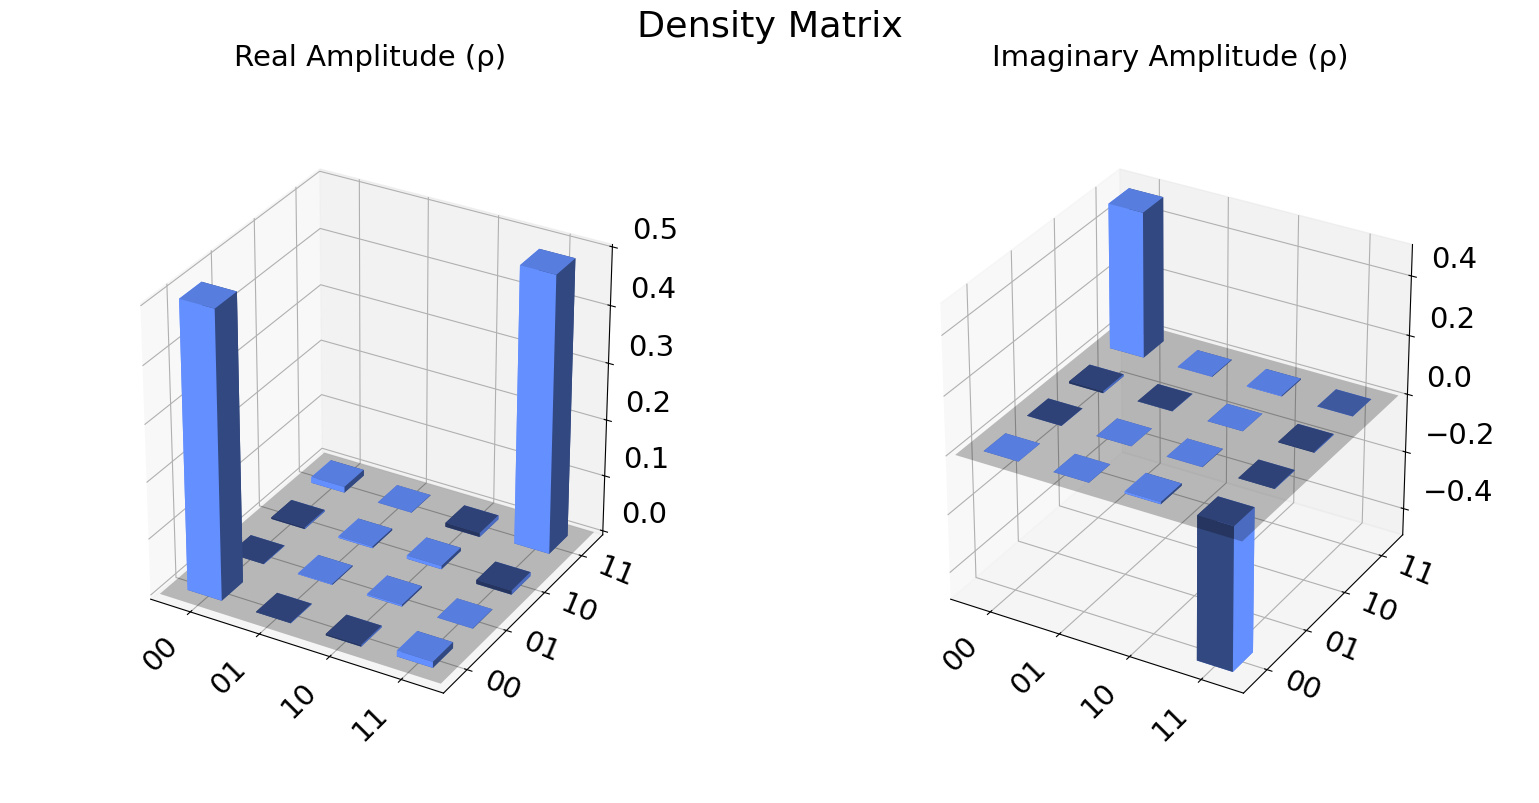

In [6]:
from qiskit import QuantumCircuit
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city

nq = 2
qc_ghz = QuantumCircuit(nq)
qc_ghz.h(0)
qc_ghz.s(0)

for i in range(1, nq):
    qc_ghz.cx(0, i)

backend = Aer.get_backend("aer_simulator")
qstexp = StateTomography(qc_ghz)
qstdata = qstexp.run(backend=backend,
                     shots=1000,
                     seed_simulator=100,).block_for_results()
state_result = qstdata.analysis_results("state")
plot_state_city(state_result.value, title="Density Matrix")

In [7]:
import qiskit
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography

# GHZ State preparation circuit
nq = 2
qc_ghz = qiskit.QuantumCircuit(nq)
qc_ghz.h(0)
qc_ghz.s(0)
for i in range(1, nq):
    qc_ghz.cx(0, i)

# QST Experiment
qstexp1 = StateTomography(qc_ghz)
qstdata1 = qstexp1.run(backend, seed_simulation=100).block_for_results()

# Print results
for result in qstdata1.analysis_results():
    print(result)

AnalysisResult
- name: state
- value: DensityMatrix([[ 0.49542657+0.00000000e+00j,  0.00282196-3.52136324e-05j,
                -0.00438556+3.75413994e-03j,  0.00910416-4.91917916e-01j],
               [ 0.00282196+3.52136324e-05j,  0.00506313+0.00000000e+00j,
                 0.00574857+1.05160009e-04j, -0.00195674+1.34573280e-03j],
               [-0.00438556-3.75413994e-03j,  0.00574857-1.05160009e-04j,
                 0.00667389-4.33680869e-19j, -0.00607687+9.06378400e-03j],
               [ 0.00910416+4.91917916e-01j, -0.00195674-1.34573280e-03j,
                -0.00607687-9.06378400e-03j,  0.4928364 -1.73472348e-18j]],
              dims=(2, 2))
- quality: unknown
- extra: <9 items>
- device_components: ['Q0', 'Q1']
- verified: False
AnalysisResult
- name: state_fidelity
- value: 0.9860494030239524
- quality: unknown
- extra: <9 items>
- device_components: ['Q0', 'Q1']
- verified: False
AnalysisResult
- name: positive
- value: True
- quality: unknown
- extra: <9 items>
- device

In [136]:
kernel = QuantumCircuit(3,3)
kernel.h(1)
kernel.h(2)

kernel.barrier()
kernel.mcry(np.pi,[1,2],0)
kernel.barrier()

kernel.x(2)
kernel.barrier()
kernel.mcry(0,[1,2],0)
kernel.barrier()
kernel.x(2)

kernel.x(1)
kernel.barrier()
kernel.mcry(0,[1,2],0)
kernel.barrier()
kernel.x(1)

kernel.x(1)
kernel.x(2)
kernel.barrier()
kernel.mcry(0,[1,2],0)
kernel.barrier()
kernel.x(2)
kernel.x(1)

kernel.h([0,1,2])

In [140]:
frqi_qft =frqi.from_instructions(frqi)
frqi_qft = Statevector(frqi_qft)

kernel_qft =kernel.from_instructions(kernel)
kernel_qft = Statevector(kernel_qft)
#print(frqi_qft, kernel_qft)

element_wise = frqi_qft.data * kernel_qft.data
element_wise_result_state = Statevector(element_wise)
print(element_wise)

[ 5.83787691e-01+0.j  4.42143777e-19-0.j  6.42680150e-19+0.j
 -6.12876368e-36+0.j  4.08840679e-02+0.j  1.65339598e-01+0.j
  8.46604021e-02+0.j  4.08840679e-02-0.j]


In [142]:
element_wise_ifft = np.fft.ifft(element_wise)
element_wise_ifft

array([0.11444448+0.j        , 0.05686253-0.02881032j,
       0.06750142+0.01555694j, 0.07886337-0.00764522j,
       0.06288856+0.j        , 0.07886337+0.00764522j,
       0.06750142-0.01555694j, 0.05686253+0.02881032j])

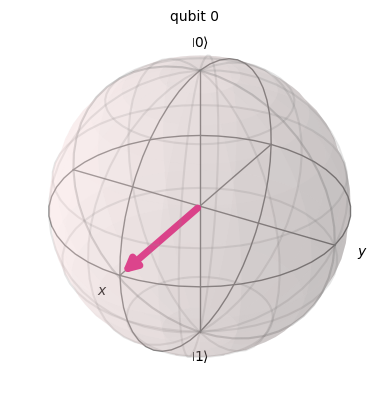

In [245]:
hgate=QuantumCircuit(1,1)
hgate.h(0)
state_hgate=Statevector(hgate)
plot_bloch_multivector(state_hgate)

{'1 0': 523, '0 0': 501}


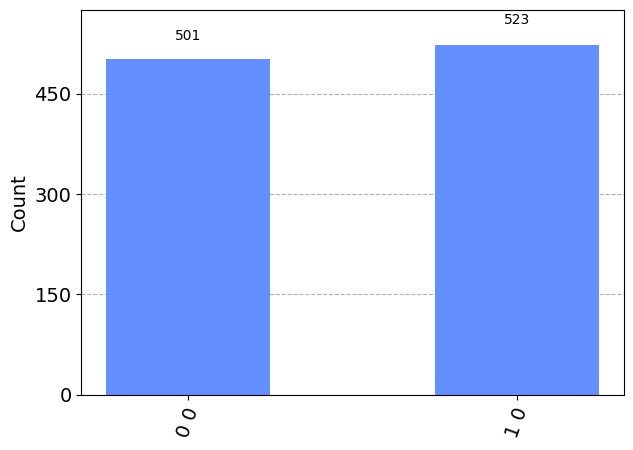

In [246]:
hgate.measure_all()
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(hgate, simulator)
job = execute(compiled_circuit, backend=simulator, shots=1024)
result = job.result()
counts = result.get_counts()

# 결과 출력
print(counts)
plot_histogram(counts)

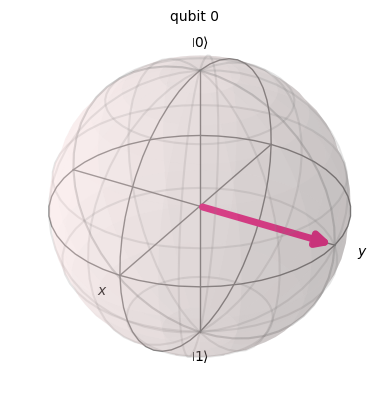

In [247]:
hgate_phase=QuantumCircuit(1,1)
hgate_phase.h(0)
hgate_phase.rz(np.pi/2,0)
state_hgate_phase=Statevector(hgate_phase)
plot_bloch_multivector(state_hgate_phase)


{'1 0': 531, '0 0': 493}


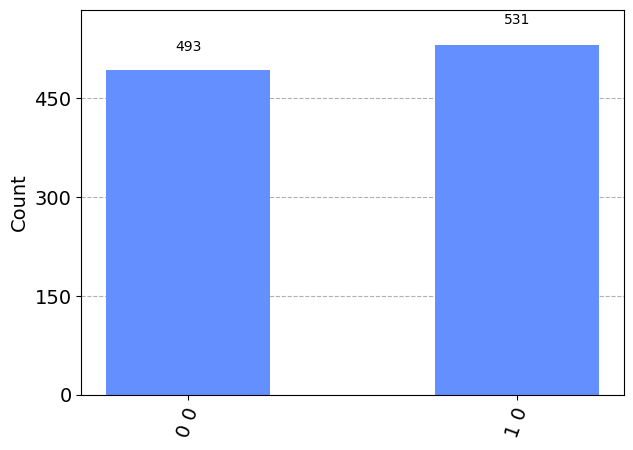

In [248]:
hgate_phase.measure_all()
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(hgate_phase, simulator)
job = execute(compiled_circuit, backend=simulator, shots=1024)
result = job.result()
counts = result.get_counts()

# 결과 출력
print(counts)
plot_histogram(counts)

In [117]:
from qiskit import QuantumCircuit, Aer, transpile, execute
import numpy as np

# 1. Image and Filter definition
image = [0, 50, 127, 255]
filter_ = [0, 0, 0, 1]
n_qubits = int(np.log2(len(image)))

# 2. QFT Quantum Circuit
def qft_circuit(data, n_qubits):
    qc = QuantumCircuit(n_qubits)
    # Angular encoding
    for i, value in enumerate(data):
        bin_index = format(i, f"0{n_qubits}b")
        for j, bit in enumerate(bin_index):
            if bit == '1':
                qc.x(n_qubits - j - 1)
        qc.p(2 * np.pi * value / 255, range(n_qubits))  # Angular Encoding
    
    # QFT
    for i in range(n_qubits):
        qc.h(i)
        for j in range(i+1, n_qubits):
            qc.cp(np.pi / (2 ** (j-i)), j, i)
    
    qc.barrier()
    return qc

# 3. Simulate QFT Circuit
def simulate_qft(qc, n_qubits):
    simulator = Aer.get_backend('statevector_simulator')
    transpiled = transpile(qc, simulator)
    job = execute(transpiled, backend=simulator)
    result = job.result()
    statevector = result.get_statevector()
    return statevector

# QFT on image and filter
qc_image = qft_circuit(image, n_qubits)
qc_filter = qft_circuit(filter_[::-1], n_qubits)  # Filter flipped for circular convolution

qft_image = simulate_qft(qc_image, n_qubits)
qft_filter = simulate_qft(qc_filter, n_qubits)

# 4. Element-wise Multiplication in Quantum State
qft_result = np.array(qft_image) * np.array(qft_filter)

# 5. Inverse FFT using Numpy
ifft_circular_result = np.fft.ifft(qft_result)

# 6. Coefficient adjustment
factor = 1 / len(image)
circular_conv_result = np.real(factor * ifft_circular_result)

qft_image, qft_filter, qft_result, circular_conv_result


(Statevector([-0.49864523+0.03678228j, -0.49864523+0.03678228j,
              -0.49864523+0.03678228j, -0.49864523+0.03678228j],
             dims=(2, 2)),
 Statevector([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j],
             dims=(2, 2)),
 array([-0.24932261+0.01839114j, -0.24932261+0.01839114j,
        -0.24932261+0.01839114j, -0.24932261+0.01839114j]),
 array([-0.06233065,  0.        ,  0.        ,  0.        ]))

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


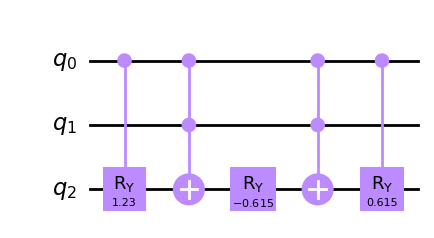

In [141]:
from qiskit.circuit.library import RYGate
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
theta = 1.23

# MCMT로 직접 추가하지 않고 개별 게이트를 구성
qc.cry(theta, 0, 2)
qc.ccx(0, 1, 2)
qc.ry(-theta / 2, 2)
qc.ccx(0, 1, 2)
qc.cry(theta / 2, 0, 2)

qc.draw('mpl')


{'0000': 6701, '1101': 456, '0101': 999, '1011': 962, '0011': 416, '0111': 223, '0001': 6, '1001': 228, '1111': 9}


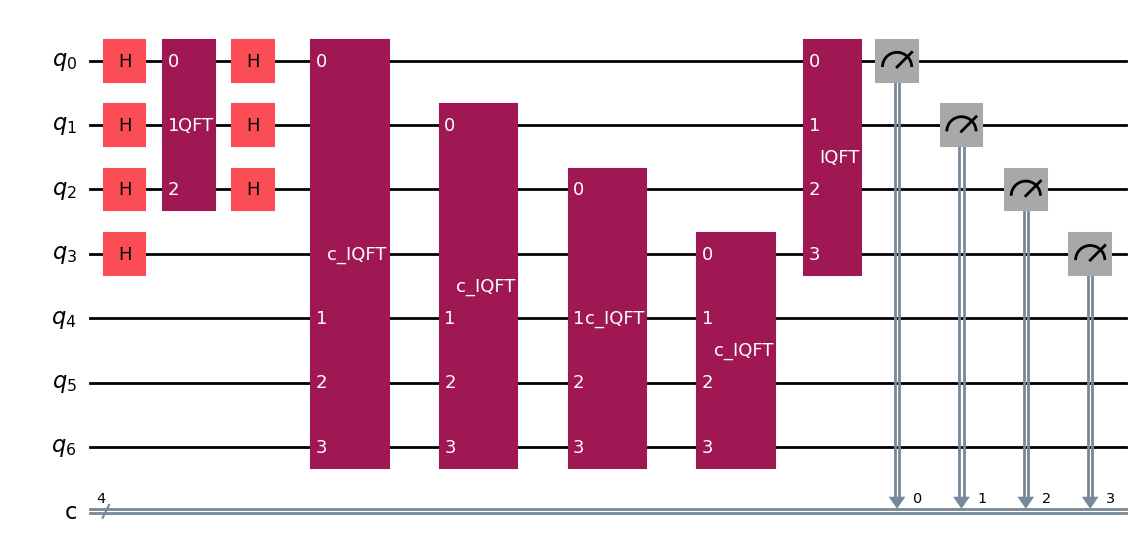

In [228]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
import numpy as np

# Number of qubits for image encoding (data qubits)
n_data = 3  # 예제에서는 3개의 데이터 큐비트 사용
n_ancilla = 4  # 위상을 측정할 보조 큐비트 개수

# 전체 큐비트 수 (Ancilla + Data)
n_total = n_data + n_ancilla

# Create Quantum Circuit
qc = QuantumCircuit(n_total, n_ancilla)

# Step 1: Image encoding (FRQI 방식은 여기에서 간략화)
# 예제에서는 |111> 상태를 준비
qc.h(range(n_data))

# Step 2: Apply QFT (Fourier Transform to Frequency Domain)
qc.append(QFT(n_data), range(n_data))

# Step 3: Quantum Phase Estimation (QPE)
# 3.1 Apply Hadamard gates to Ancilla qubits
qc.h(range(n_ancilla))

# 3.2 Controlled-U gates (U = Inverse QFT)
for i in range(n_ancilla):
    qc.append(QFT(n_data).inverse().control(), [i] + list(range(n_ancilla, n_total)))

# 3.3 Apply inverse QFT on Ancilla qubits
qc.append(QFT(n_ancilla).inverse(), range(n_ancilla))

# Step 4: Measurement of Ancilla qubits
qc.measure(range(n_ancilla), range(n_ancilla))

# Run on Simulator
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)

result = simulator.run(compiled_circuit, shots=10000).result()
counts = result.get_counts()

# 결과 출력
print(counts)

# Quantum Circuit 보기
qc.draw('mpl')


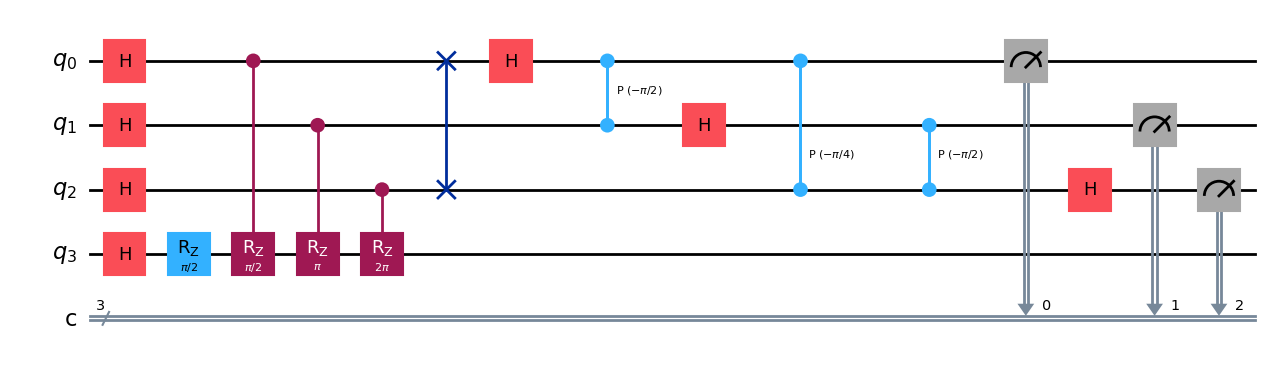

In [227]:
qc.draw('mpl')

{'1110': 93, '1010': 69, '0001': 46, '1000': 94, '0000': 89, '0111': 39, '1100': 83, '0100': 90, '0010': 84, '1001': 43, '0110': 90, '0011': 38, '1101': 33, '0101': 49, '1111': 48, '1011': 36}


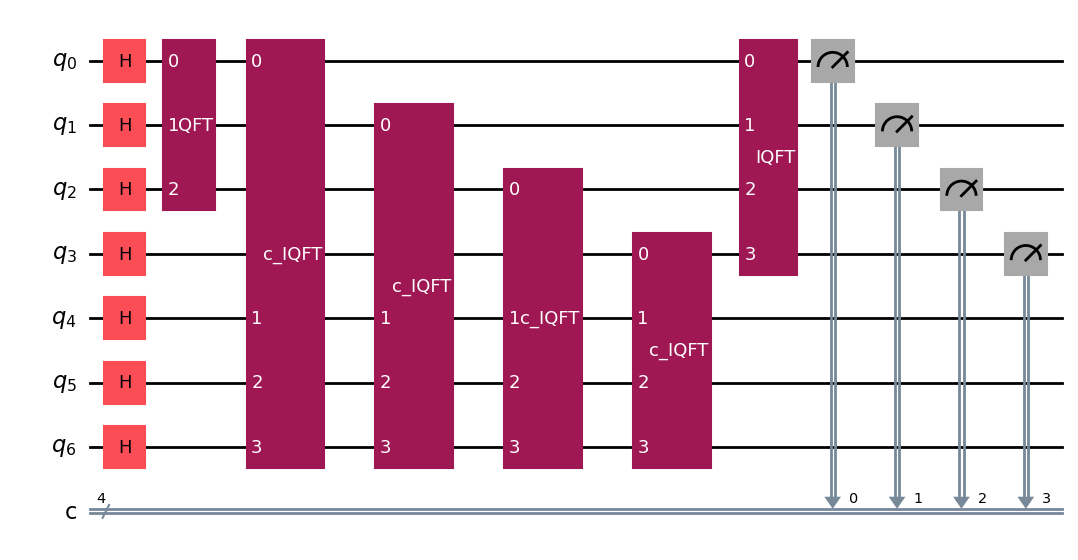

In [38]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.circuit.library import QFT
import numpy as np

# Number of qubits for image encoding (data qubits)
n_data = 3  # 예제에서는 3개의 데이터 큐비트 사용
n_ancilla = 4  # 위상을 측정할 보조 큐비트 개수

# 전체 큐비트 수 (Ancilla + Data)
n_total = n_data + n_ancilla

# Create Quantum Circuit
qc = QuantumCircuit(n_total, n_ancilla)

# Step 1: Image encoding (FRQI 방식은 여기에서 간략화)
# 예제에서는 |111> 상태를 준비
qc.h(range(n_data))

# Step 2: Apply QFT (Fourier Transform to Frequency Domain)
qc.append(QFT(n_data), range(n_data))

# Step 3: Quantum Phase Estimation (QPE)
# 3.1 Apply Hadamard gates to Ancilla qubits
qc.h(range(n_data, n_total))

# 3.2 Controlled-U gates (U = Inverse QFT)
for i in range(n_ancilla):
    qc.append(QFT(n_data).inverse().control(), [i] + list(range(n_ancilla, n_total)))

# 3.3 Apply inverse QFT on Ancilla qubits
qc.append(QFT(n_ancilla).inverse(), range(n_ancilla))

# Step 4: Measurement of Ancilla qubits
qc.measure(range(n_ancilla), range(n_ancilla))

# Run on Simulator
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
#qobj = assemble(compiled_circuit, shots=1000)
result = simulator.run(compiled_circuit).result()
counts = result.get_counts()

# 결과 출력
print(counts)

# Quantum Circuit 보기
qc.draw('mpl')


In [42]:
import numpy as np

# 예제: 측정 결과 (샷 수 기준, 일반적인 n-qubit 케이스)
result_counts = {
    '000': 530, '001': 520, '010': 470, '011': 480,
    '100': 530, '101': 520, '110': 510, '111': 490
}

# 전체 측정 샷 수
total_shots = sum(result_counts.values())

# 각 state의 확률 계산
prob = {state: count / total_shots for state, count in result_counts.items()}

# 기준 state 설정 (예: '000')
reference_state = '000'

# 모든 state에 대해 위상 복원
phases = {}
for state in result_counts.keys():
    if state != reference_state:
        phases[state] = np.angle(prob[state] / prob[reference_state])

# 결과 출력
for state, phase in phases.items():
    print(f"위상 복원 결과 for {state}: {phase:.4f} 라디안")


위상 복원 결과 for 001: 0.0000 라디안
위상 복원 결과 for 010: 0.0000 라디안
위상 복원 결과 for 011: 0.0000 라디안
위상 복원 결과 for 100: 0.0000 라디안
위상 복원 결과 for 101: 0.0000 라디안
위상 복원 결과 for 110: 0.0000 라디안
위상 복원 결과 for 111: 0.0000 라디안


In [2]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
counts

C:\Users\HCI\AppData\Local\Temp\ipykernel_8340\2336452204.py:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


{'10': 90999, '00': 98270, '11': 8966, '01': 1765}

C:\Users\HCI\AppData\Local\Temp\ipykernel_8340\1224835838.py:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


0.40108 s
[array([201.36527588, 100.92918952,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_8340\1224835838.py:102: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors, marker='o')


Text(0, 0.5, 'Green')

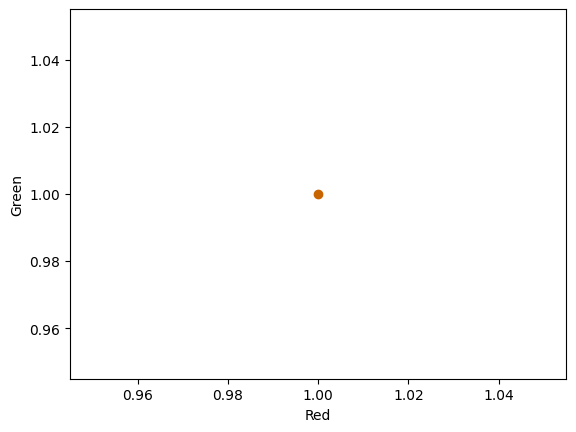

In [75]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color = []
for i in range(len(pixel_color_phi_recon)):
    n_recon = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon = pixel_color_phi_recon[i] * 6 * n_recon / np.pi
    recon_color.append(np.array([n_recon,k_recon,0]))
end = time.time()
time_simul = end - start
print(f'{time_simul:.5f}', "s")
print(recon_color)
recon_color_index = recon_color[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors = recon_color_index / 255
ax.scatter(1,1,c=colors, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [76]:
error = []
for i in range(1):
    del_x = recon_color[0][0] - n
    del_y = recon_color[0][1] - k
    err = del_x**2+del_y**2
    error.append(err)

print("error = ",error,"time = ", time_simul)

error =  [2.727371395714162] time =  0.40108275413513184


In [59]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("api")

364.76714634895325 s
[array([206.00513058, 120.23284475,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_8340\1410872363.py:100: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


Text(0, 0.5, 'Green')

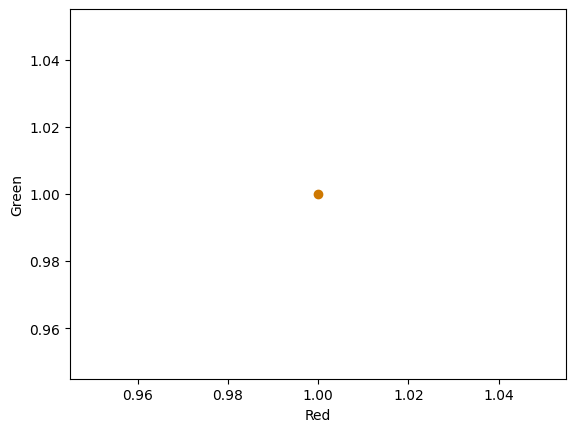

In [80]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=200000, noise_model="aria-1")
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n = pixel_color_theta_recon[i] * 1020 / np.pi
    k = pixel_color_phi_recon[i] * 6 * n / np.pi
    recon_color_ionq.append(np.array([n,k,0]))
end = time.time()
print(f'{end - start}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [ ]:
error_ionq = []
for i in range(1):
    del_x = recon_color_ionq[0][0] - n
    del_y = recon_color_ionq[0][1] - k
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err)

print("error = ",error_ionq,"time = ", time_simul)

error =  [1.651475520773518] time =  0.40108275413513184


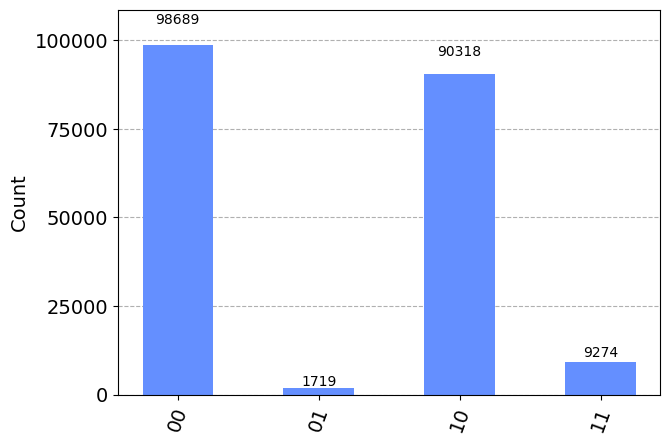

In [ ]:
plot_histogram(counts_ionq)

In [ ]:
qc.draw('mpl')

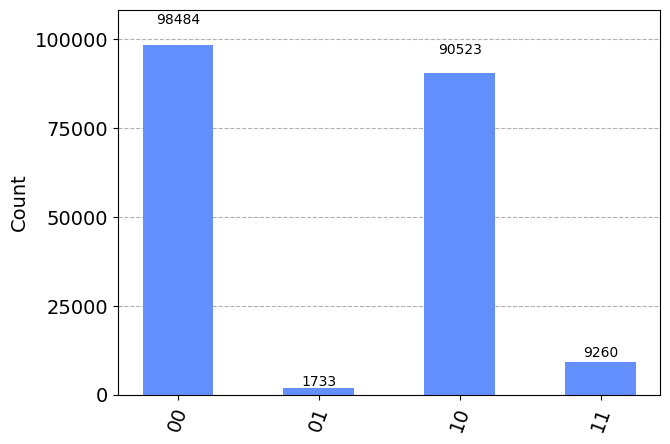

In [26]:
plot_histogram(counts)

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


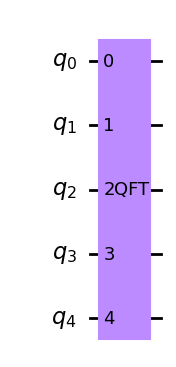

In [3]:
from qiskit.circuit.library import QFT

qft = QFT(5)
qft.draw('mpl')